<a href="https://colab.research.google.com/github/rastehNili/telecomeChurn/blob/main/telecomeChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Kaggle was giving me error that the file is too large to open in Kaggle. I had to download and run it in colab. Asked instructor "Akashdeep Makkar". He suggested to download and run it in colab.**

# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [ ]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy.stats import skew, kurtosis

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Javascript
# set notebook
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)


%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [ ]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

ROOT = "/content/drive/MyDrive/upgrad"

data = pd.read_csv(f"{ROOT}/train.csv")
unseen = pd.read_csv(f"{ROOT}/test.csv")
sample = pd.read_csv(f"{ROOT}/sample.csv")
data_dict = pd.read_csv(f"{ROOT}/data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example:

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [ ]:
data_dict

Acronyms  \
0     CIRCLE_ID   
1           LOC   
2           STD   
3            IC   
4            OG   
5           T2T   
6       T2M       
7       T2O       
8       T2F       
9       T2C       
10     ARPU       
11      MOU       
12      AON       
13     ONNET      
14   OFFNET       
15         ROAM   
16       SPL      
17      ISD       
18     RECH       
19      NUM       
20      AMT       
21      MAX       
22     DATA       
23       3G       
24       AV       
25      VOL       
26       2G       
27      PCK       
28    NIGHT       
29  MONTHLY       
30    SACHET      
31      *.6       
32      *.7       
33      *.8       
34      FB_USER   
35      VBC       

                                                                          Description  
0                                Telecom circle area to which the customer belongs to  
1                                             Local calls  within same telecom circle  
2                                               STD calls  outside the calling circle  
3                                                                      Incoming calls  
4                                                                      Outgoing calls  
5                            Operator T to T ie within same operator mobile to mobile  
6                                                 Operator T to other operator mobile  
7                                             Operator T to other operator fixed line  
8                                                      Operator T to fixed lines of T  
9                                                   Operator T to its own call center  
10                                                           Average revenue per user  
11                                                      Minutes of usage  voice calls  
12        Age on network  number of days the customer is using the operator T network  
13                                 All kind of calls within the same operator network  
14                                   All kind of calls outside the operator T network  
15                         Indicates that customer is in roaming zone during the call  
16                                                                      Special calls  
17                                                                          ISD calls  
18                                                                           Recharge  
19                                                                             Number  
20                                                           Amount in local currency  
21                                                                            Maximum  
22                                                                    Mobile internet  
23                                                                          G network  
24                                                                            Average  
25                                                 Mobile internet usage volume in MB  
26                                                                          G network  
27                                              Prepaid service schemes called  PACKS  
28                                     Scheme to use during specific night hours only  
29                                Service schemes with validity equivalent to a month  
30                                 Service schemes with validity smaller than a month  
31                                                          KPI for the month of June  
32                                                          KPI for the month of July  
33                                                        KPI for the month of August  
34   Service scheme to avail services of Facebook and similar social networking sites  
35  Volume based cost  when no specific scheme is not purchased and paid as per usage

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

# Identify low variant columns:
print(data.nunique().sort_values(ascending=True).head(15))

<IPython.core.display.Javascript object>

std_ic_t2o_mou_6        1
circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
last_date_of_month_7    1
last_date_of_month_8    1
std_ic_t2o_mou_8        1
std_og_t2c_mou_8        1
std_og_t2c_mou_7        1
std_og_t2c_mou_6        1
std_ic_t2o_mou_7        1
night_pck_user_6        2
night_pck_user_7        2
dtype: int64


**Find and remove univariant columns:**

["std_ic_t2o_mou_6", "circle_id", "loc_og_t2o_mou", "std_og_t2o_mou", "loc_ic_t2o_mou", "last_date_of_month_6", "last_date_of_month_7", "last_date_of_month_8", "std_ic_t2o_mou_8", "std_og_t2c_mou_8", "std_og_t2c_mou_7", "std_og_t2c_mou_6", "std_ic_t2o_mou_7"] are univariant columns so need to be removed from both train and test set

In [ ]:
univarCols = data.nunique().sort_values(ascending=True).head(13).index.tolist()
univarCols
data.drop(columns=univarCols, inplace=True)
unseen.drop(columns=univarCols, inplace=True)

In [ ]:
# use include all to have both categorical and numerical variables
data.describe(include="all")

id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count   69999.000000  69999.000000  69999.000000  69999.000000  67231.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    34999.000000    283.134365    278.185912    278.858826    133.153275   
std     20207.115084    334.213918    344.366927    351.924315    299.963093   
min         0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%     17499.500000     93.581000     86.714000     84.095000      7.410000   
50%     34999.000000    197.484000    191.588000    192.234000     34.110000   
75%     52498.500000    370.791000    365.369500    369.909000    119.390000   
max     69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

         onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count   67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean      133.894438    132.978257    198.874771    197.153383    196.543577   
std       311.277193    311.896596    316.818355    322.482226    324.089234   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         6.675000      6.410000     34.860000     32.240000     31.575000   
50%        32.280000     32.100000     96.480000     91.885000     91.800000   
75%       115.837500    115.060000    232.990000    227.630000    229.345000   
max      8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

        roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count    67231.000000   67312.000000   66296.000000   67231.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         9.765435       7.014568       7.004892      14.186457   
std         57.374429      55.960985      53.408135      73.469261   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000       0.000000       0.000000       0.000000   
max       2850.980000    4155.830000    4169.810000    3775.110000   

        roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count    67312.000000   66296.000000      67231.000000      67312.000000   
unique            NaN            NaN               NaN               NaN   
top               NaN            NaN               NaN               NaN   
freq              NaN            NaN               NaN               NaN   
mean         9.842191       9.771783         46.904854         46.166503   
std         58.511894      64.618388        150.971758        154.739002   
min          0.000000       0.000000          0.000000          0.000000   
25%          0.000000       0.000000          1.660000          1.650000   
50%          0.000000       0.000000         11.910000         11.580000   
75%          0.000000       0.000000         40.740000         39.760000   
max       2812.040000    5337.040000       6431.330000       7400.660000   

        loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count       66296.000000      67231.000000      67312.000000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean           45.6861

**Check percentages of missing values in each column:**

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

# find percentage of missing values in each column
percNaDf = (data.isnull().sum()/data.shape[0])*100
print(percNaDf[percNaDf>0])

# check presence of blank rows
null_mask = data.isnull().all(axis=1)
null_rows = data[null_mask]

print("\nNumber of Blank Rows:", null_rows.shape[0])

# check rows with missing values
null_mask = data.isnull().any(axis=1)
null_rows = data[null_mask]

print("Number Rows with Missing values:", null_rows.shape[0])

<IPython.core.display.Javascript object>

onnet_mou_6                  3.954342
onnet_mou_7                  3.838626
onnet_mou_8                  5.290076
offnet_mou_6                 3.954342
offnet_mou_7                 3.838626
offnet_mou_8                 5.290076
roam_ic_mou_6                3.954342
roam_ic_mou_7                3.838626
roam_ic_mou_8                5.290076
roam_og_mou_6                3.954342
roam_og_mou_7                3.838626
roam_og_mou_8                5.290076
loc_og_t2t_mou_6             3.954342
loc_og_t2t_mou_7             3.838626
loc_og_t2t_mou_8             5.290076
loc_og_t2m_mou_6             3.954342
loc_og_t2m_mou_7             3.838626
loc_og_t2m_mou_8             5.290076
loc_og_t2f_mou_6             3.954342
loc_og_t2f_mou_7             3.838626
loc_og_t2f_mou_8             5.290076
loc_og_t2c_mou_6             3.954342
loc_og_t2c_mou_7             3.838626
loc_og_t2c_mou_8             5.290076
loc_og_mou_6                 3.954342
loc_og_mou_7                 3.838626
loc_og_mou_8

<Axes: >

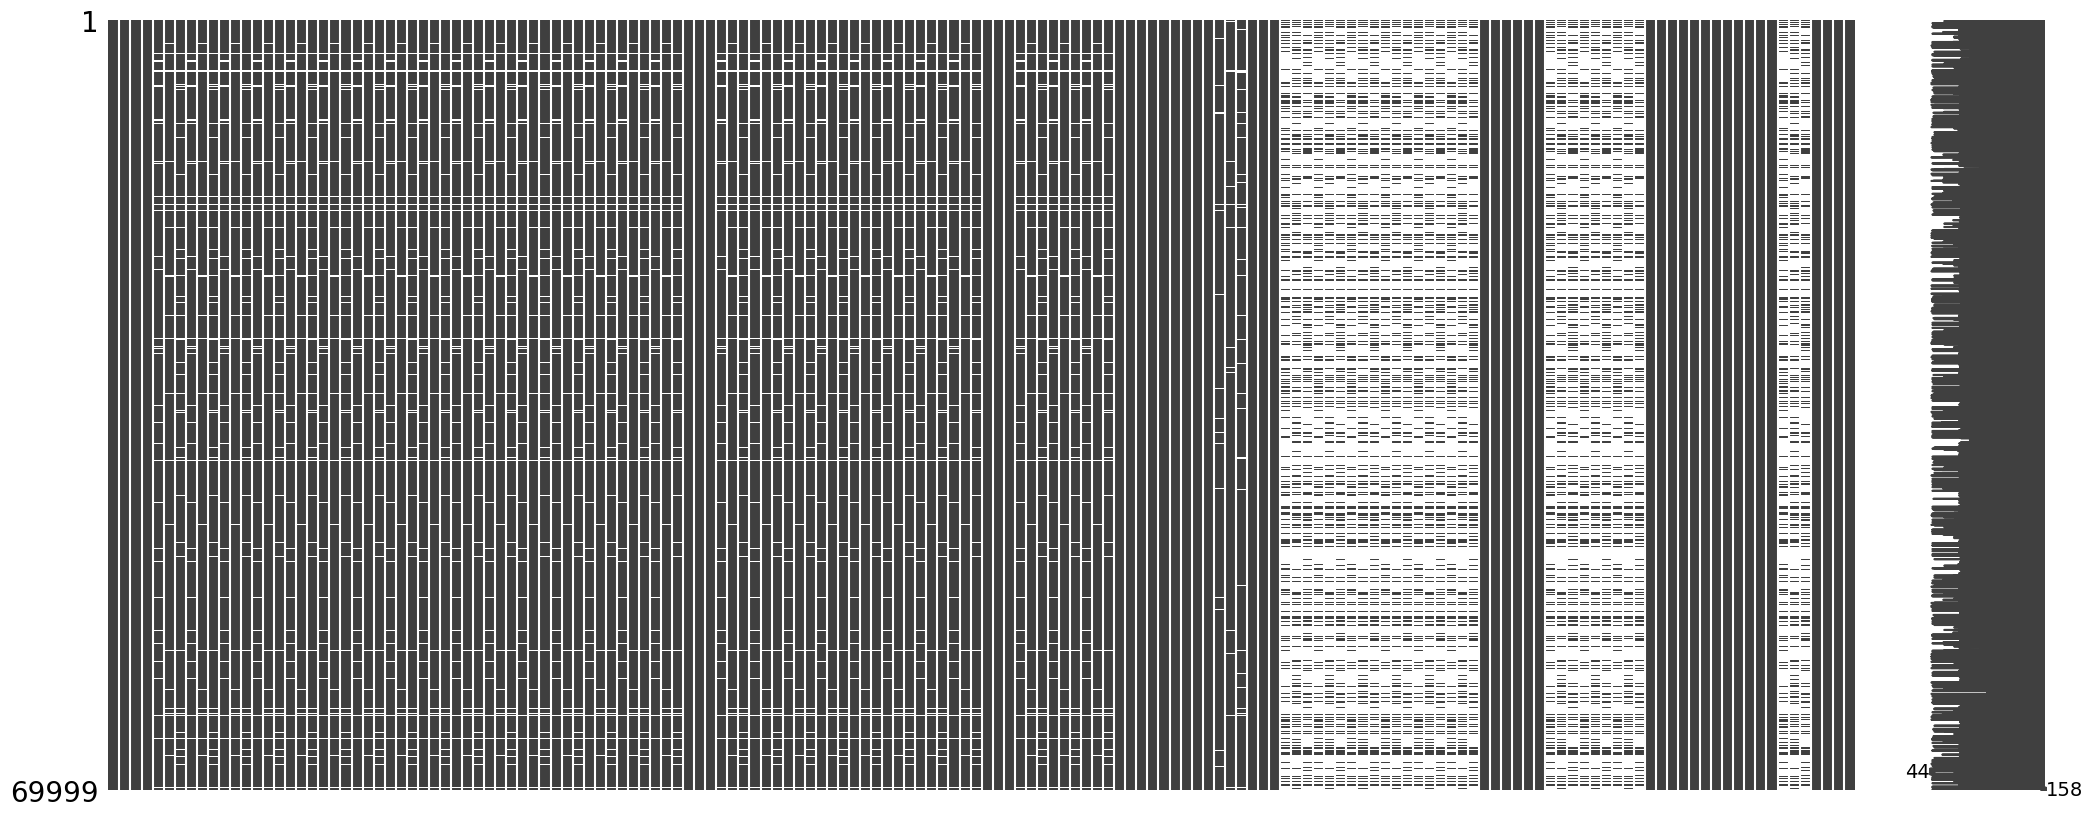

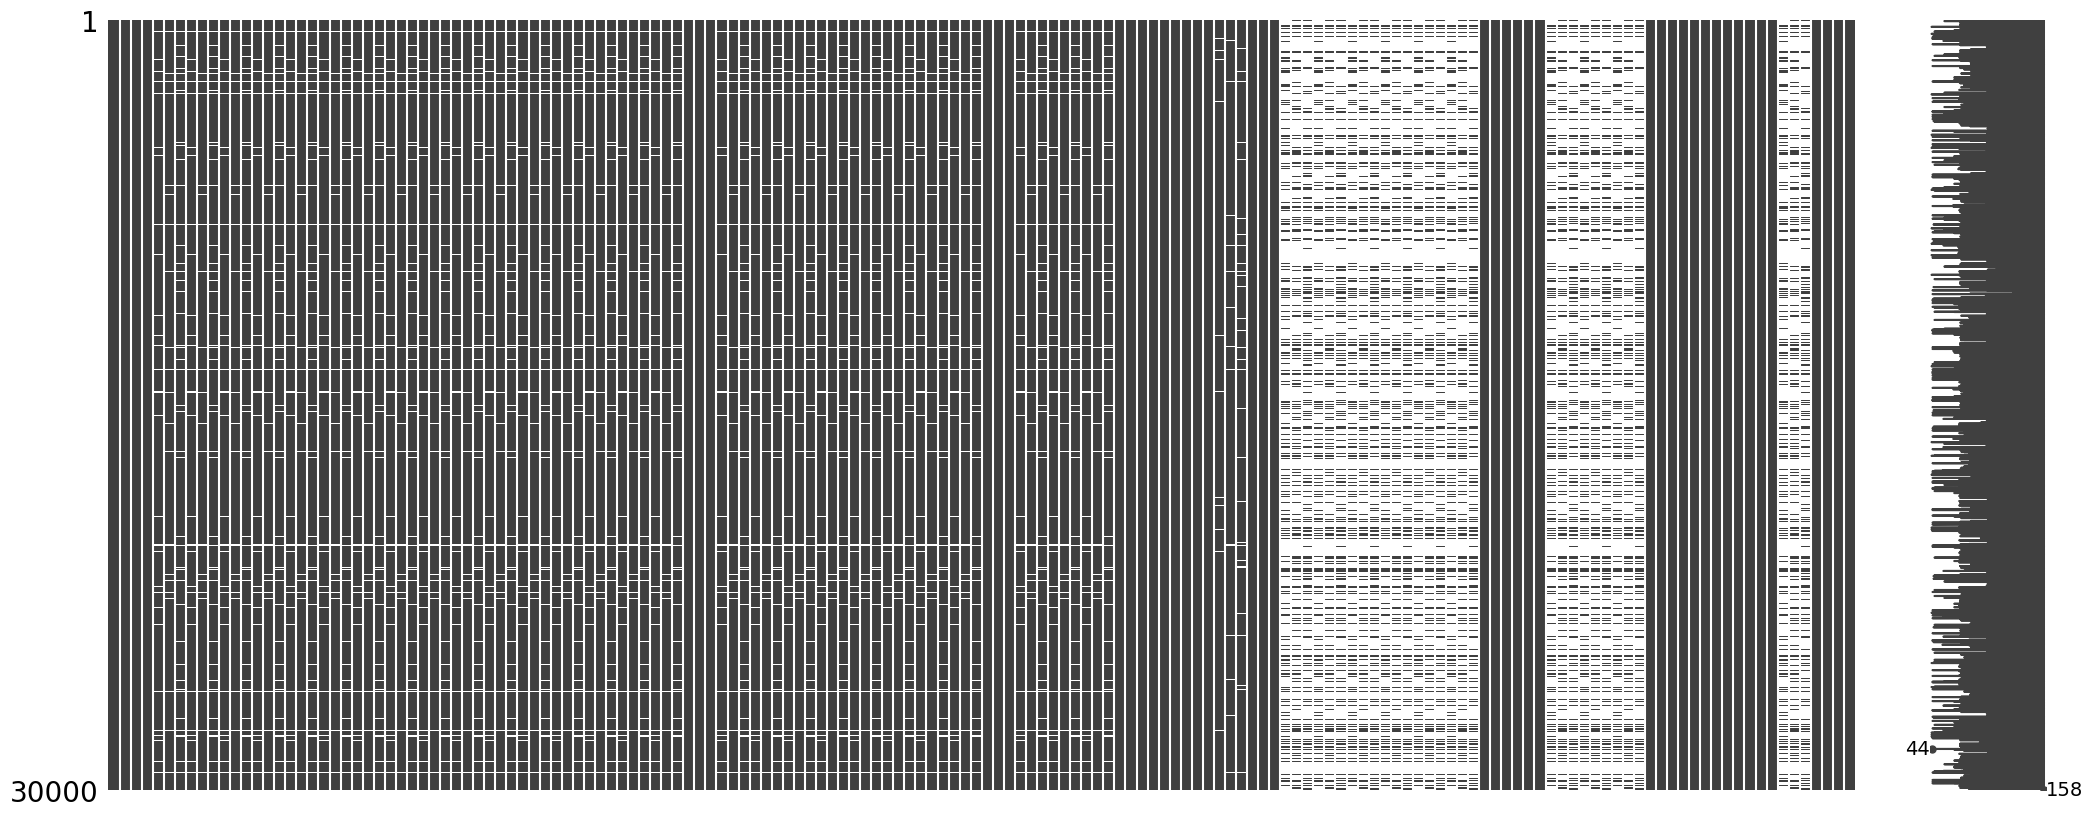

In [ ]:
# visualise test and train missing value pattern to compare between test and train set
yCol = "churn_probability"
xCols = unseen.columns.tolist()
msno.matrix(data[xCols])
msno.matrix(unseen)

For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables.

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

id                   69999
total_rech_amt_6      2108
total_rech_amt_7      2147
total_rech_amt_8      2149
total_og_mou_6       33135
total_og_mou_7       33195
total_og_mou_8       32897
offnet_mou_6         26254
offnet_mou_7         26139
offnet_mou_8         25995
arpu_3g_6             5506
arpu_3g_7             5389
arpu_3g_8             5816
arpu_2g_6             5389
arpu_2g_7             5056
arpu_2g_8             5132
vol_3g_mb_6           9768
vol_3g_mb_7          10296
vol_3g_mb_8          10663
vol_2g_mb_6          11494
vol_2g_mb_7          11443
vol_2g_mb_8          11359
aon                   3455
churn_probability        2
dtype: int64

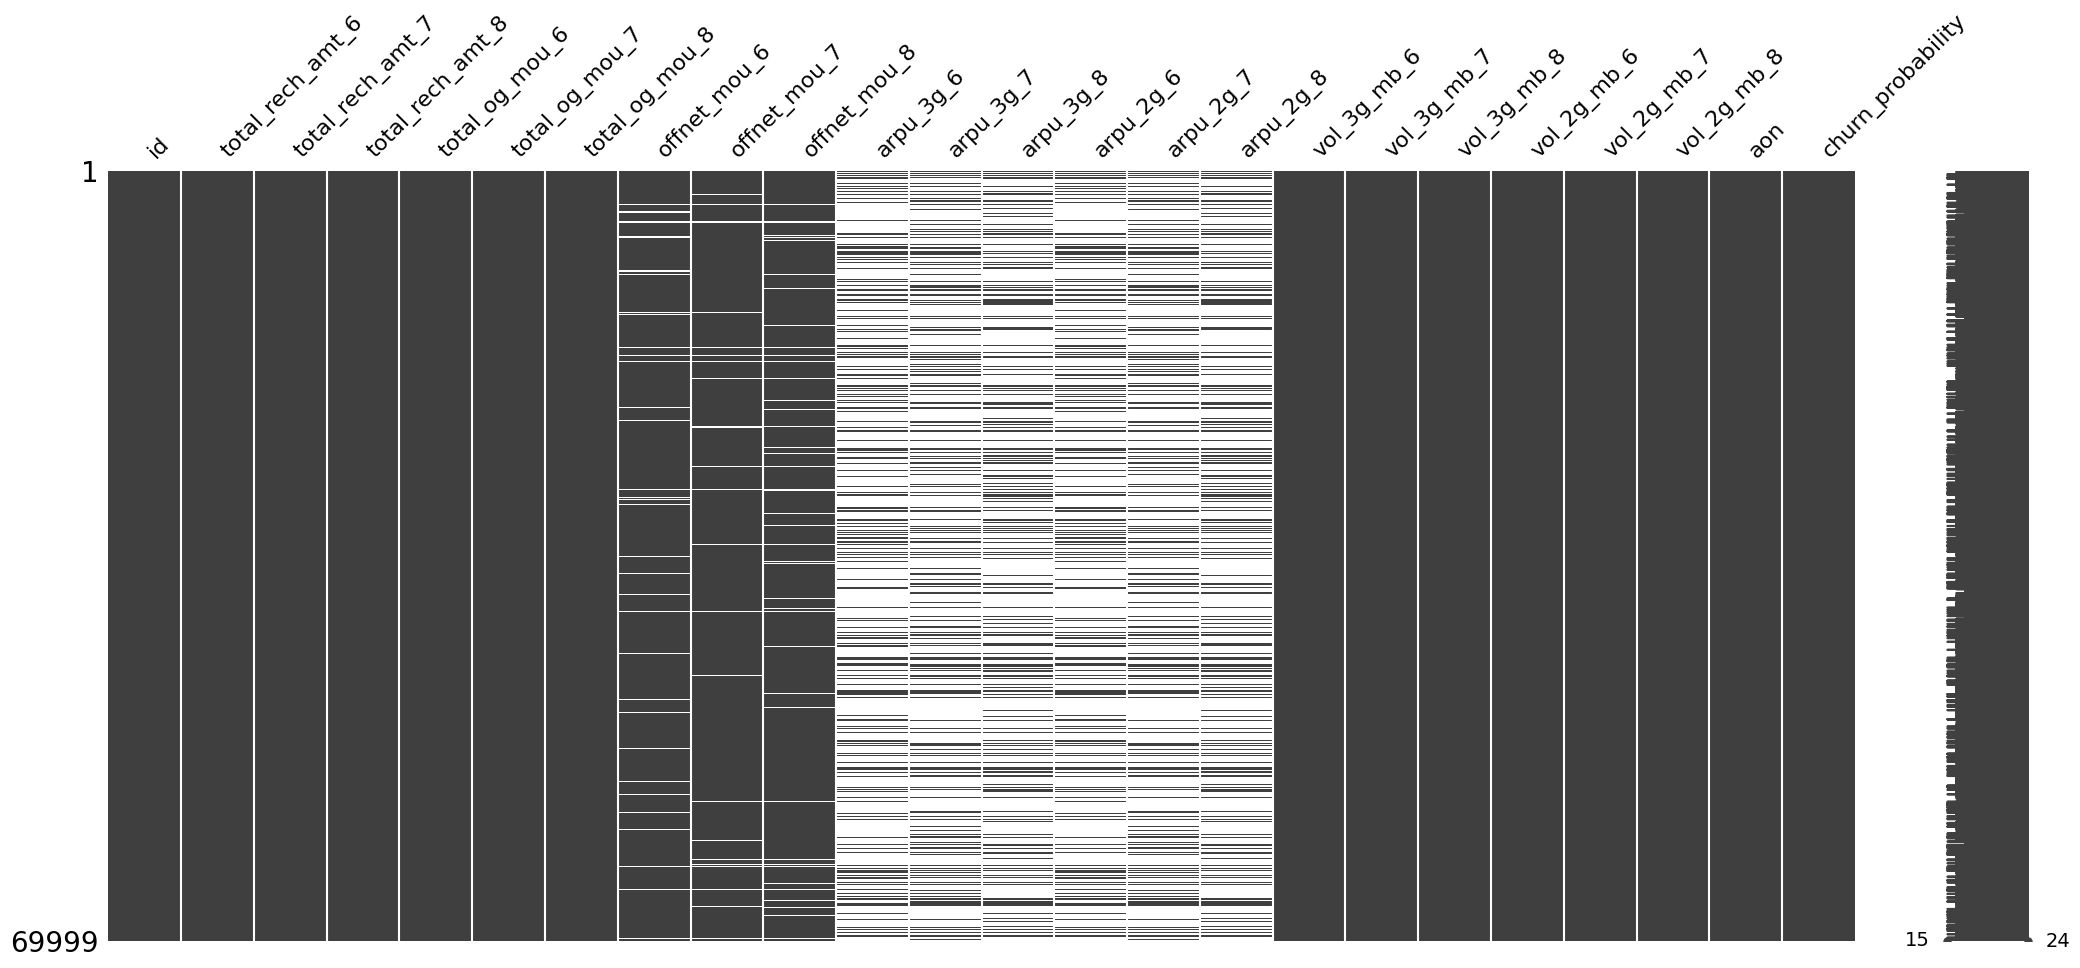

In [ ]:
ids = ['id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids,
             *total_amounts,
             *total_outgoing_minutes,
             *offnetwork_minutes,
             *average_revenue_3g,
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network,
             'churn_probability']

msno.matrix(data[variables])

data[variables].nunique()
# data = data[variables].set_index('id')

<IPython.core.display.Javascript object>

<Axes: >

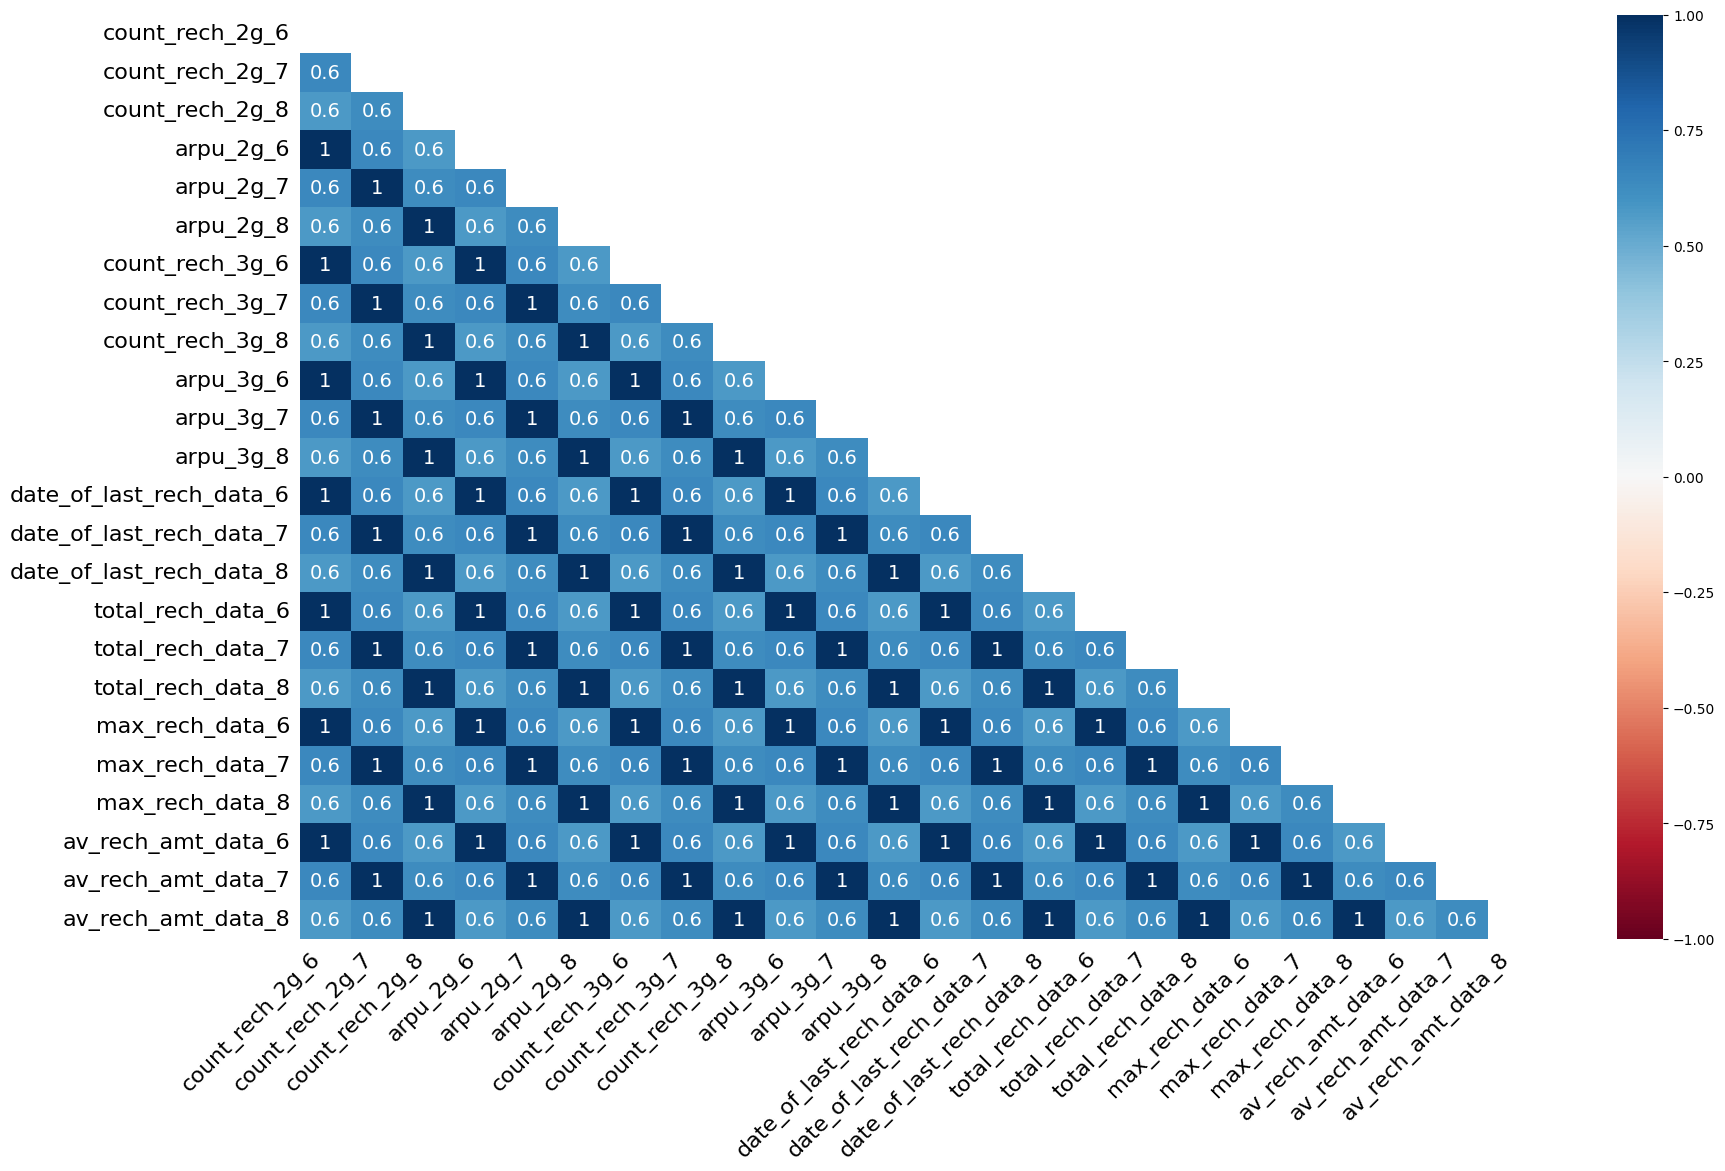

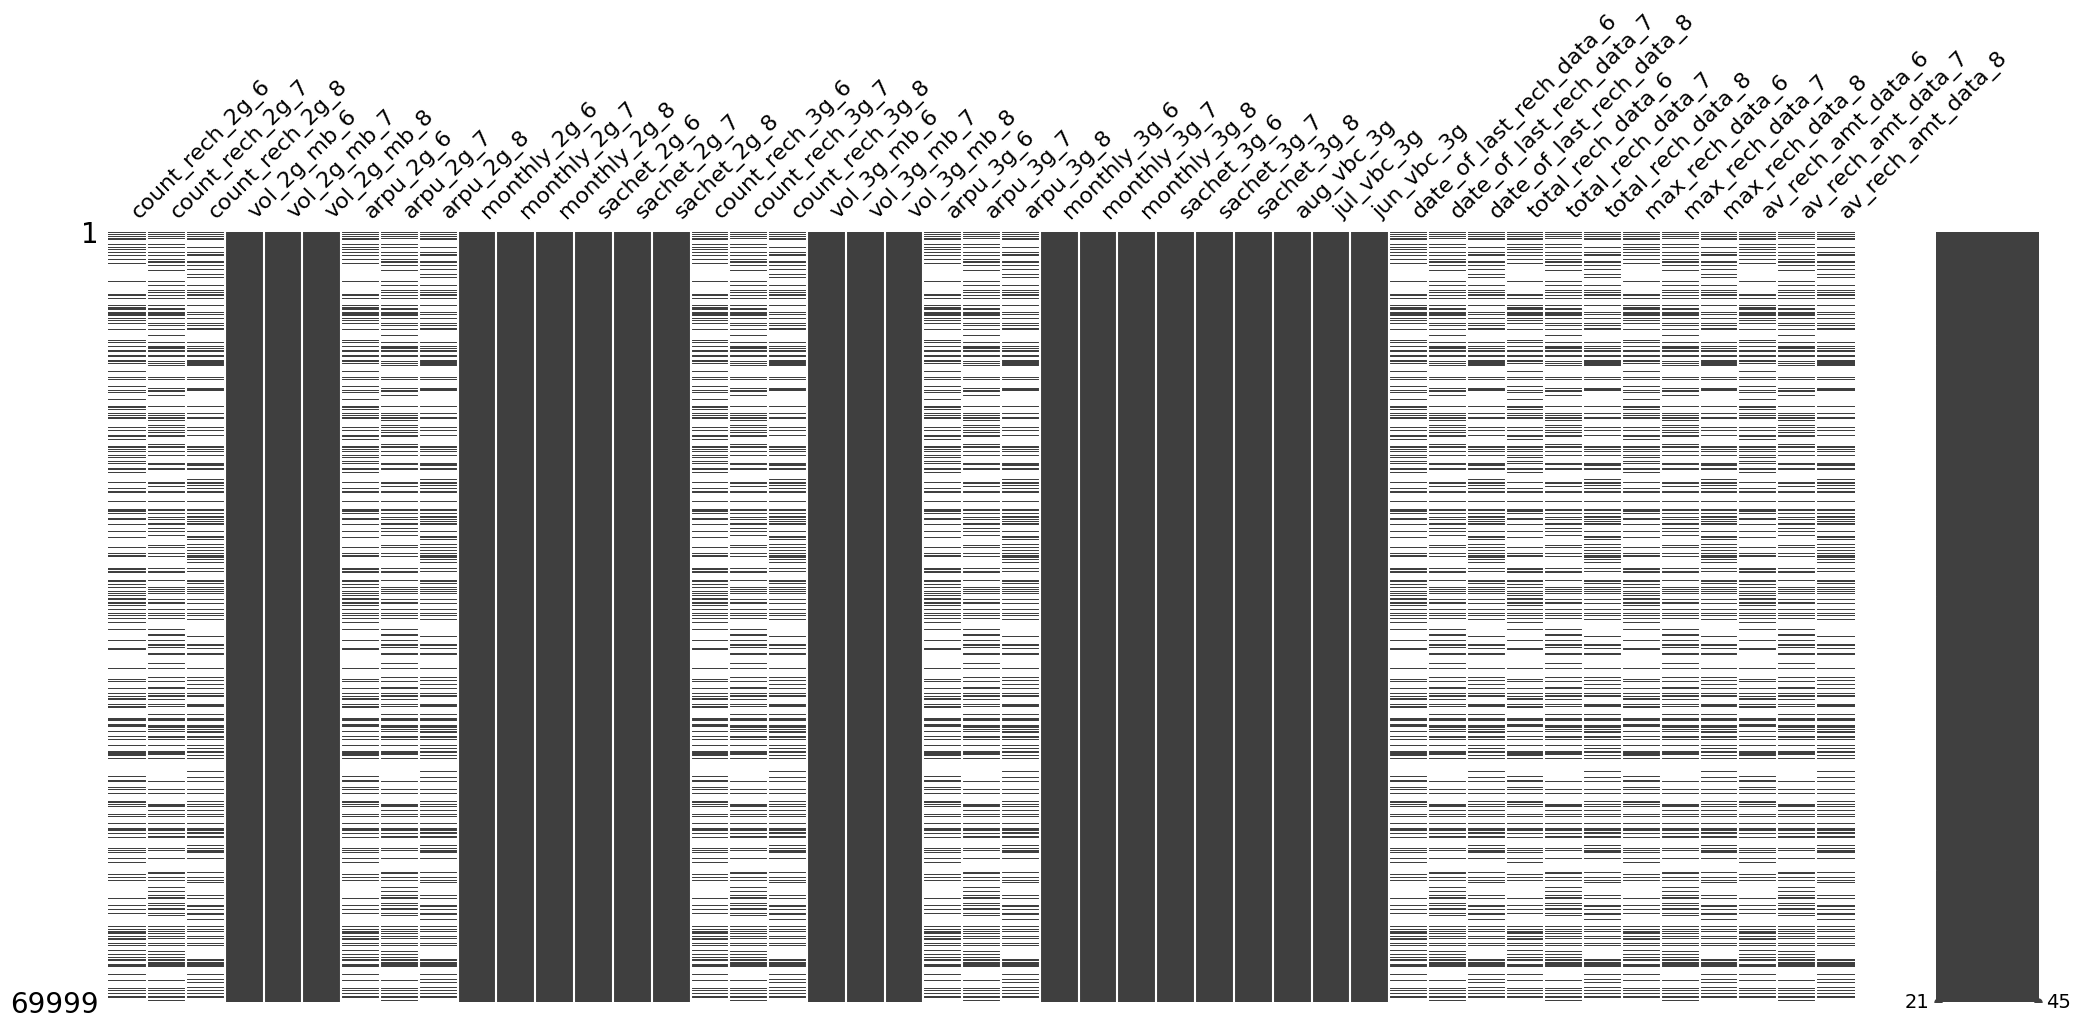

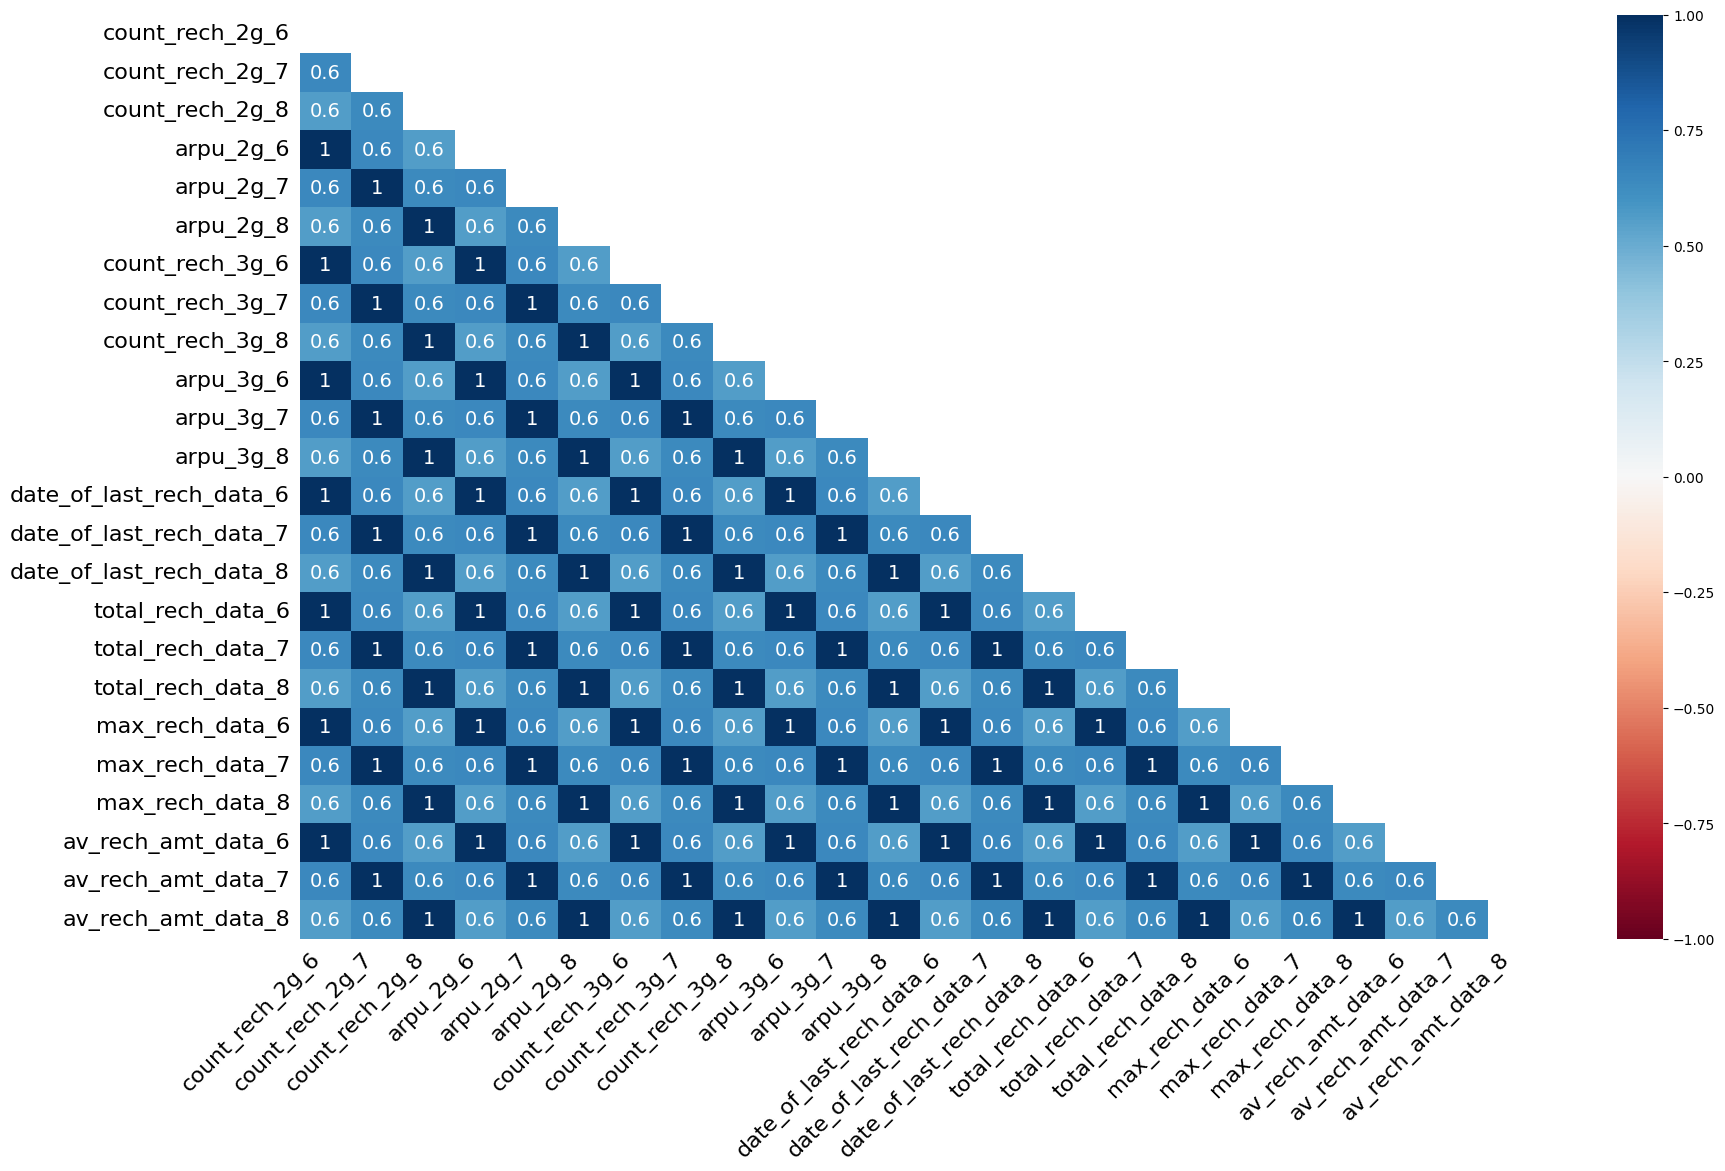

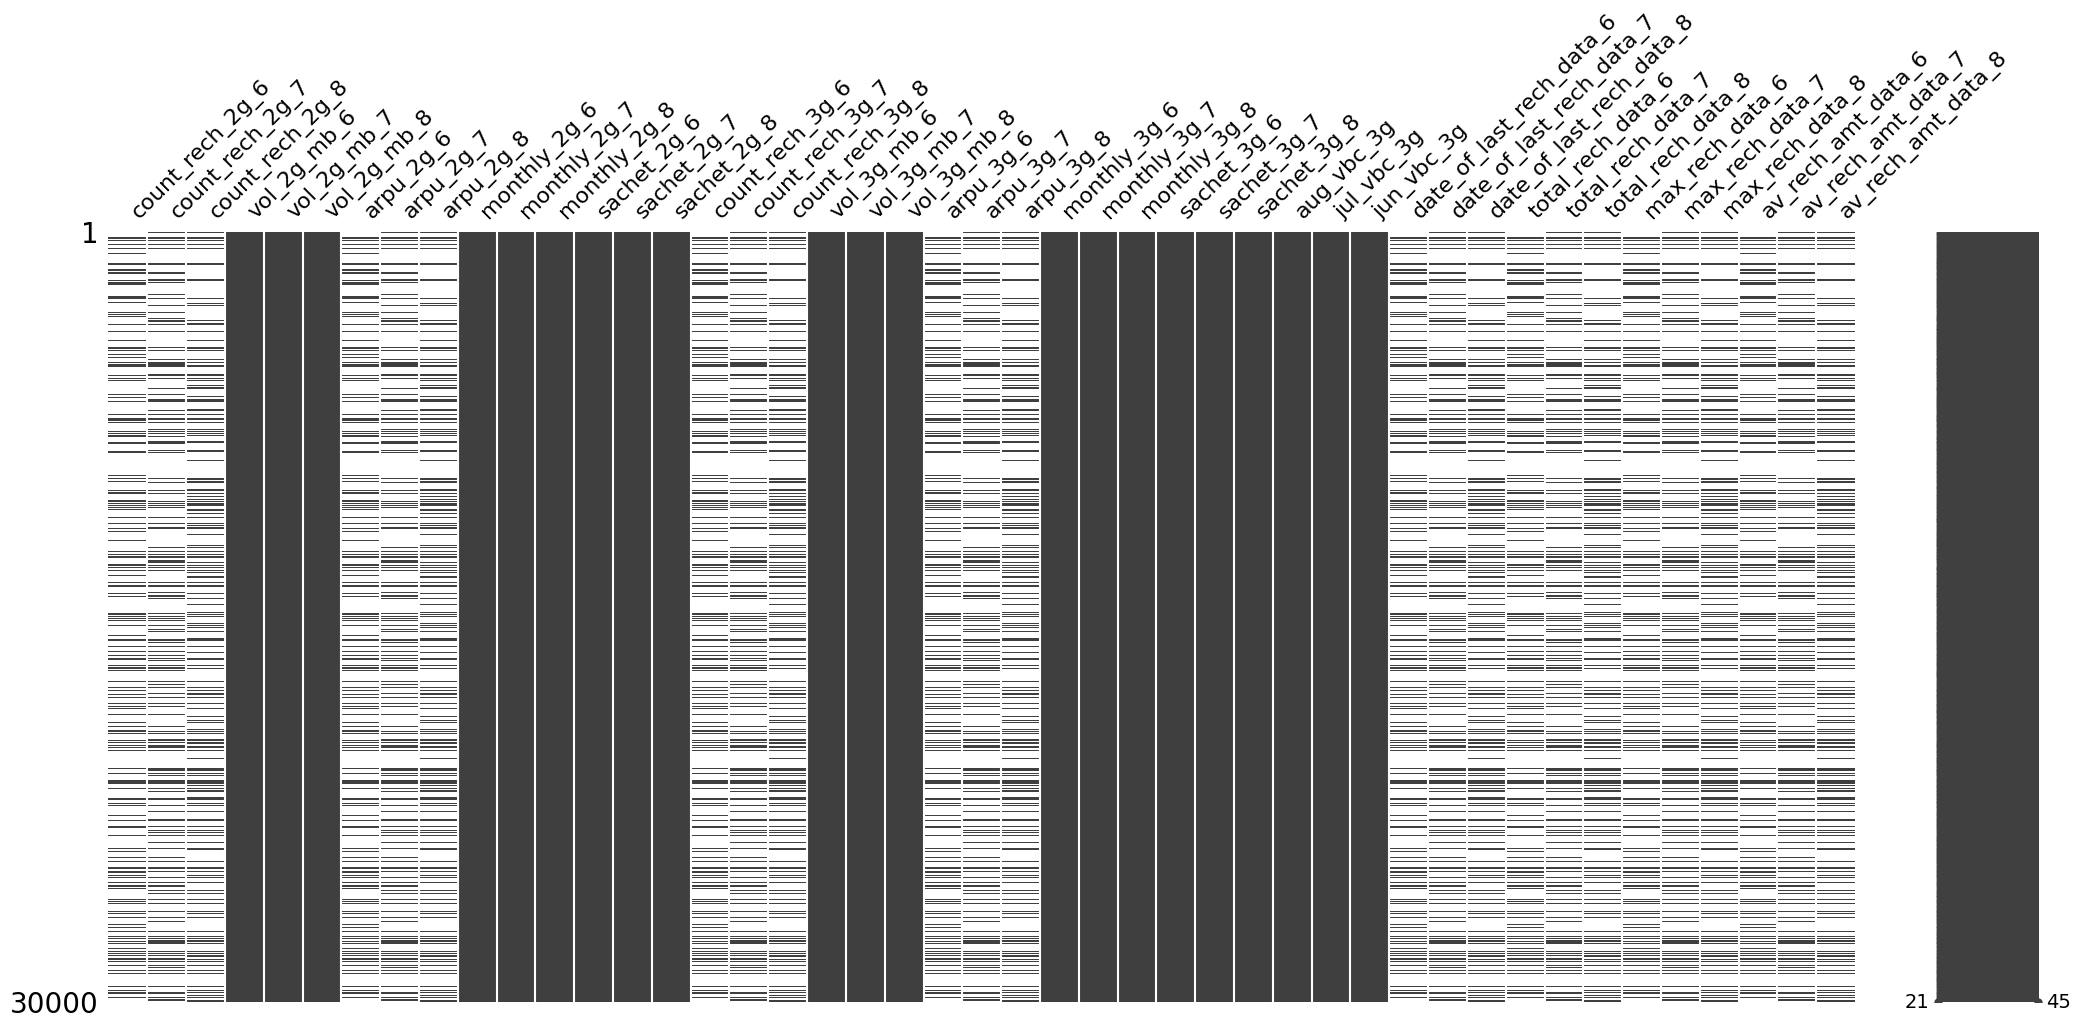

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
xCols= unseen.columns.tolist()
data = data.set_index('id')

dataUsage = list(filter(lambda x: re.search("2g", x), xCols)) + list(filter(lambda x: re.search("3g", x), xCols)) + list(filter(lambda x: re.search("data", x), xCols))

msno.heatmap(data[dataUsage])
msno.matrix(data[dataUsage])
msno.heatmap(unseen[dataUsage])
msno.matrix(unseen[dataUsage])

In [ ]:
data.columns.tolist()

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
# find percentage of missing values in each column
percNaDf = (data[dataUsage].isnull().sum()/data[dataUsage].shape[0])*100
print(percNaDf[percNaDf>0])

# check presence of blank rows
null_mask = data[dataUsage].isnull().all(axis=1)
null_rows = data[null_mask]

print("\nNumber of Blank Rows:", null_rows.shape[0])

# check rows with missing values
null_mask = data[dataUsage].isnull().any(axis=1)
null_rows = data[null_mask]

print("Number Rows with Missing values:", null_rows.shape[0])

<IPython.core.display.Javascript object>

count_rech_2g_6             74.902499
count_rech_2g_7             74.478207
count_rech_2g_8             73.689624
arpu_2g_6                   74.902499
arpu_2g_7                   74.478207
arpu_2g_8                   73.689624
count_rech_3g_6             74.902499
count_rech_3g_7             74.478207
count_rech_3g_8             73.689624
arpu_3g_6                   74.902499
arpu_3g_7                   74.478207
arpu_3g_8                   73.689624
date_of_last_rech_data_6    74.902499
date_of_last_rech_data_7    74.478207
date_of_last_rech_data_8    73.689624
total_rech_data_6           74.902499
total_rech_data_7           74.478207
total_rech_data_8           73.689624
max_rech_data_6             74.902499
max_rech_data_7             74.478207
max_rech_data_8             73.689624
av_rech_amt_data_6          74.902499
av_rech_amt_data_7          74.478207
av_rech_amt_data_8          73.689624
dtype: float64

Number of Blank Rows: 0
Number Rows with Missing values: 59313


<IPython.core.display.Javascript object>

<Axes: >

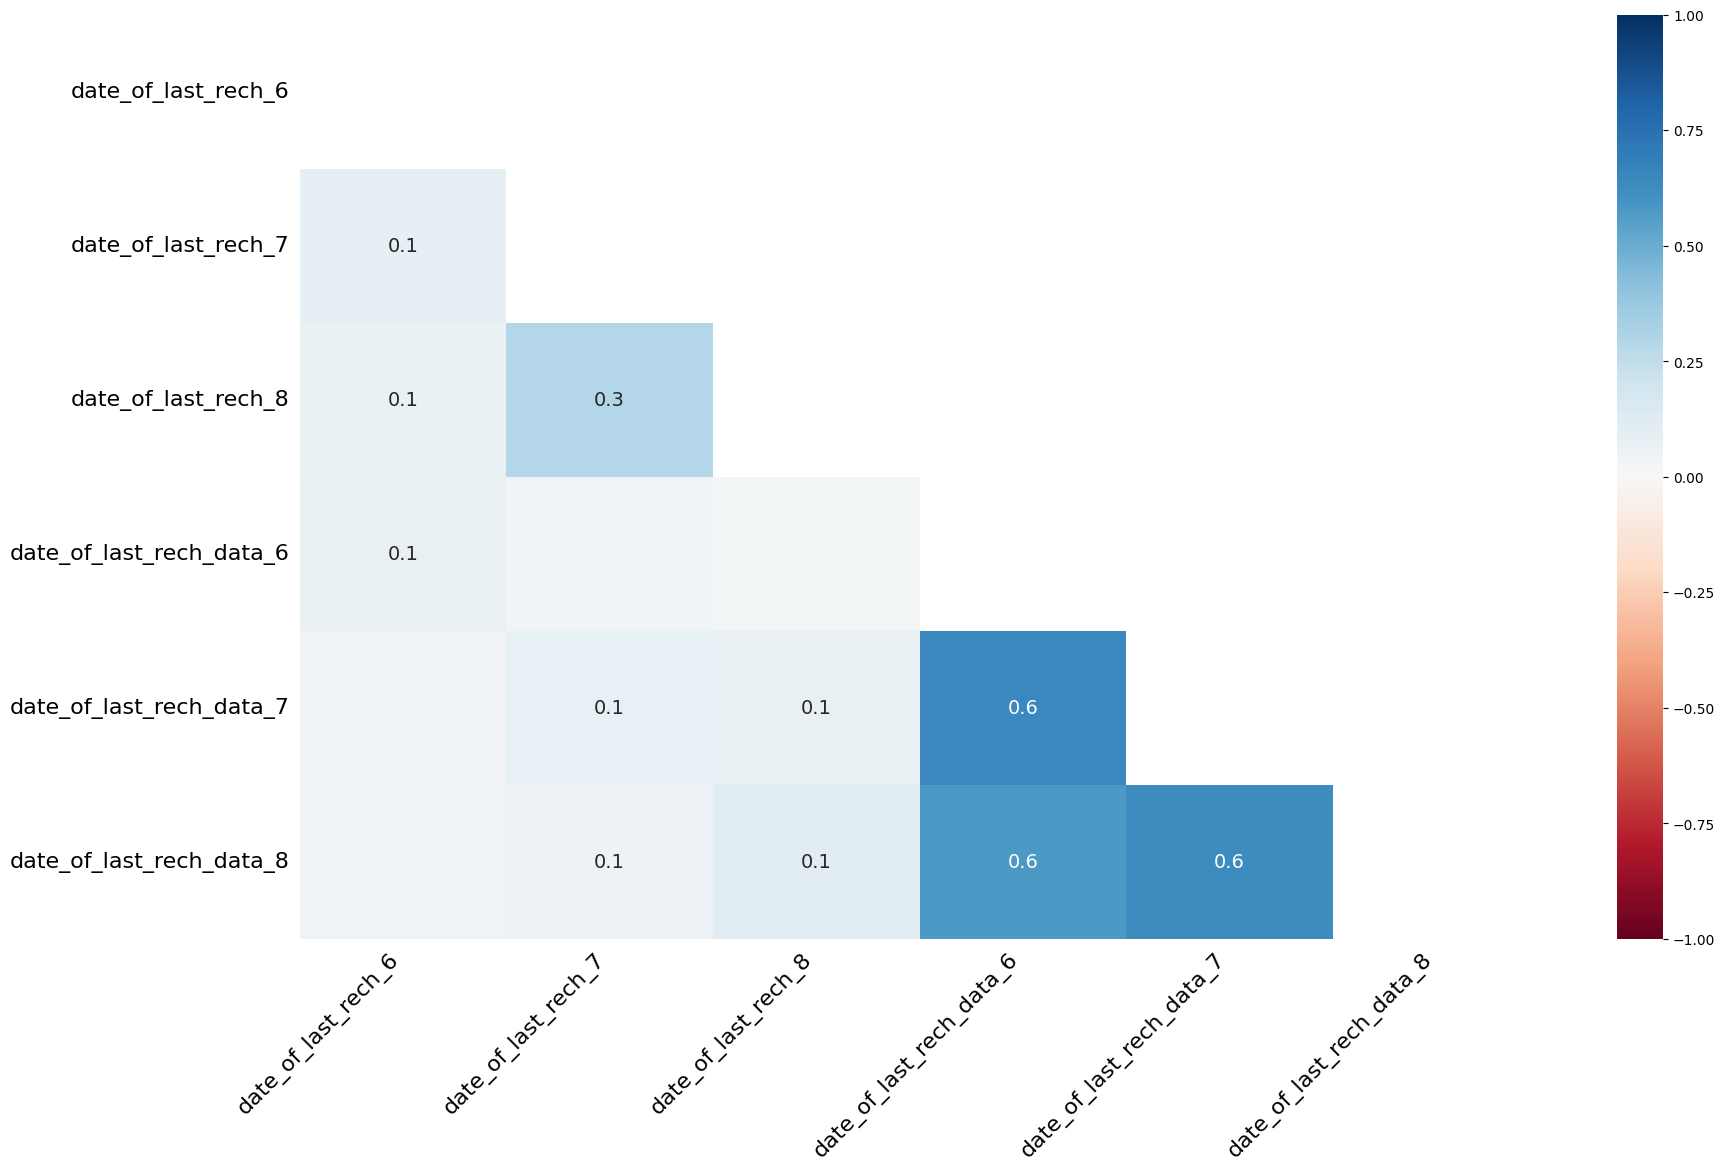

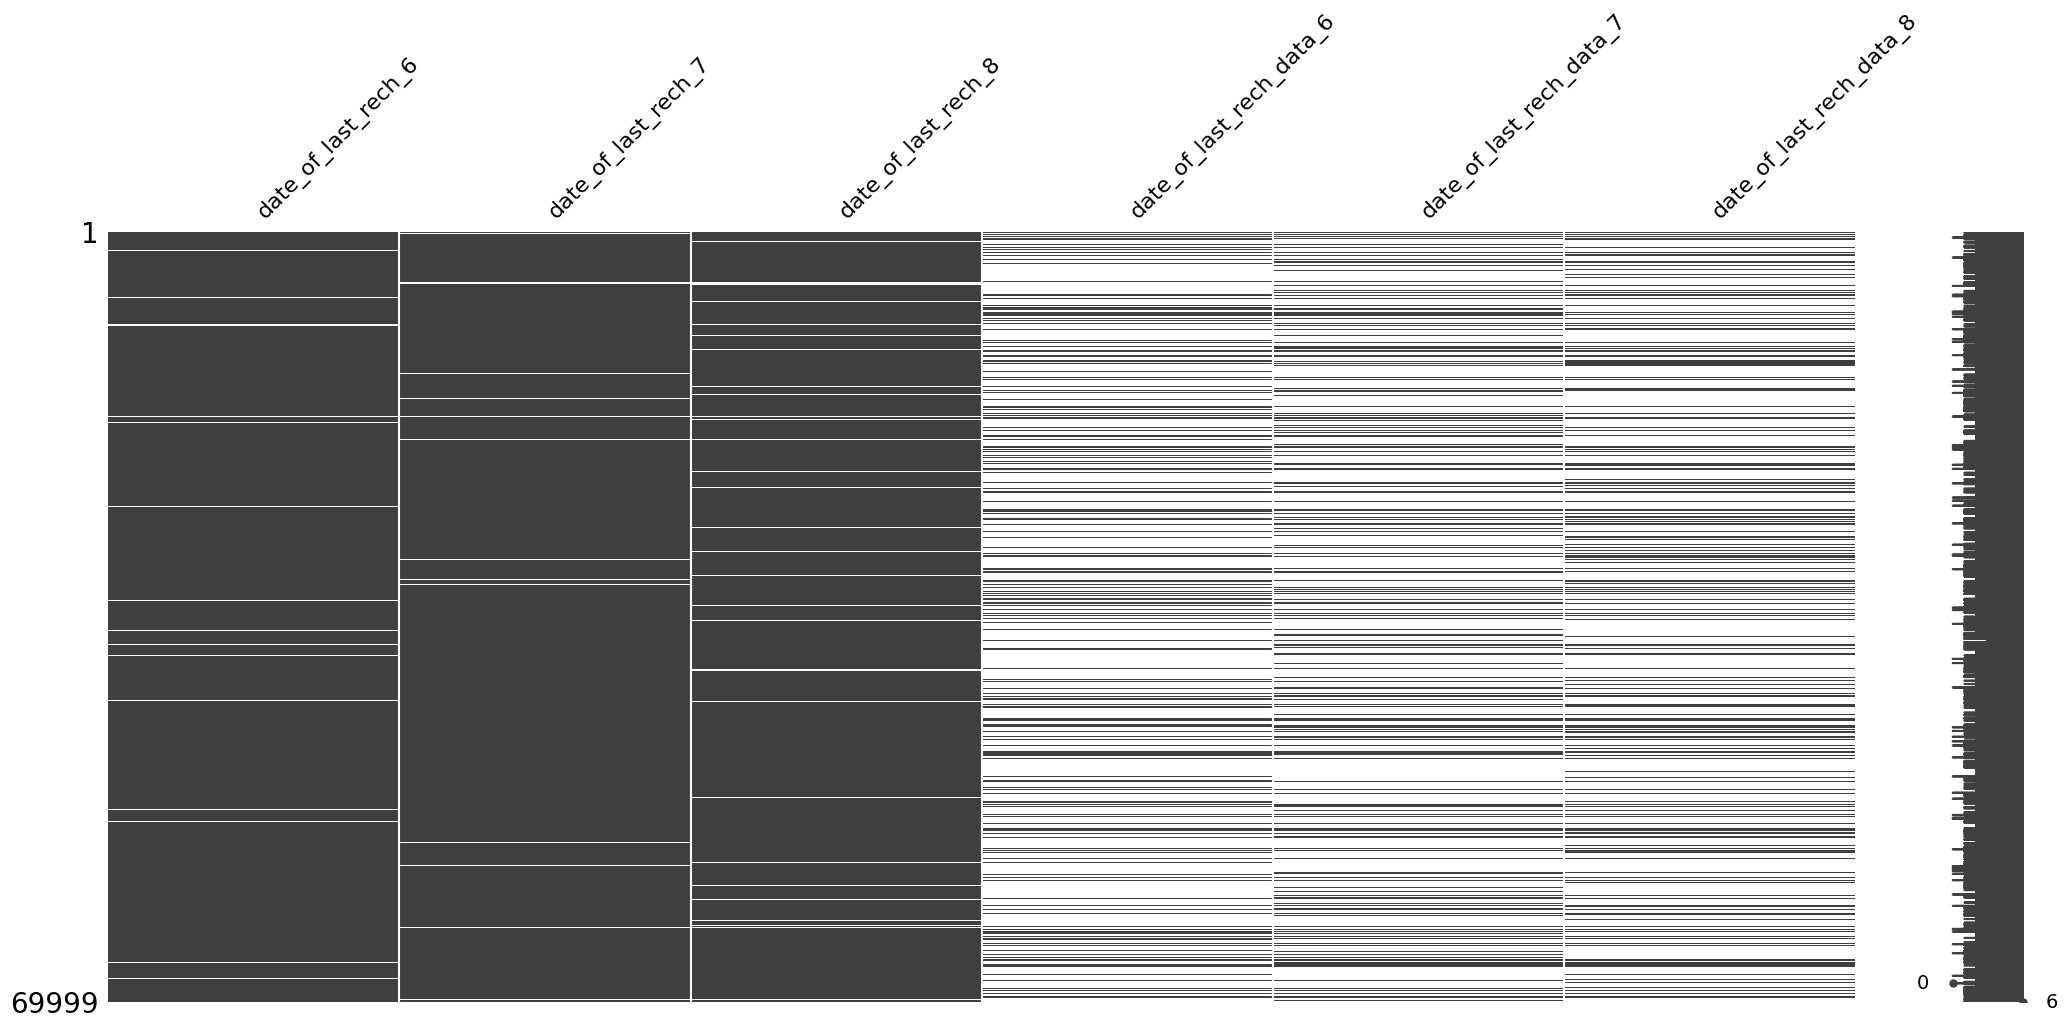

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
date = list(filter(lambda x: re.search("date", x), xCols))
msno.heatmap(data[date])
msno.matrix(data[date])

In [ ]:
# date of last recharge and date of last data recharge are not complete match per months to replace the value of one with another one
data[["date_of_last_rech_6", "date_of_last_rech_data_6"]]

date_of_last_rech_6 date_of_last_rech_data_6
id                                                
0               6/22/2014                      NaN
1               6/12/2014                      NaN
2               6/11/2014                      NaN
3               6/15/2014                      NaN
4               6/25/2014                6/25/2014
...                   ...                      ...
69994           6/18/2014                      NaN
69995           6/28/2014                      NaN
69996           6/25/2014                      NaN
69997           6/29/2014                6/17/2014
69998           6/19/2014                6/19/2014

[69999 rows x 2 columns]

In [ ]:
countData = list(filter(lambda x: re.search("count_rech", x), xCols))
print(countData)

volData = list(filter(lambda x: re.search("arpu.+g", x), xCols))
print(volData)

dateRechData = list(filter(lambda x: re.search("date.+data", x), xCols))
print(dateRechData)

totalRechData = list(filter(lambda x: re.search("total_rech_data", x), xCols))
print(totalRechData)

maxRechData = list(filter(lambda x: re.search("max_rech_data", x), xCols))
print(maxRechData)

avAmtData = list(filter(lambda x: re.search("av_rech_amt_data", x), xCols))
print(avAmtData)

removingData = countData+ volData+ dateRechData+ totalRechData+ maxRechData+ avAmtData

data.drop(columns=removingData, inplace=True)
unseen.drop(columns=removingData, inplace=True)

['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8']
['arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']
['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']
['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8']
['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']
['av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']


Columns related to # of recharge of data, revenue per user total recharge, maximum recharge data and average amount of data per month have very large number of missing values. their missing patterns are also similar so we cant use them to replace the missing values. On the other hand they can be explained by other variables such as volume of data, volume based cost,  sachet and monthly schem. So we can remove those columns. For the date of last recharge of the data we also have the date of last recharge that is more comprehensive and have less missing values so we can drop the date of last data recharge.

In [ ]:
# find percentage of missing values in each column
percNaDf = (data.isnull().sum()/data.shape[0])*100
print(percNaDf[percNaDf>0])

# check presence of blank rows
null_mask = data.isnull().all(axis=1)
null_rows = data[null_mask]

print("\nNumber of Blank Rows:", null_rows.shape[0])

# check rows with missing values
null_mask = data.isnull().any(axis=1)
null_rows = data[null_mask]

print("Number Rows with Missing values:", null_rows.shape[0])

onnet_mou_6             3.954342
onnet_mou_7             3.838626
onnet_mou_8             5.290076
offnet_mou_6            3.954342
offnet_mou_7            3.838626
offnet_mou_8            5.290076
roam_ic_mou_6           3.954342
roam_ic_mou_7           3.838626
roam_ic_mou_8           5.290076
roam_og_mou_6           3.954342
roam_og_mou_7           3.838626
roam_og_mou_8           5.290076
loc_og_t2t_mou_6        3.954342
loc_og_t2t_mou_7        3.838626
loc_og_t2t_mou_8        5.290076
loc_og_t2m_mou_6        3.954342
loc_og_t2m_mou_7        3.838626
loc_og_t2m_mou_8        5.290076
loc_og_t2f_mou_6        3.954342
loc_og_t2f_mou_7        3.838626
loc_og_t2f_mou_8        5.290076
loc_og_t2c_mou_6        3.954342
loc_og_t2c_mou_7        3.838626
loc_og_t2c_mou_8        5.290076
loc_og_mou_6            3.954342
loc_og_mou_7            3.838626
loc_og_mou_8            5.290076
std_og_t2t_mou_6        3.954342
std_og_t2t_mou_7        3.838626
std_og_t2t_mou_8        5.290076
std_og_t2m

still columns like prepaid scheme during specific night and facebook and social media available services have lots of missing values. Will look to see hwo are the variation in these columns

In [ ]:
facebook = list(filter(lambda x: re.search("fb", x), xCols))
print(facebook)

nightPck = list(filter(lambda x: re.search("night_pck", x), xCols))
print(nightPck)

print()
for c in facebook+nightPck:
  print(c)
  print(data[c].value_counts())
  print()

['fb_user_6', 'fb_user_7', 'fb_user_8']
['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']

fb_user_6
1.0    16098
0.0     1470
Name: fb_user_6, dtype: int64

fb_user_7
1.0    16249
0.0     1616
Name: fb_user_7, dtype: int64

fb_user_8
1.0    16397
0.0     2020
Name: fb_user_8, dtype: int64

night_pck_user_6
0.0    17124
1.0      444
Name: night_pck_user_6, dtype: int64

night_pck_user_7
0.0    17435
1.0      430
Name: night_pck_user_7, dtype: int64

night_pck_user_8
0.0    18030
1.0      387
Name: night_pck_user_8, dtype: int64



these columns are categorical variables having zeros and ones. So they are very difficult to replace. Look at the general pattern in them to see if there is a way to replace them.

<Axes: >

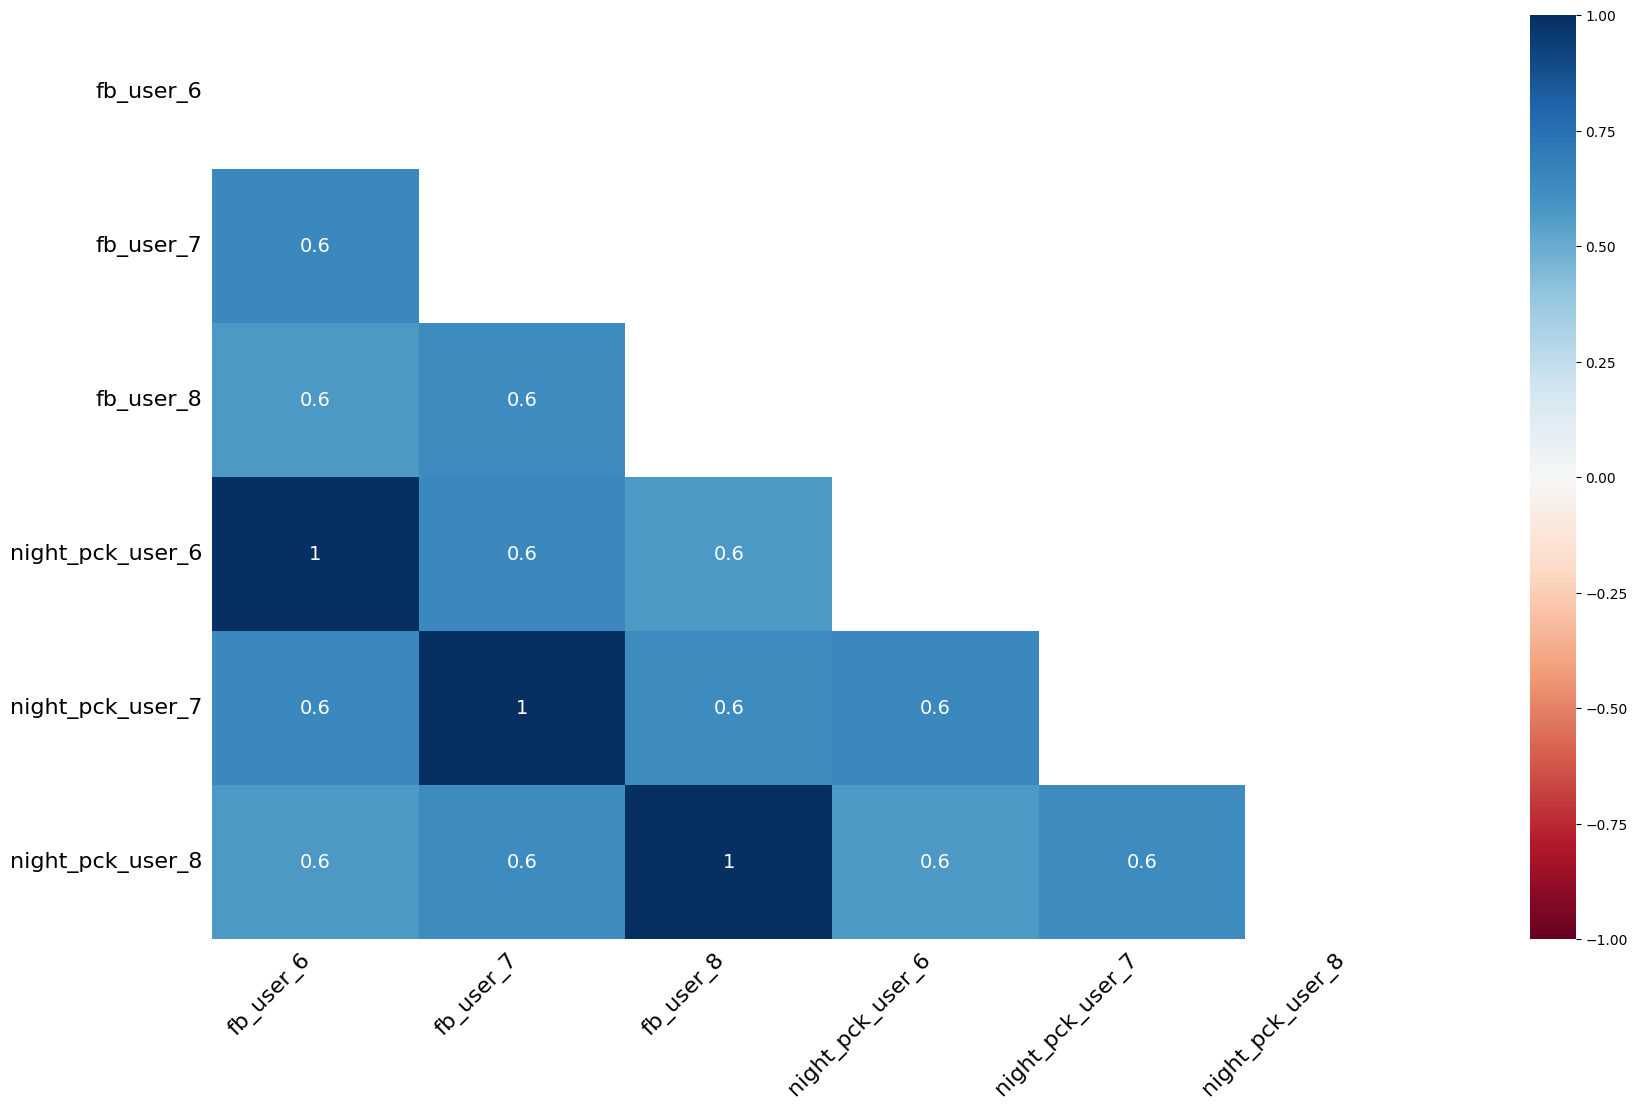

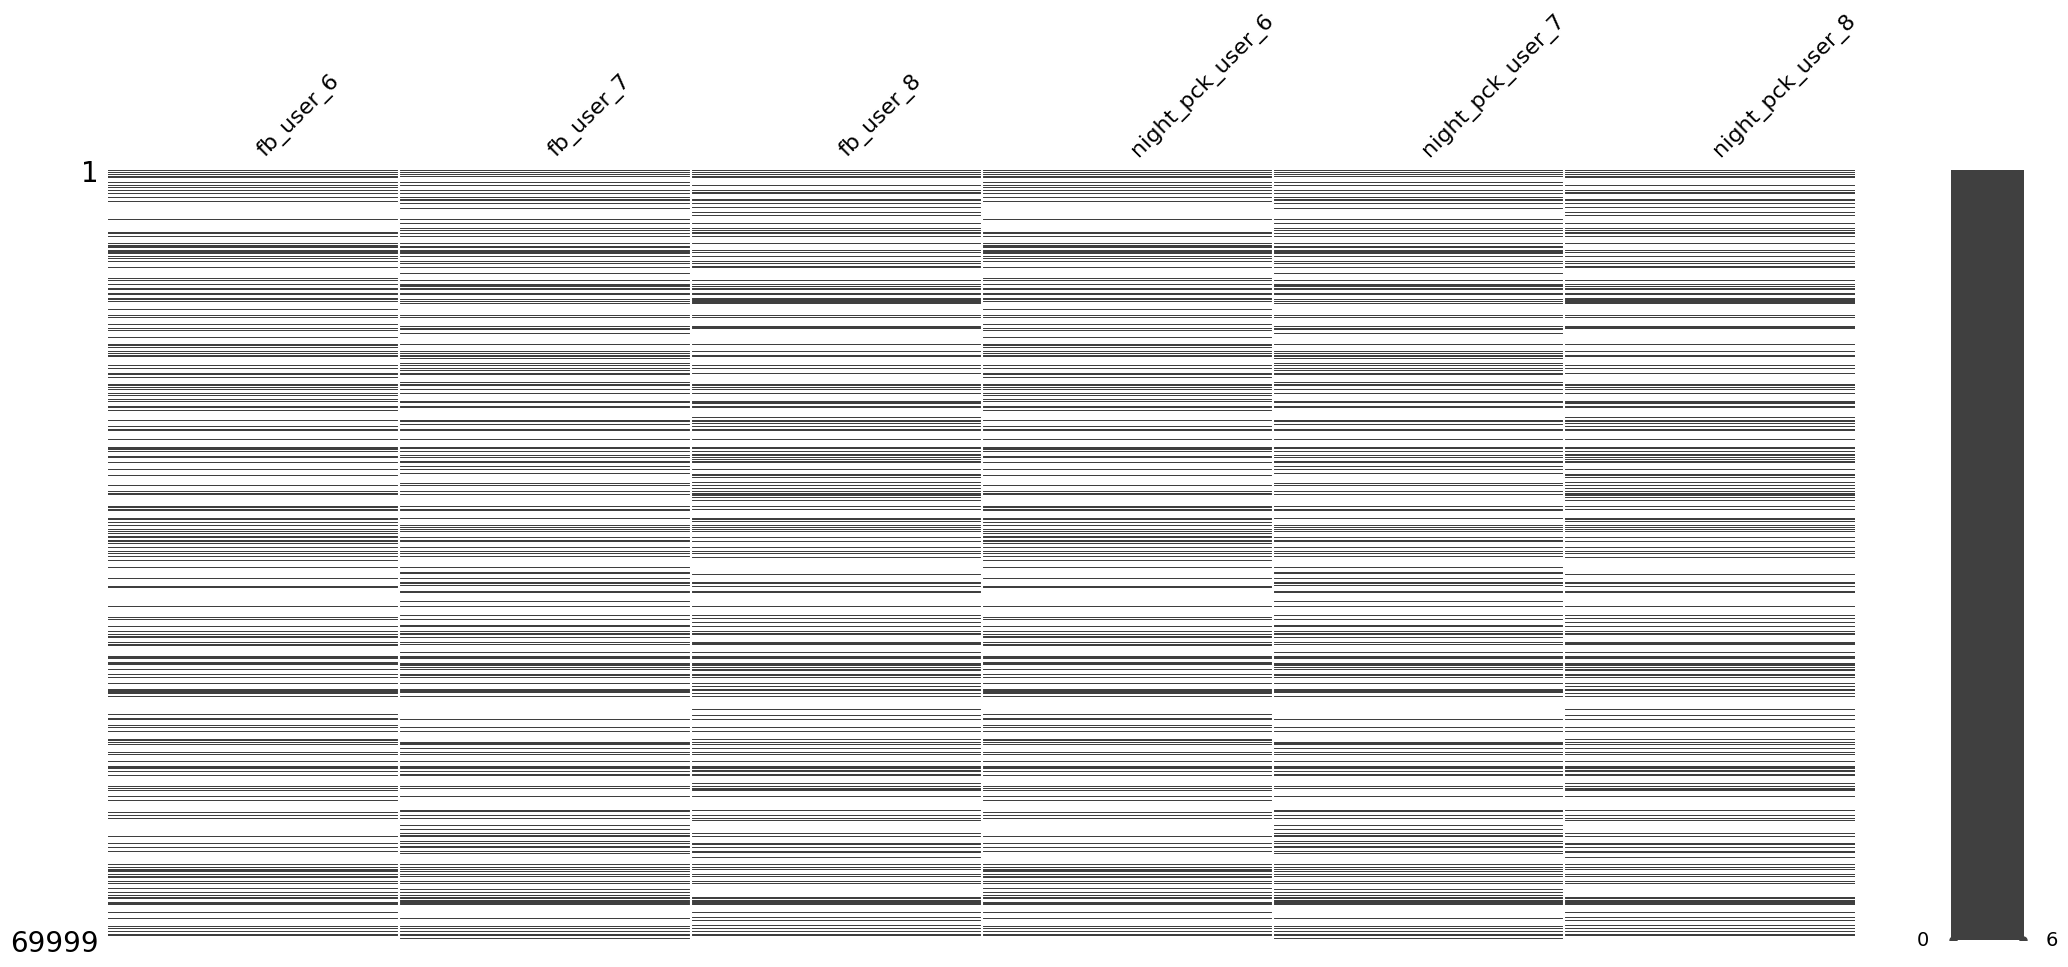

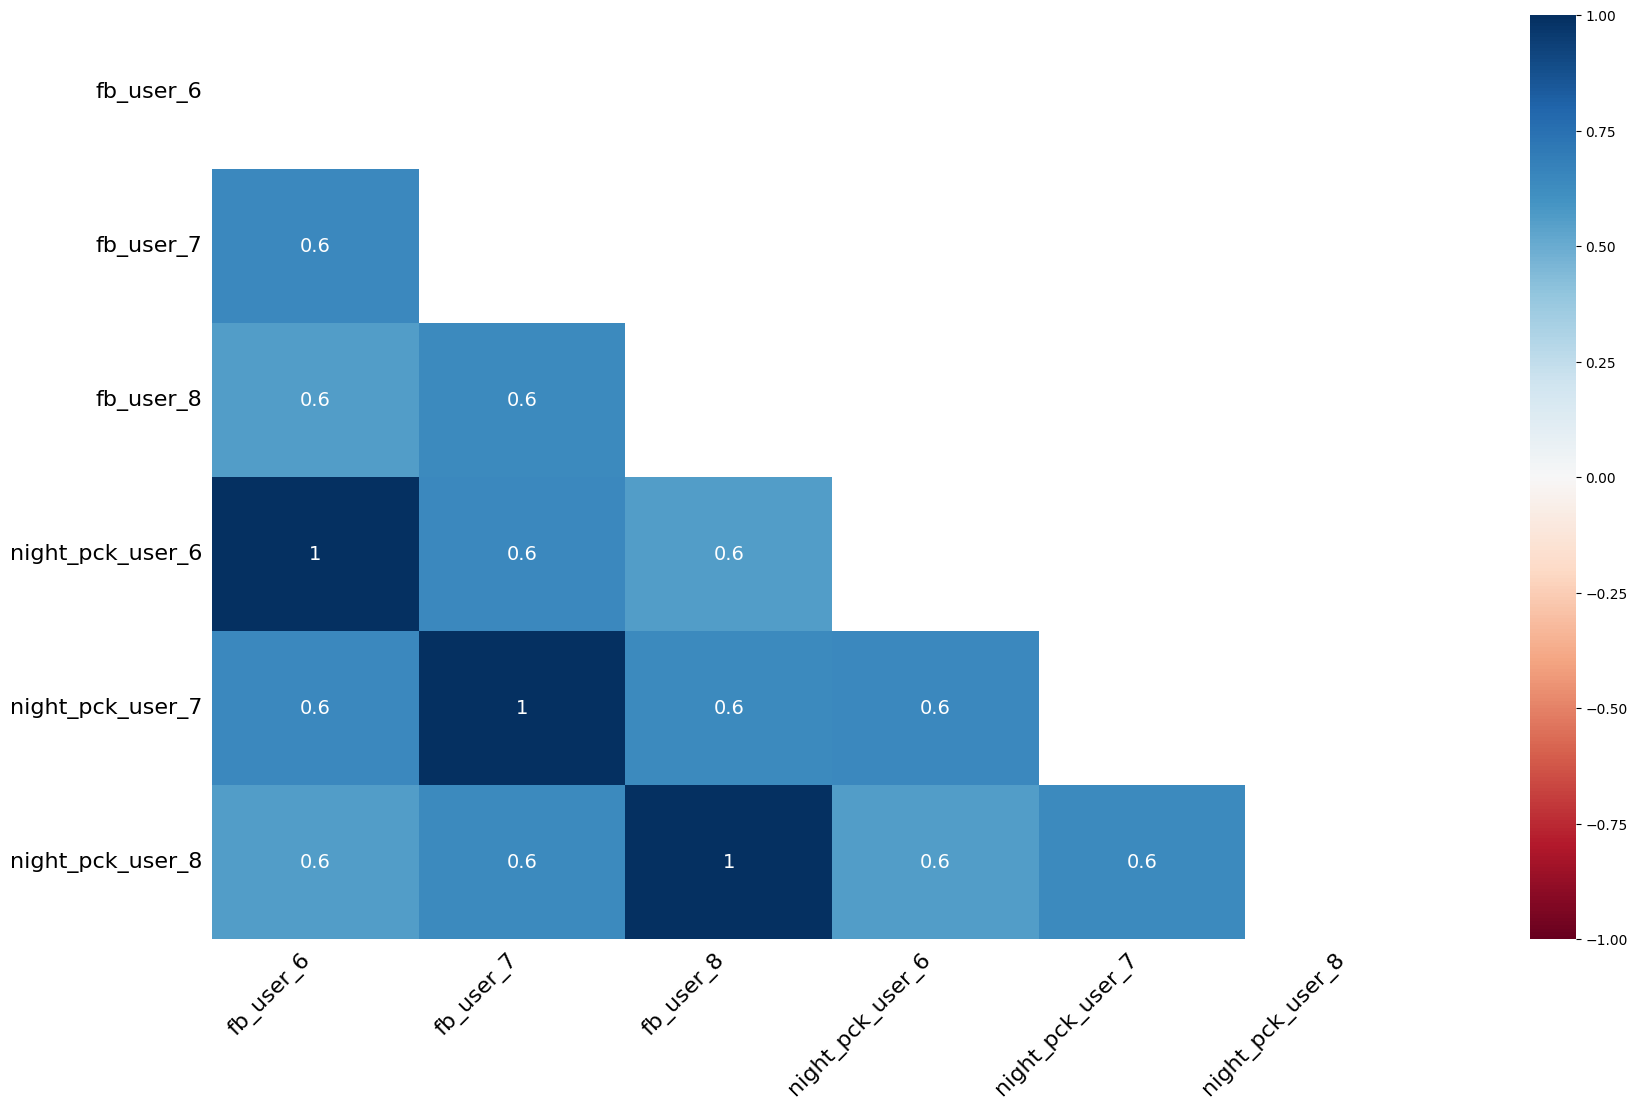

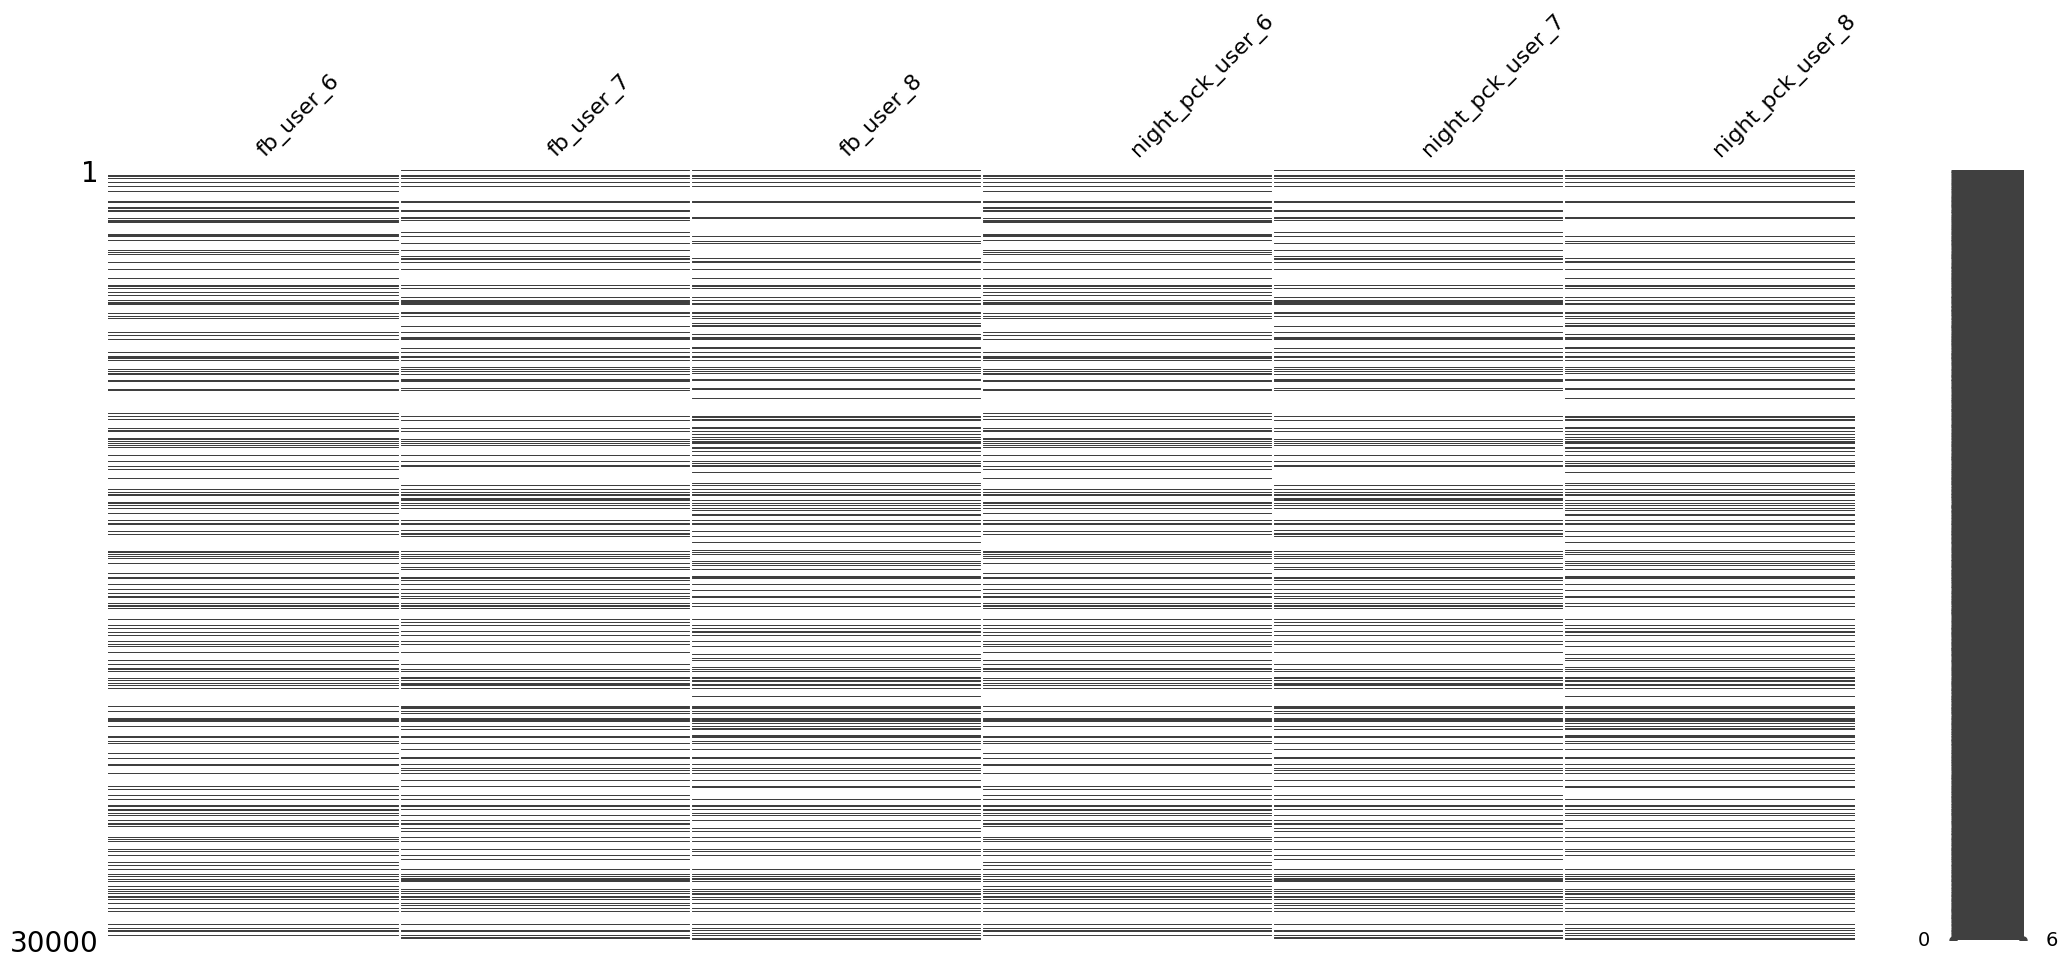

In [ ]:
msno.heatmap(data[facebook+nightPck])
msno.matrix(data[facebook+nightPck])
msno.heatmap(unseen[facebook+nightPck])
msno.matrix(unseen[facebook+nightPck])

Missing pattern is exact match based on the month between each two columns of facebook usage and nightly usage. Since there is no other categorical data to get help from for these columns and as filling categorical values is very tricky I have removed these columns as well.

In [ ]:
removingCols = facebook+nightPck

data.drop(columns = removingCols, inplace=True)
unseen.drop(columns = removingCols, inplace=True)

<IPython.core.display.Javascript object>

<Axes: >

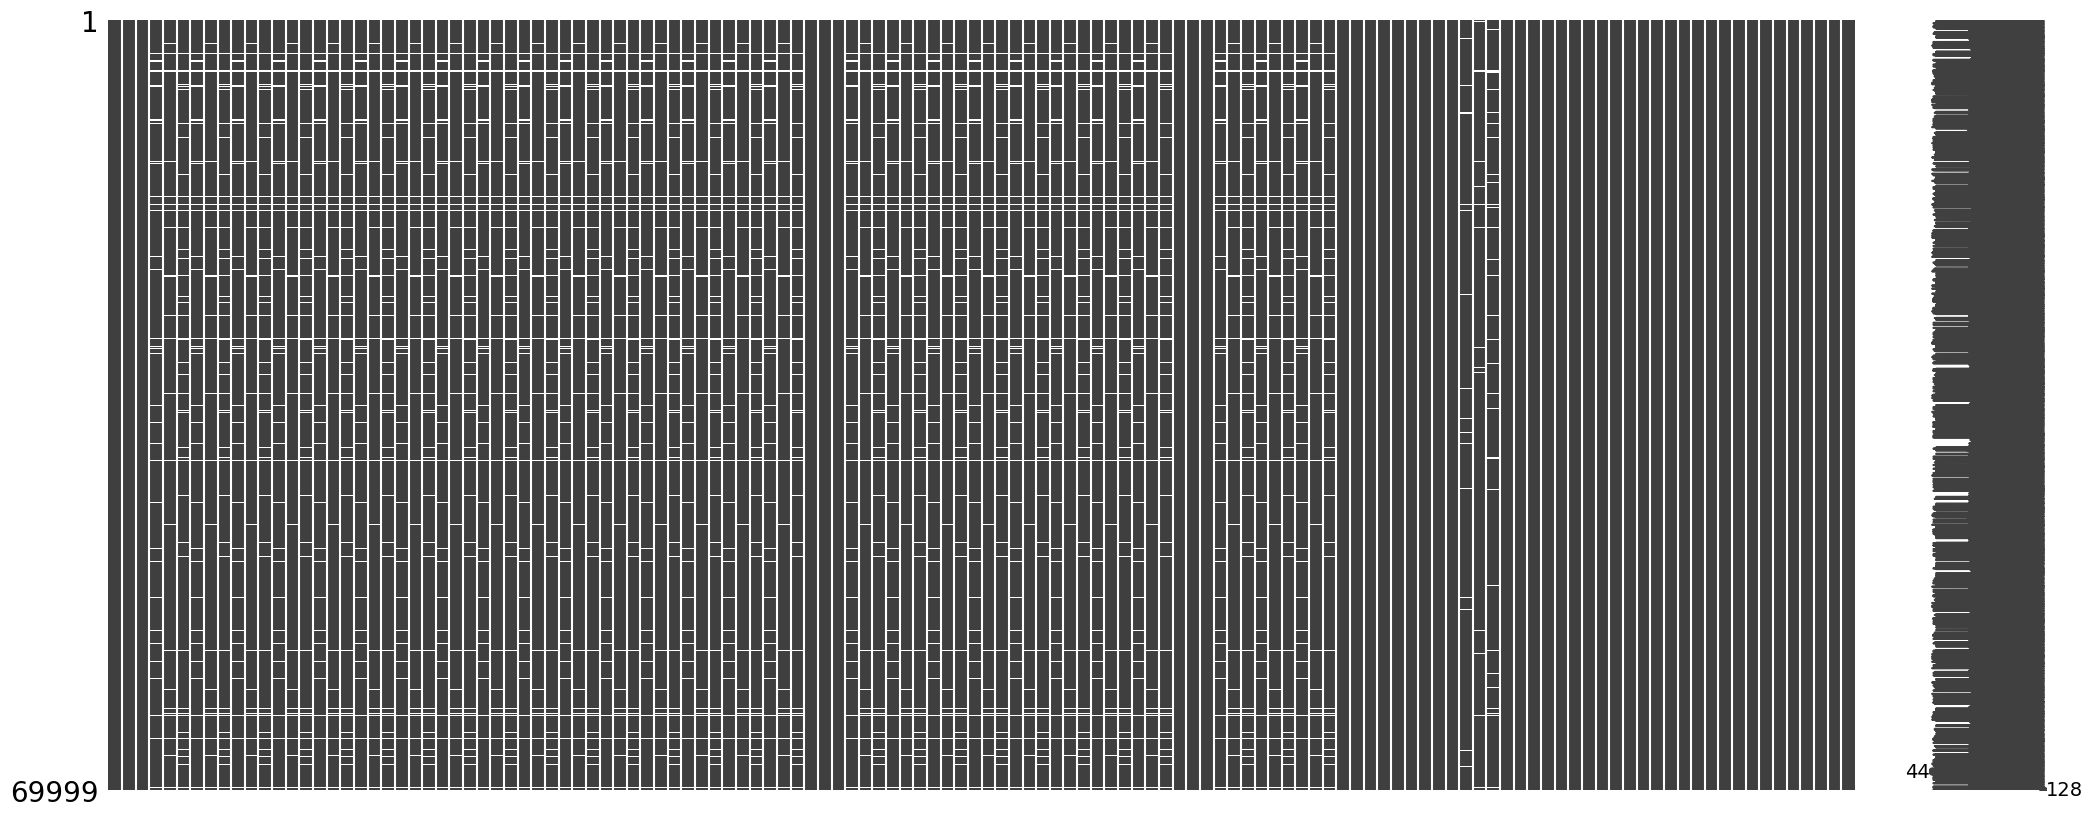

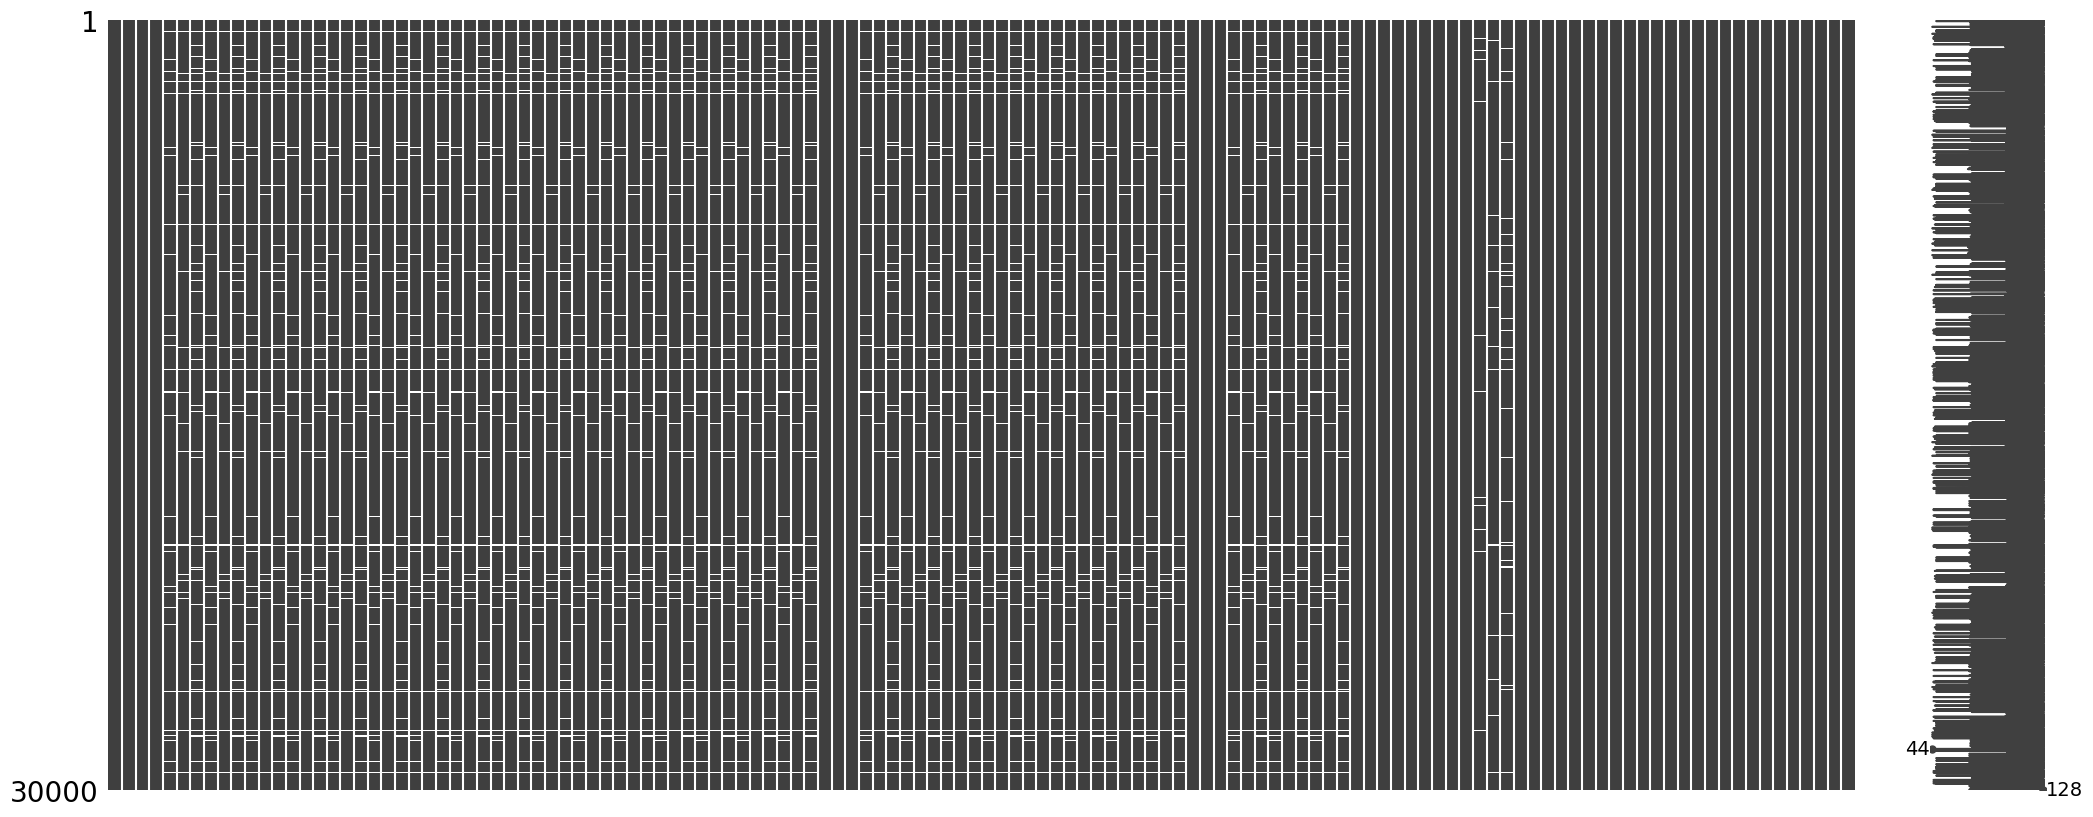

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

msno.matrix(data)
msno.matrix(unseen)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

# Identify low variant columns:
print(data.nunique().sort_values(ascending=True).head(15))

<IPython.core.display.Javascript object>

churn_probability       2
monthly_2g_6            5
monthly_2g_7            6
monthly_2g_8            6
monthly_3g_6           10
monthly_3g_8           12
monthly_3g_7           13
sachet_3g_6            23
sachet_3g_7            26
sachet_3g_8            28
date_of_last_rech_6    30
sachet_2g_6            30
date_of_last_rech_7    31
date_of_last_rech_8    31
sachet_2g_8            32
dtype: int64


There are date_of_last_rech as categorical variables and also service schems with validity equal to a month and those with validity less than a month that can be considered as categorical.

In [ ]:
# find percentage of missing values in each column
percNaDf = (data.isnull().sum()/data.shape[0])*100
print(percNaDf[percNaDf>0])

# check presence of blank rows
null_mask = data.isnull().all(axis=1)
null_rows = data[null_mask]

print("\nNumber of Blank Rows:", null_rows.shape[0])

# check rows with missing values
null_mask = data.isnull().any(axis=1)
null_rows = data[null_mask]

print("Number Rows with Missing values:", null_rows.shape[0])

onnet_mou_6            3.954342
onnet_mou_7            3.838626
onnet_mou_8            5.290076
offnet_mou_6           3.954342
offnet_mou_7           3.838626
offnet_mou_8           5.290076
roam_ic_mou_6          3.954342
roam_ic_mou_7          3.838626
roam_ic_mou_8          5.290076
roam_og_mou_6          3.954342
roam_og_mou_7          3.838626
roam_og_mou_8          5.290076
loc_og_t2t_mou_6       3.954342
loc_og_t2t_mou_7       3.838626
loc_og_t2t_mou_8       5.290076
loc_og_t2m_mou_6       3.954342
loc_og_t2m_mou_7       3.838626
loc_og_t2m_mou_8       5.290076
loc_og_t2f_mou_6       3.954342
loc_og_t2f_mou_7       3.838626
loc_og_t2f_mou_8       5.290076
loc_og_t2c_mou_6       3.954342
loc_og_t2c_mou_7       3.838626
loc_og_t2c_mou_8       5.290076
loc_og_mou_6           3.954342
loc_og_mou_7           3.838626
loc_og_mou_8           5.290076
std_og_t2t_mou_6       3.954342
std_og_t2t_mou_7       3.838626
std_og_t2t_mou_8       5.290076
std_og_t2m_mou_6       3.954342
std_og_t

In [ ]:
# Columns that do not have any missing values
data[data.columns[~data.isnull().any()]].columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
       'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g', 'churn_probability'],
      dtype='object')

variables with missing values are within 5 categories of incoming, outgoing, onnet, ofnet and date of recharge so I'll look if there is any variable that can be used to replace them.

<IPython.core.display.Javascript object>

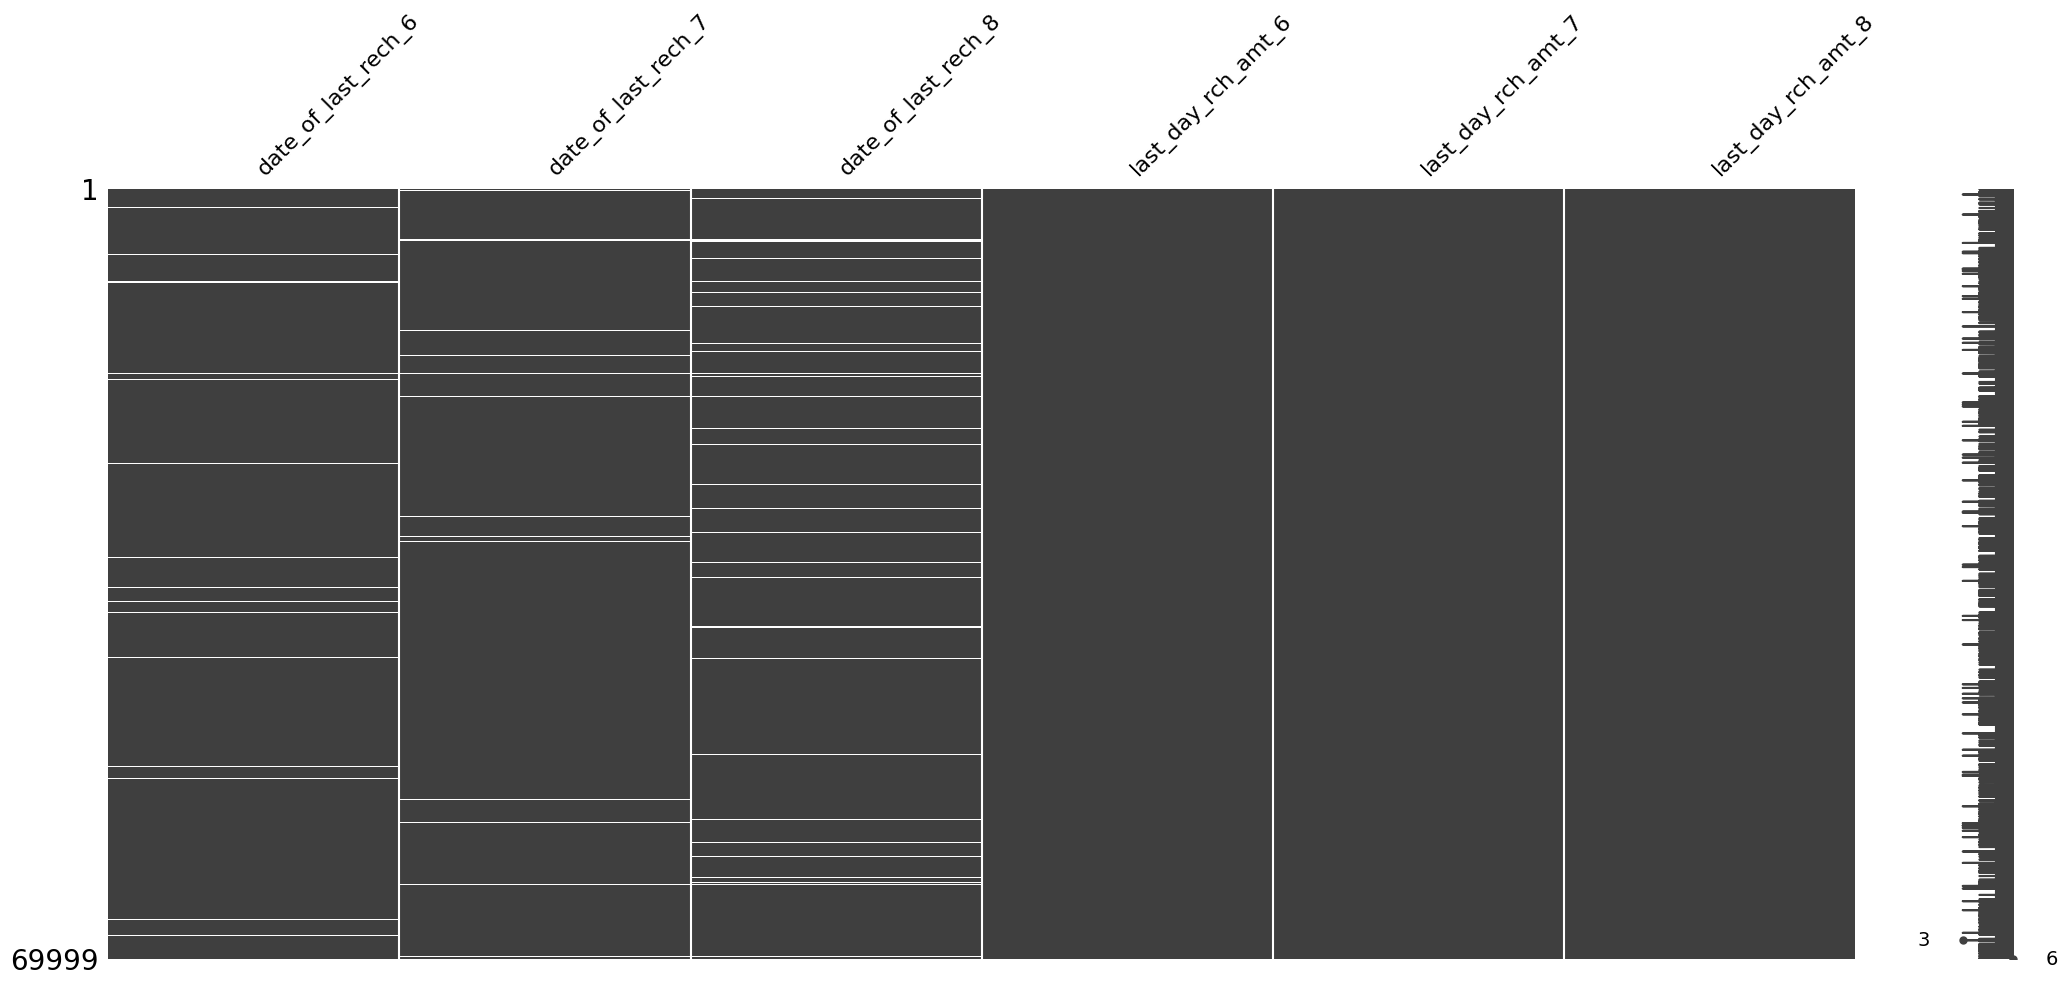

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
xCols = unseen.columns.tolist()
lastCharge = list(filter(lambda x: re.search("last", x), xCols))

msno.matrix(data[lastCharge])

data.loc[data[lastCharge].isna().any(axis=1), lastCharge]

# since there is no way to fill the value for last date recharge I would drop those columns too

lastDate = list(filter(lambda x: re.search("date_of_last", x), xCols))
lastDate

data.drop(columns=lastDate,inplace=True)
unseen.drop(columns=lastDate,inplace=True)


# **Fill missing values for incoming and out going calls**


<IPython.core.display.Javascript object>

roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  loc_ic_t2t_mou_6  \
id                                                                     
26               NaN            0.0           0.00               NaN   
31              0.00            0.0            NaN              3.08   
33               NaN            NaN           0.00               NaN   
37              2.86            NaN            NaN             19.24   
41              0.00            0.0            NaN              0.00   
...              ...            ...            ...               ...   
69942           0.00            0.0            NaN              0.00   
69956            NaN            NaN            NaN               NaN   
69962            NaN            0.0           0.00               NaN   
69978           0.00            NaN          51.84              0.00   
69988           0.85            0.0            NaN             61.44   

       loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  \
id                                                                              
26                 0.00              0.00               NaN              2.91   
31                 0.30               NaN             18.09              0.61   
33                  NaN              0.00               NaN               NaN   
37                  NaN               NaN             17.93               NaN   
41                 5.31               NaN              0.00              6.08   
...                 ...               ...               ...               ...   
69942              0.00               NaN              0.00              0.00   
69956               NaN               NaN               NaN               NaN   
69962            407.19              0.00               NaN             44.28   
69978               NaN             11.43              0.00               NaN   
69988             10.13               NaN            111.16              4.41   

       loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  \
id                                                                              
26                 6.94               NaN               0.0              1.64   
31                  NaN              1.64               0.0               NaN   
33                 0.00               NaN               NaN              0.00   
37                  NaN              0.00               NaN               NaN   
41                  NaN              0.00               0.0               NaN   
...                 ...               ...               ...               ...   
69942               NaN              0.00               0.0               NaN   
69956               NaN               NaN               NaN               NaN   
69962              0.00               NaN               0.0              0.00   
69978              5.56              0.00               NaN              0.00   
69988               NaN              0.00               0.0               NaN   

       loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  std_ic_t2t_mou_6  \
id                                                                  
26              NaN          2.91          8.59               NaN   
31            22.83          0.91           NaN             14.33   
33              NaN           NaN          0.00               NaN   
37            37.18           NaN           NaN             21.79   
41             0.00         11.39           NaN              0.00   
...             ...           ...           ...               ...   
69942          0.00          0.00           NaN              0.00   
69956           NaN           NaN           NaN               NaN   
69962           NaN        451.48          0.00               NaN   
69978          0.00           NaN         16.99              0.00   
69988        172.61         14.54           NaN              0.88   

       std_ic_t2t_mou_7  std_ic_t2t_mou_8  std_ic_t2m_mou_6  std

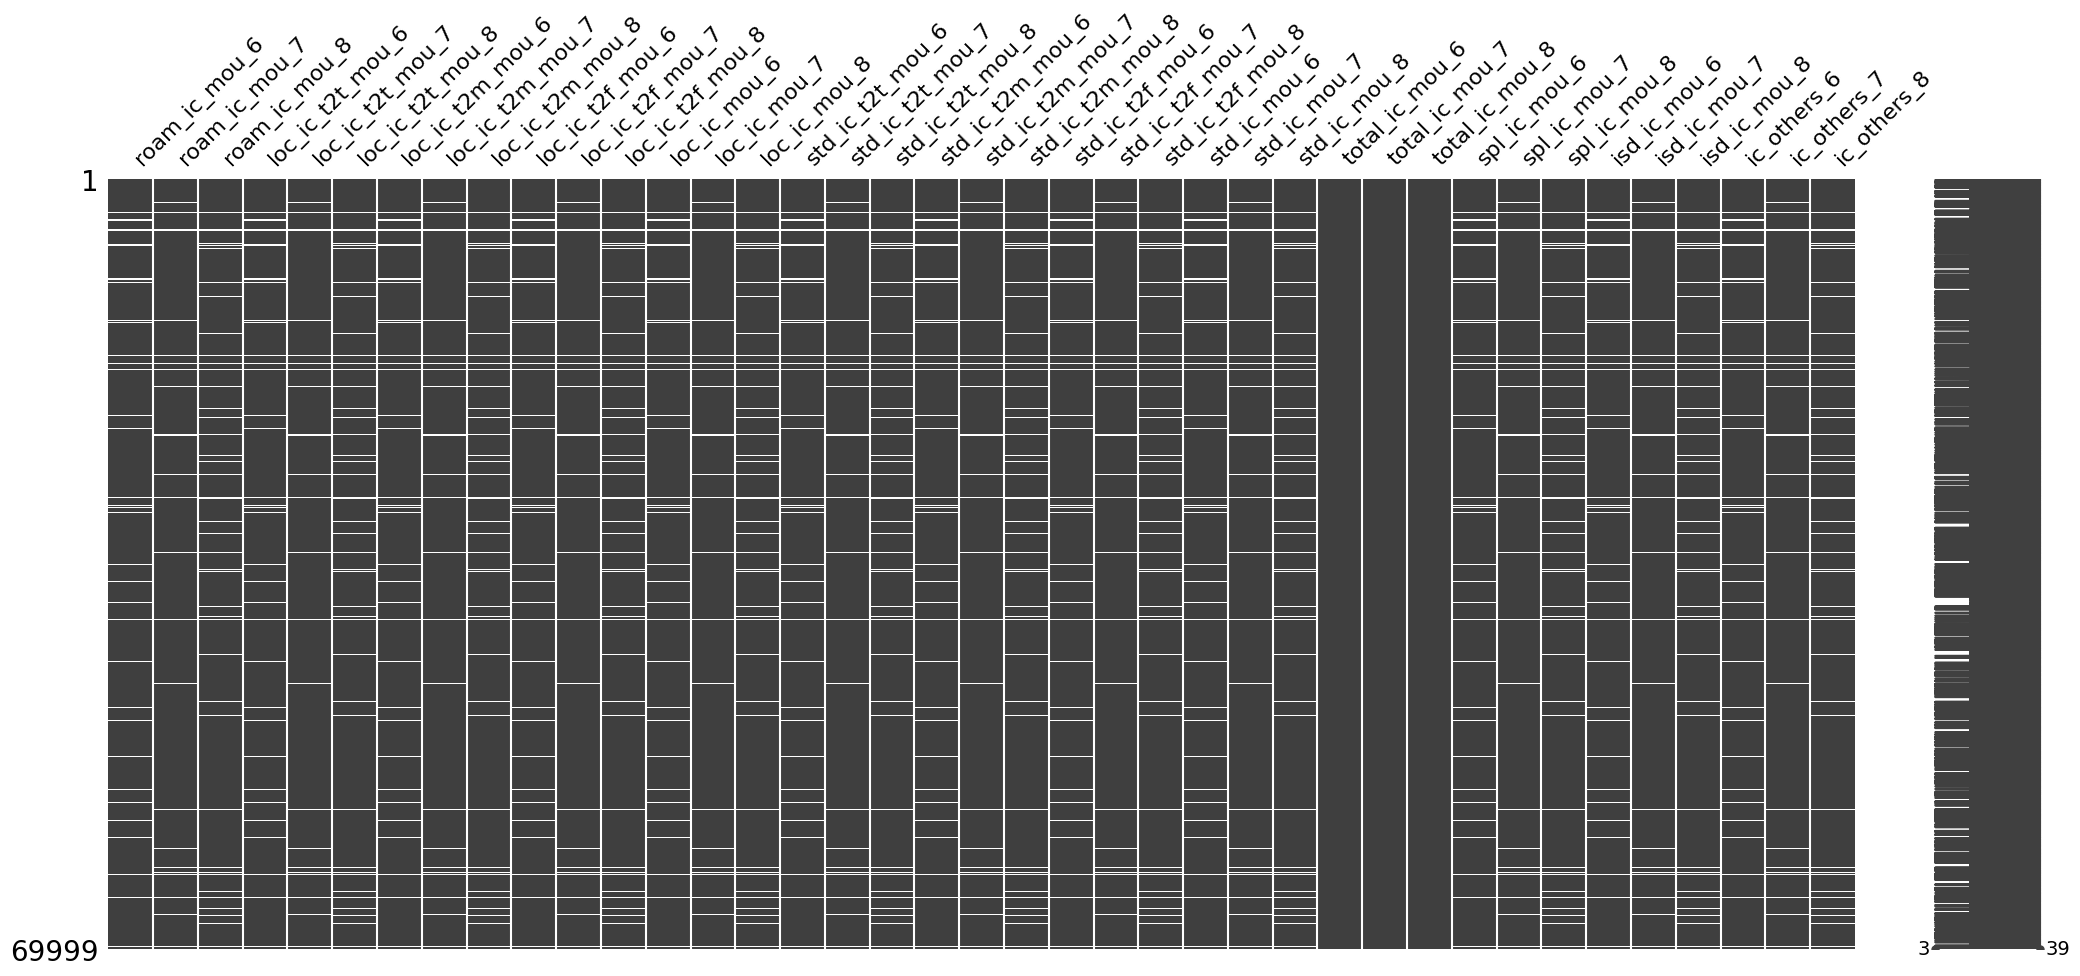

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
xCols = unseen.columns.tolist()
ic = list(filter(lambda x: re.search("ic", x), xCols))

msno.matrix(data[ic])

data.loc[data[ic].isna().any(axis=1), ic]

there are users that with the exception of total income the other records of income calls are missing. So I'll look at the value of total call for those users to see if I can some how replace those values.

<IPython.core.display.Javascript object>

0.0    2768
Name: total_ic_mou_6, dtype: int64
0.0    1169
Name: total_ic_mou_6, dtype: int64


Text(0.5, 1.0, 'Test set After filling with zero')

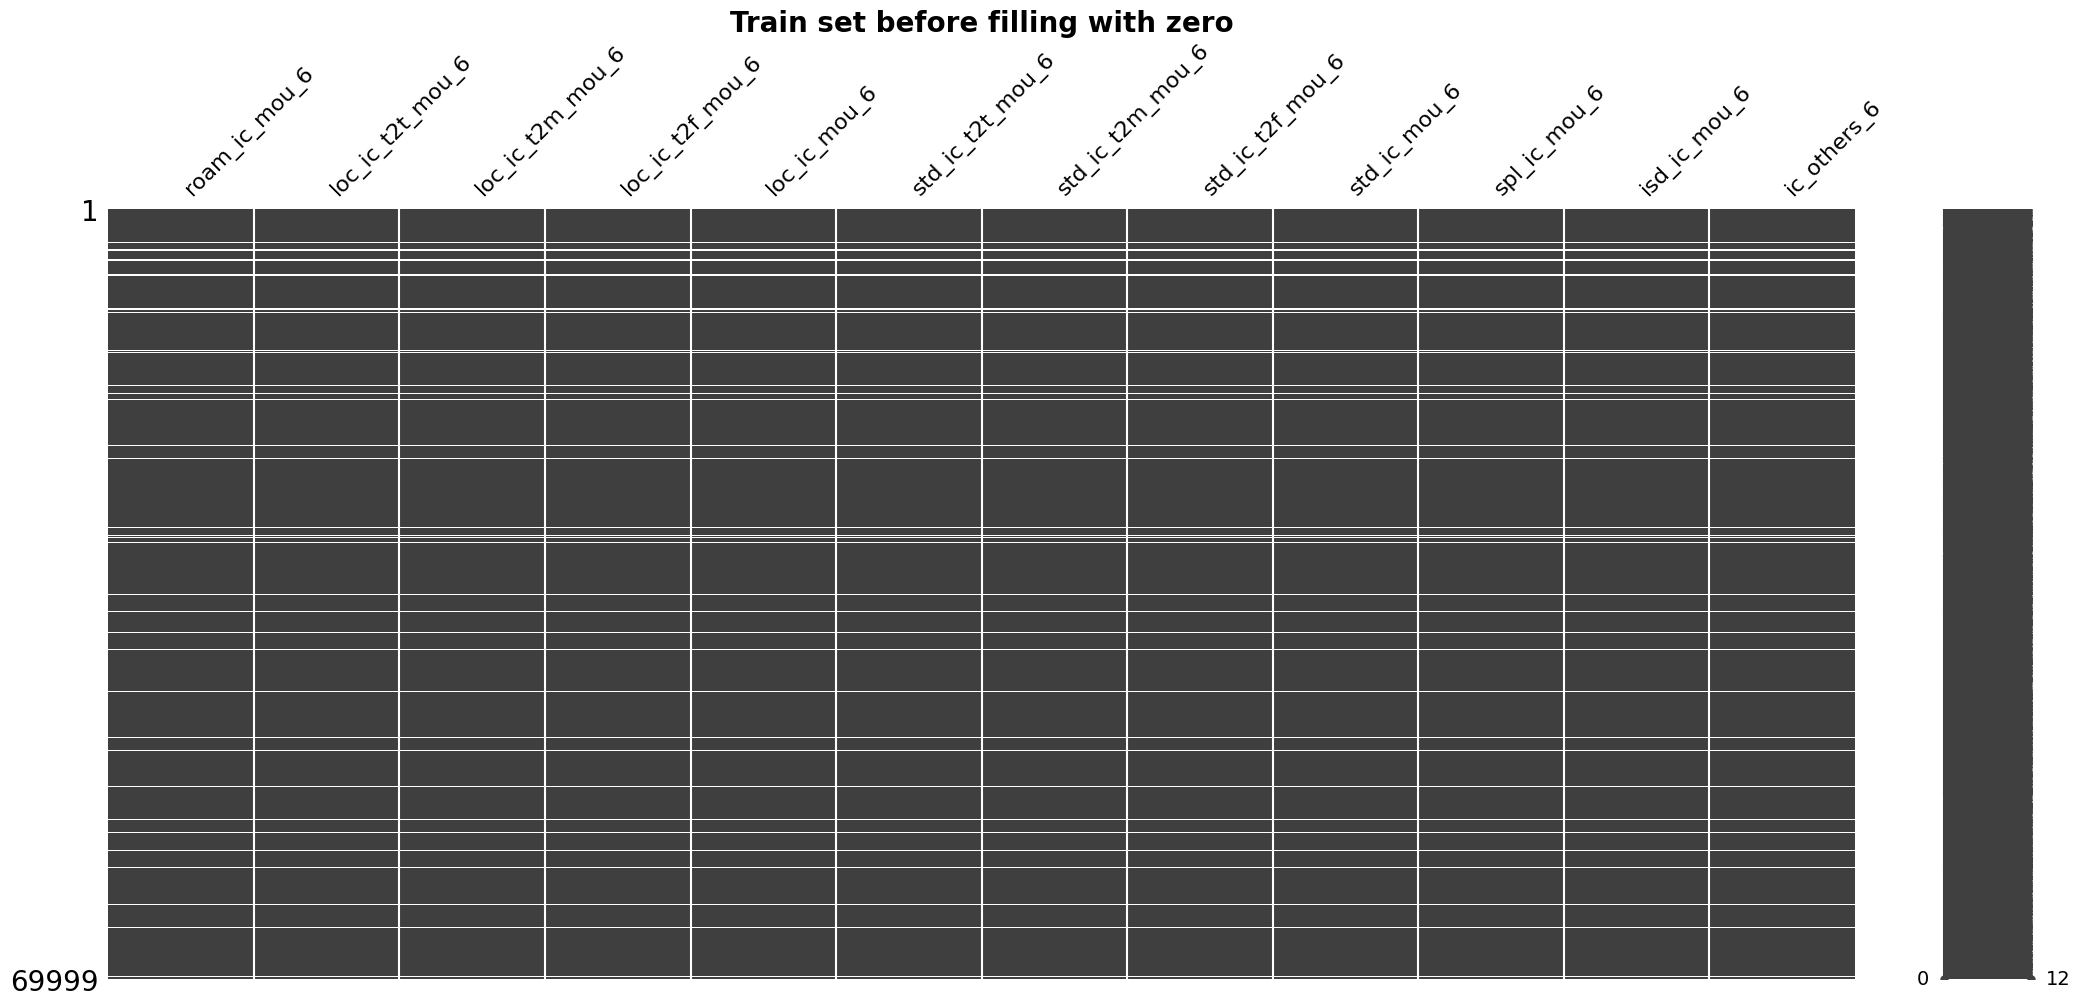

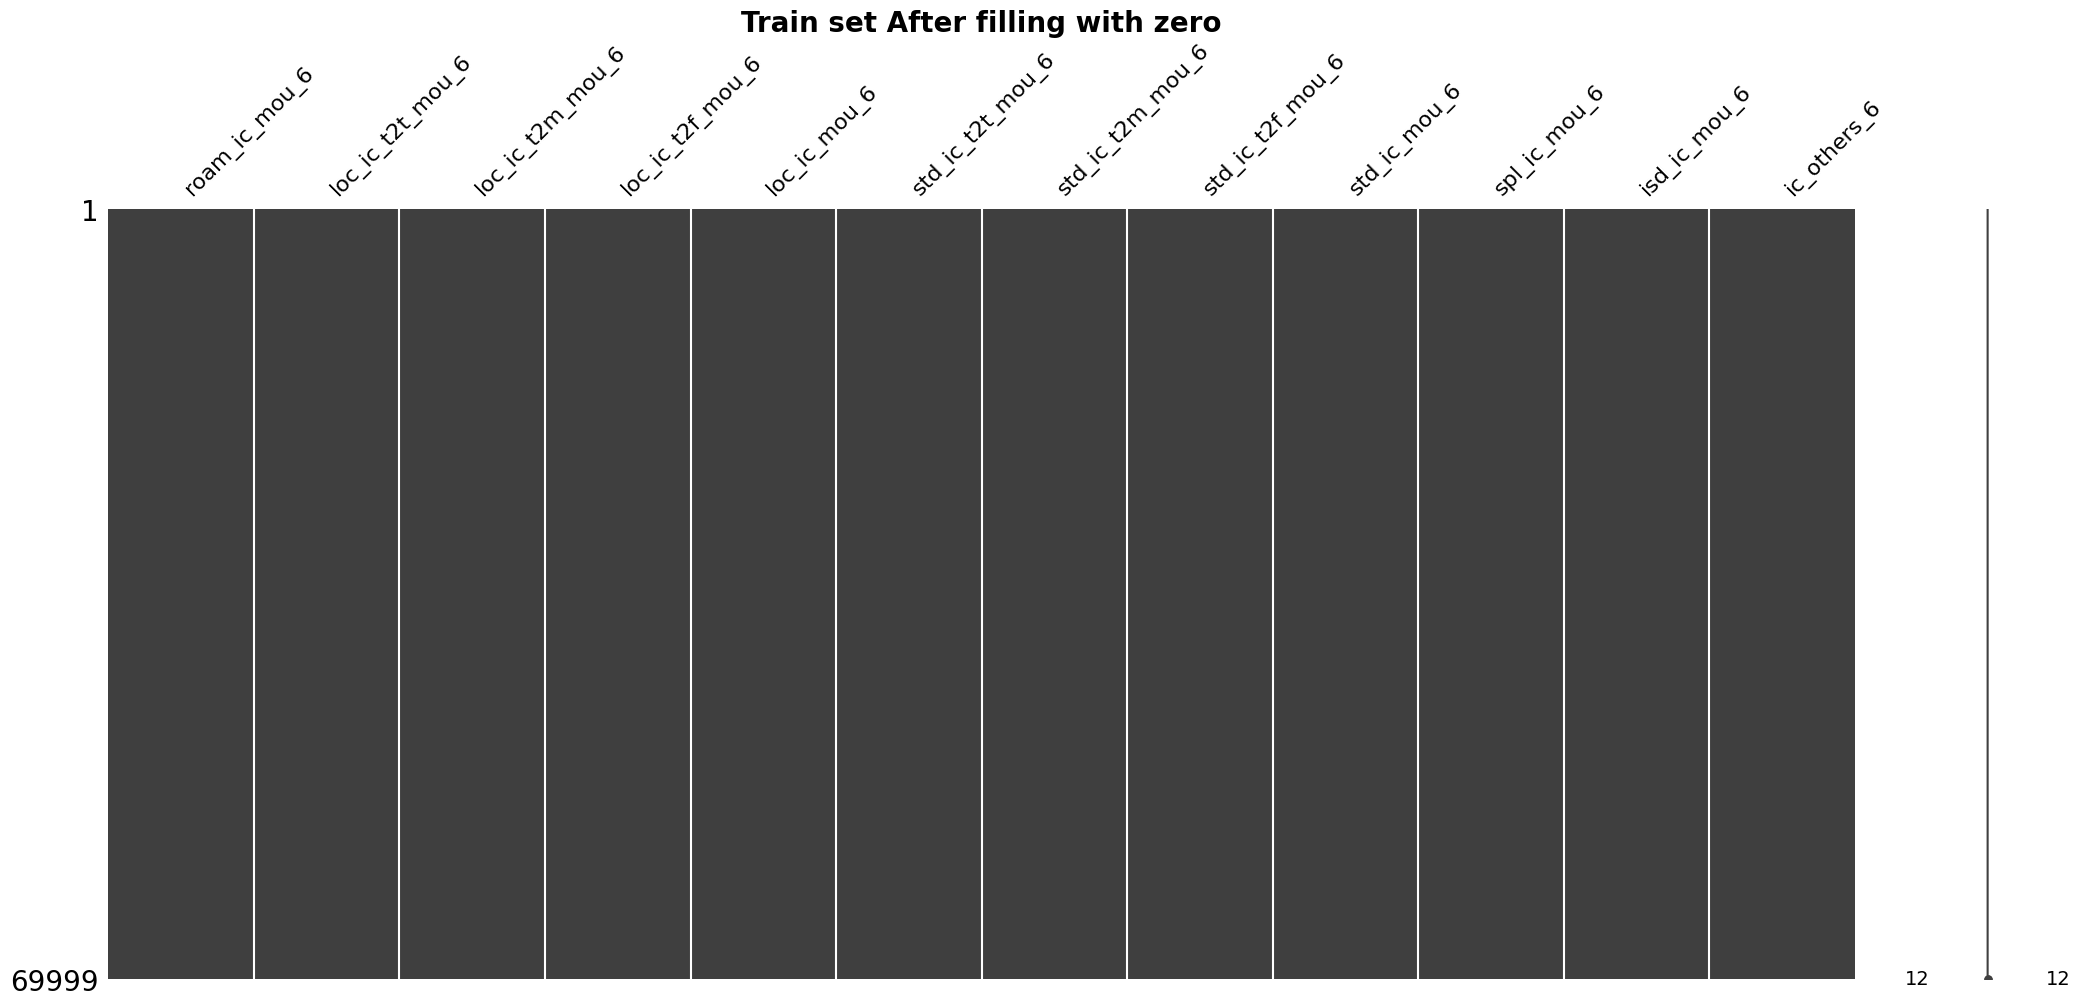

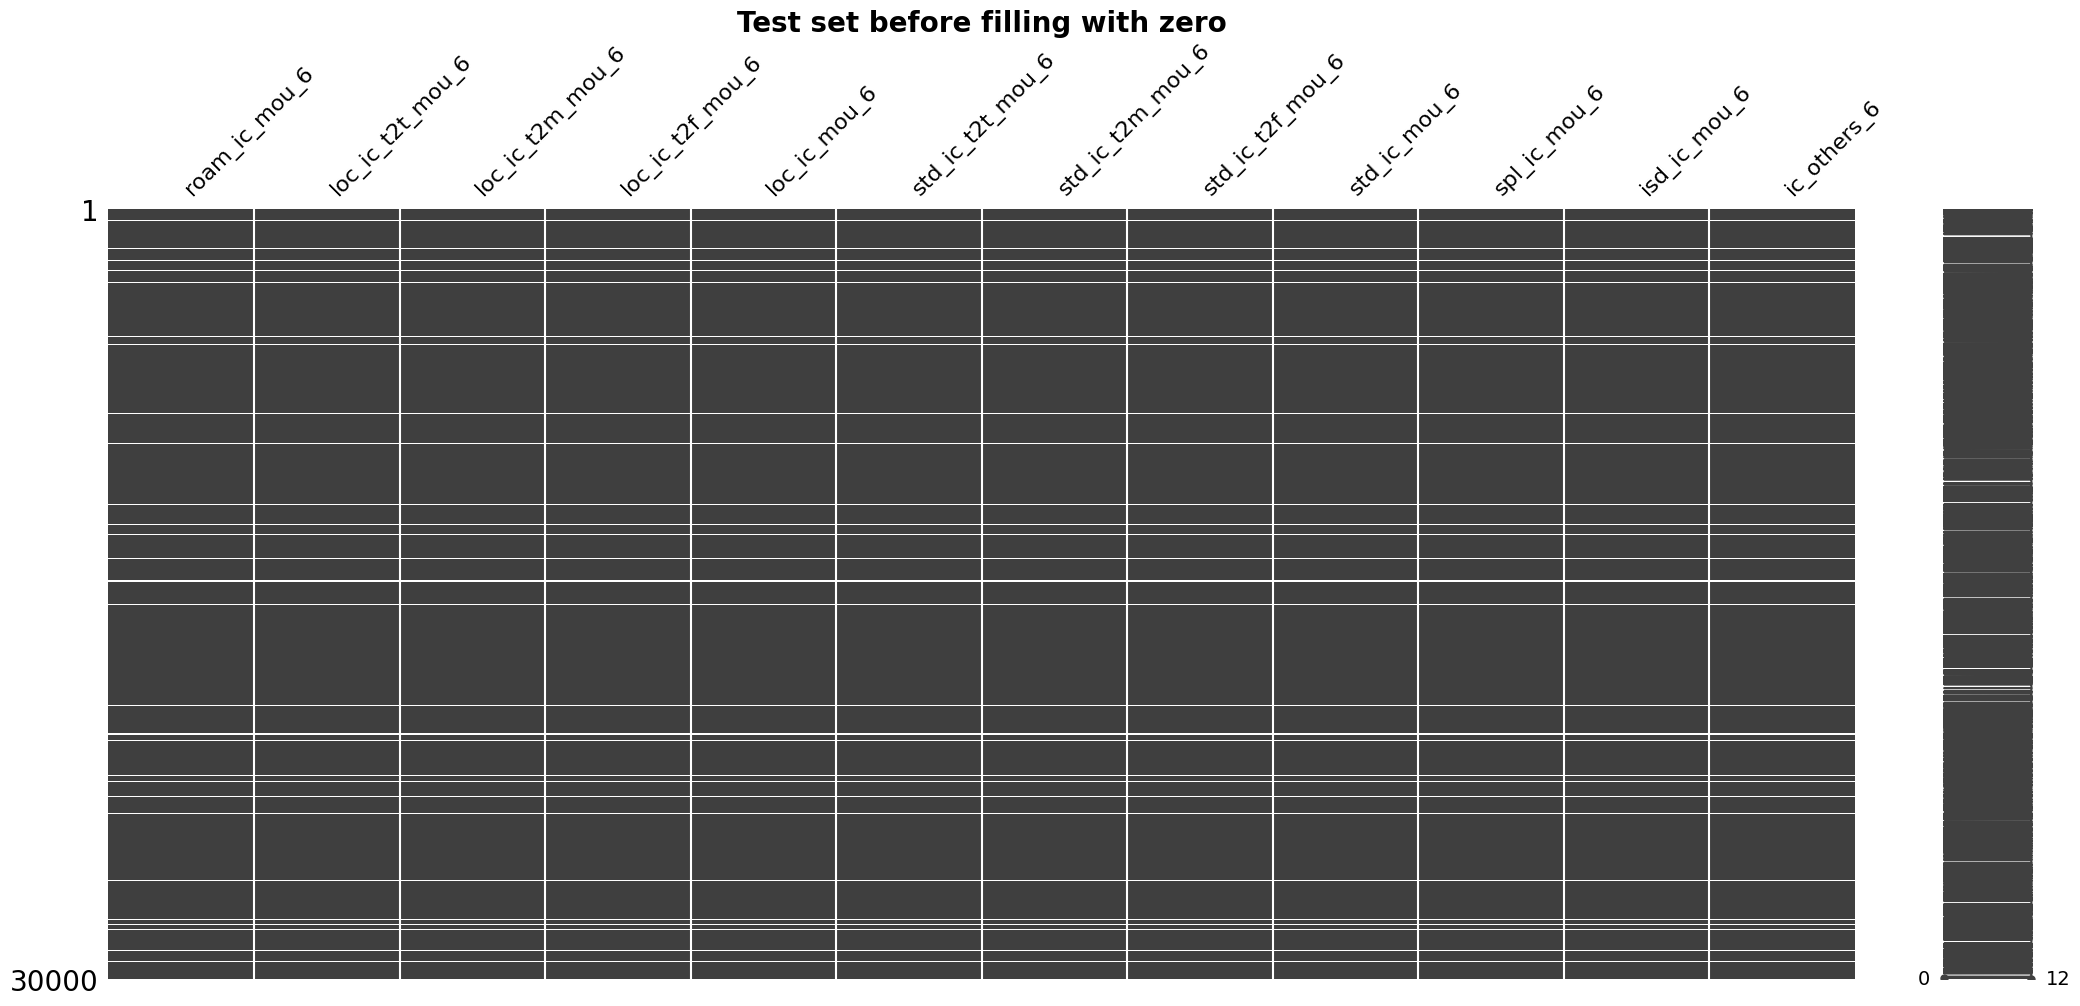

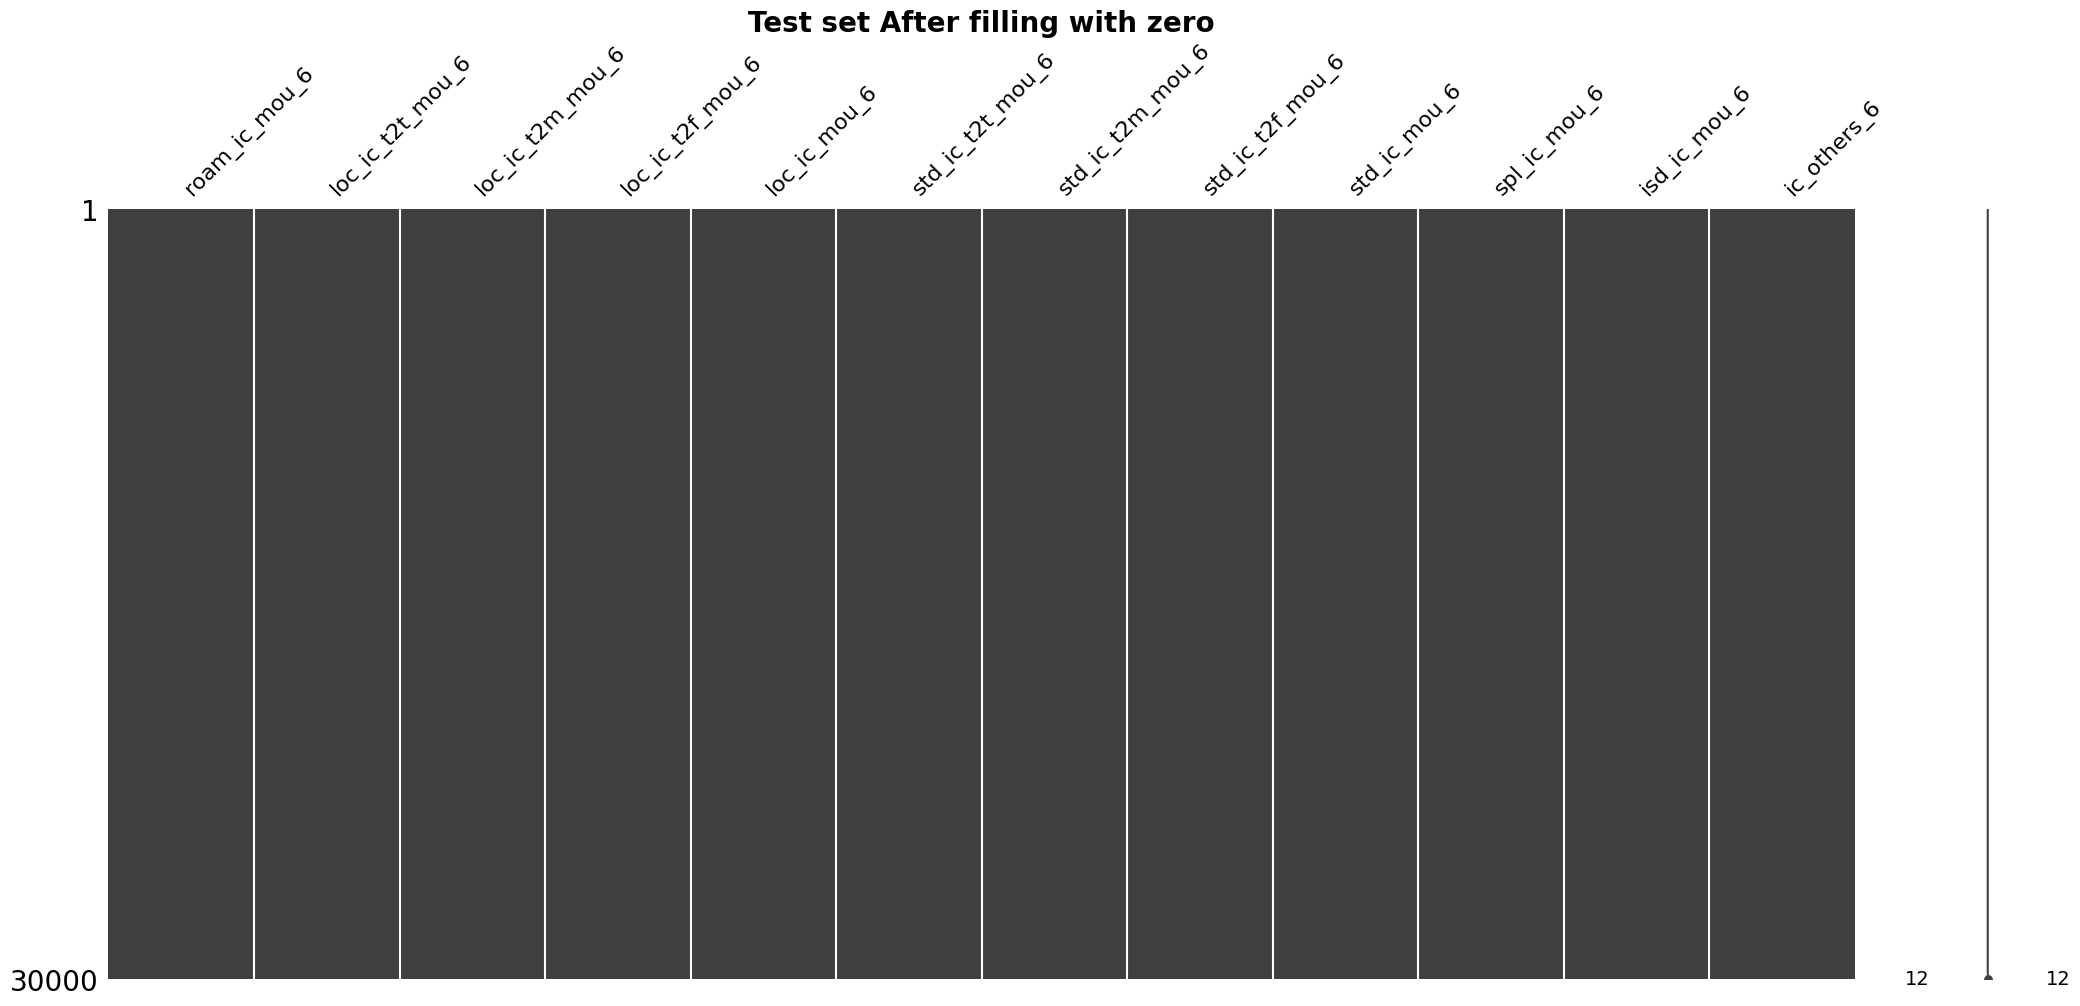

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
ic6 = list(filter(lambda x: re.search("ic.+6", x), xCols))

ic6.remove("total_ic_mou_6")
ic6

print(data.loc[data[ic6].isnull().all(1), "total_ic_mou_6"].value_counts())

# since the total minutes of income calls is zero for rows with na for all income calls we can repace them by zero.

# msno.heatmap(data)
msno.matrix(data[ic6])
plt.title("Train set before filling with zero", fontsize=20, fontweight="bold")

data.loc[data[ic6].isna().any(axis=1), ic]

idx = data.loc[data[ic6].isnull().all(1),].index
data.loc[idx, ic6] = data.loc[idx, ic6].replace(np.nan, 0)
data.loc[idx, ic6]

msno.matrix(data[ic6])
plt.title("Train set After filling with zero", fontsize=20, fontweight="bold")

# repeat same process for test set
print(unseen.loc[unseen[ic6].isnull().all(1), "total_ic_mou_6"].value_counts())

# since the total minutes of income calls is zero for rows with na for all income calls we can repace them by zero.

msno.matrix(unseen[ic6])

unseen.loc[unseen[ic6].isna().any(axis=1), ic]
plt.title("Test set before filling with zero", fontsize=20, fontweight="bold")

idx = unseen.loc[unseen[ic6].isnull().all(1),].index
unseen.loc[idx, ic6] = unseen.loc[idx, ic6].replace(np.nan, 0)
unseen.loc[idx, ic6]

msno.matrix(unseen[ic6])
plt.title("Test set After filling with zero", fontsize=20, fontweight="bold")

Same rules apply to july and agust for both incoming and outgoing variables so they were treated the same way. Both train and test set are going trough this process

<IPython.core.display.Javascript object>

0.0    2687
Name: total_ic_mou_7, dtype: int64
0.0    3703
Name: total_ic_mou_8, dtype: int64
0.0    2768
Name: total_og_mou_6, dtype: int64
0.0    2687
Name: total_og_mou_7, dtype: int64
0.0    3703
Name: total_og_mou_8, dtype: int64


Text(0.5, 1.0, 'Test set After Treating missing values')

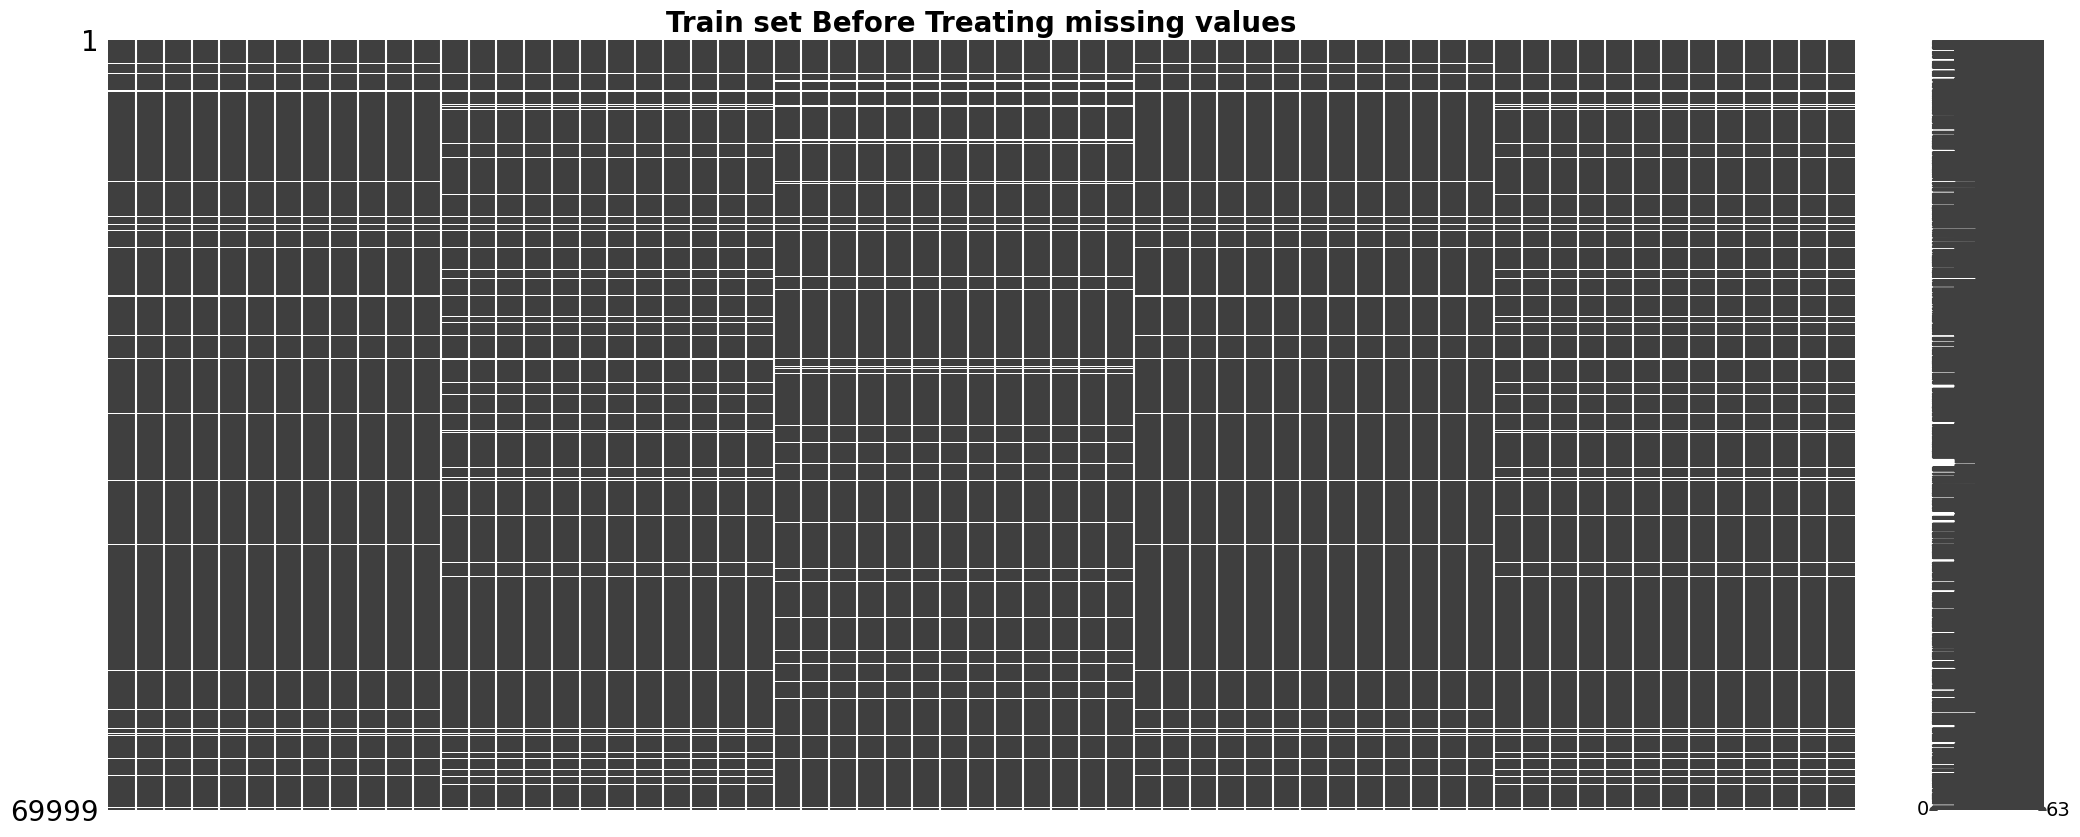

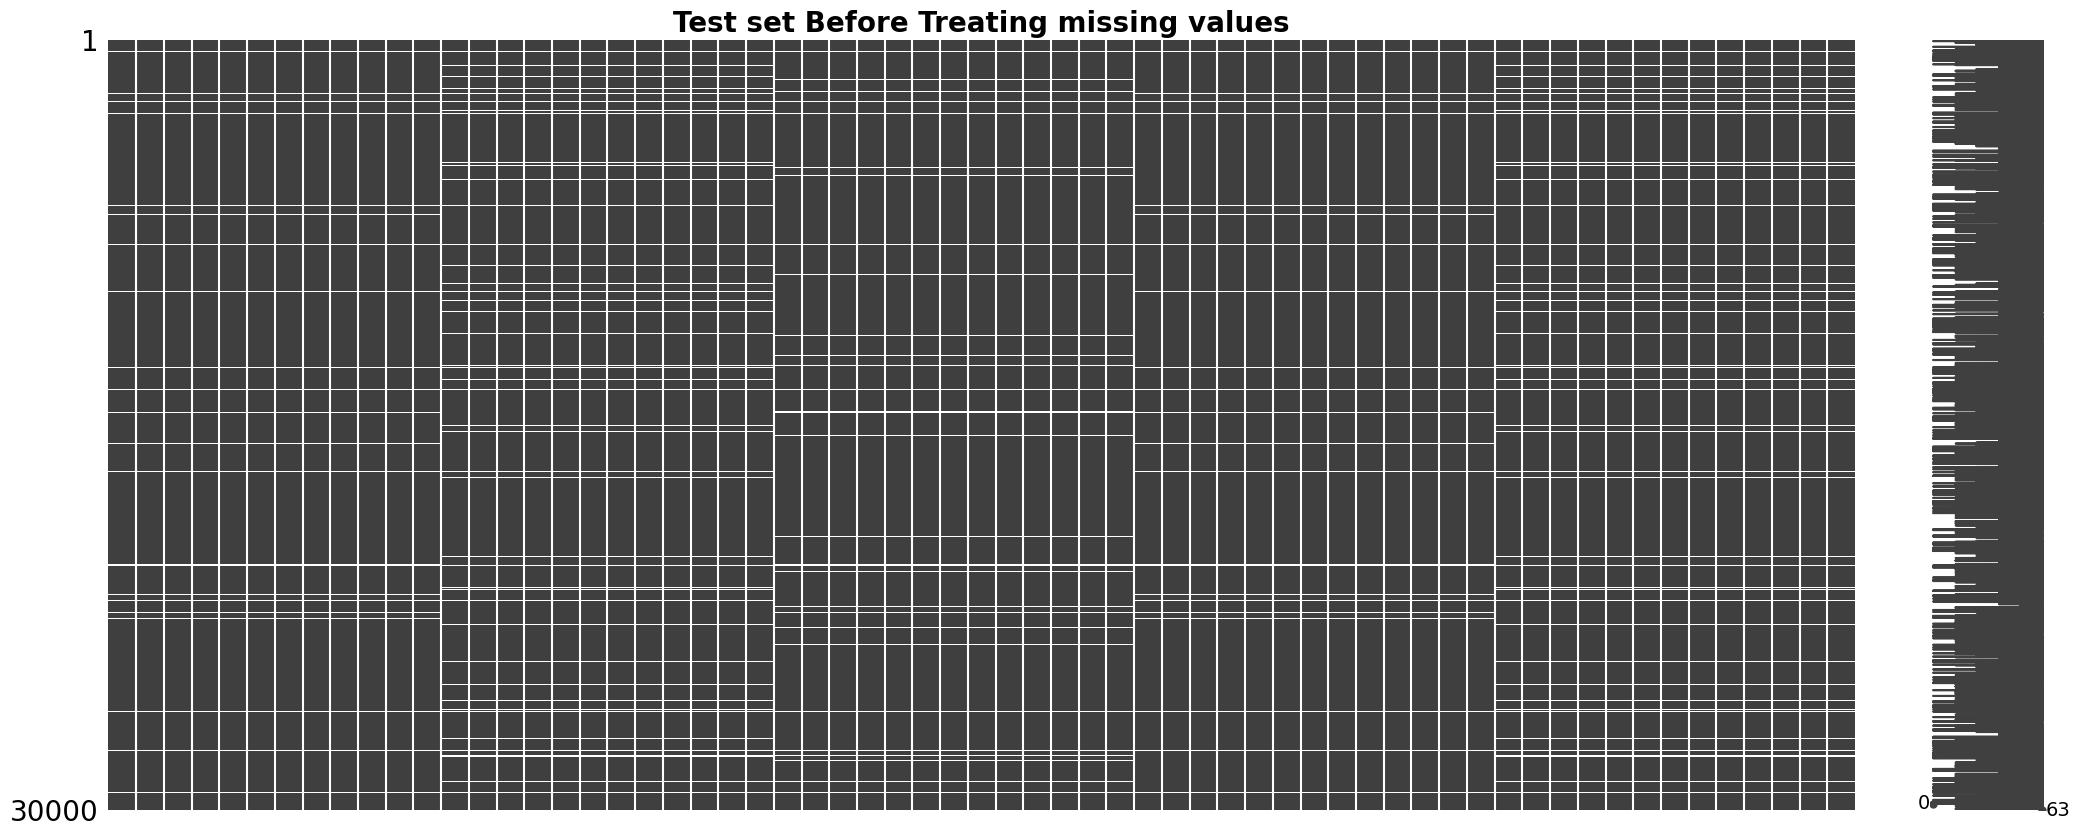

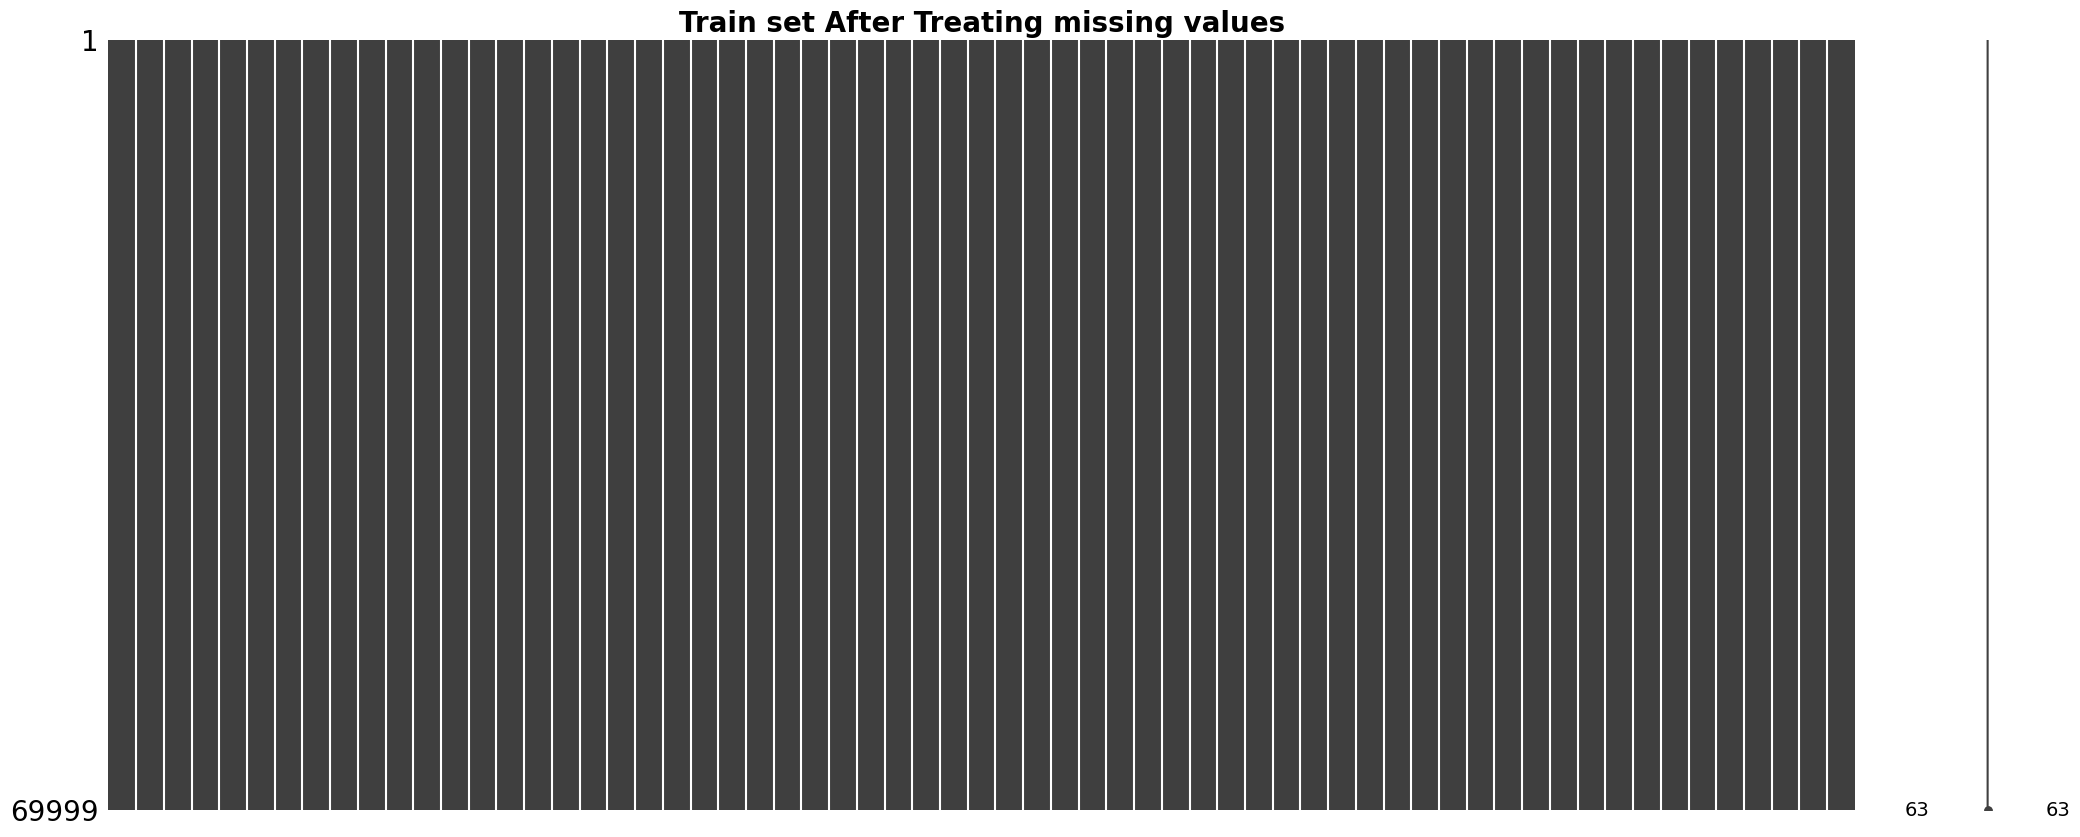

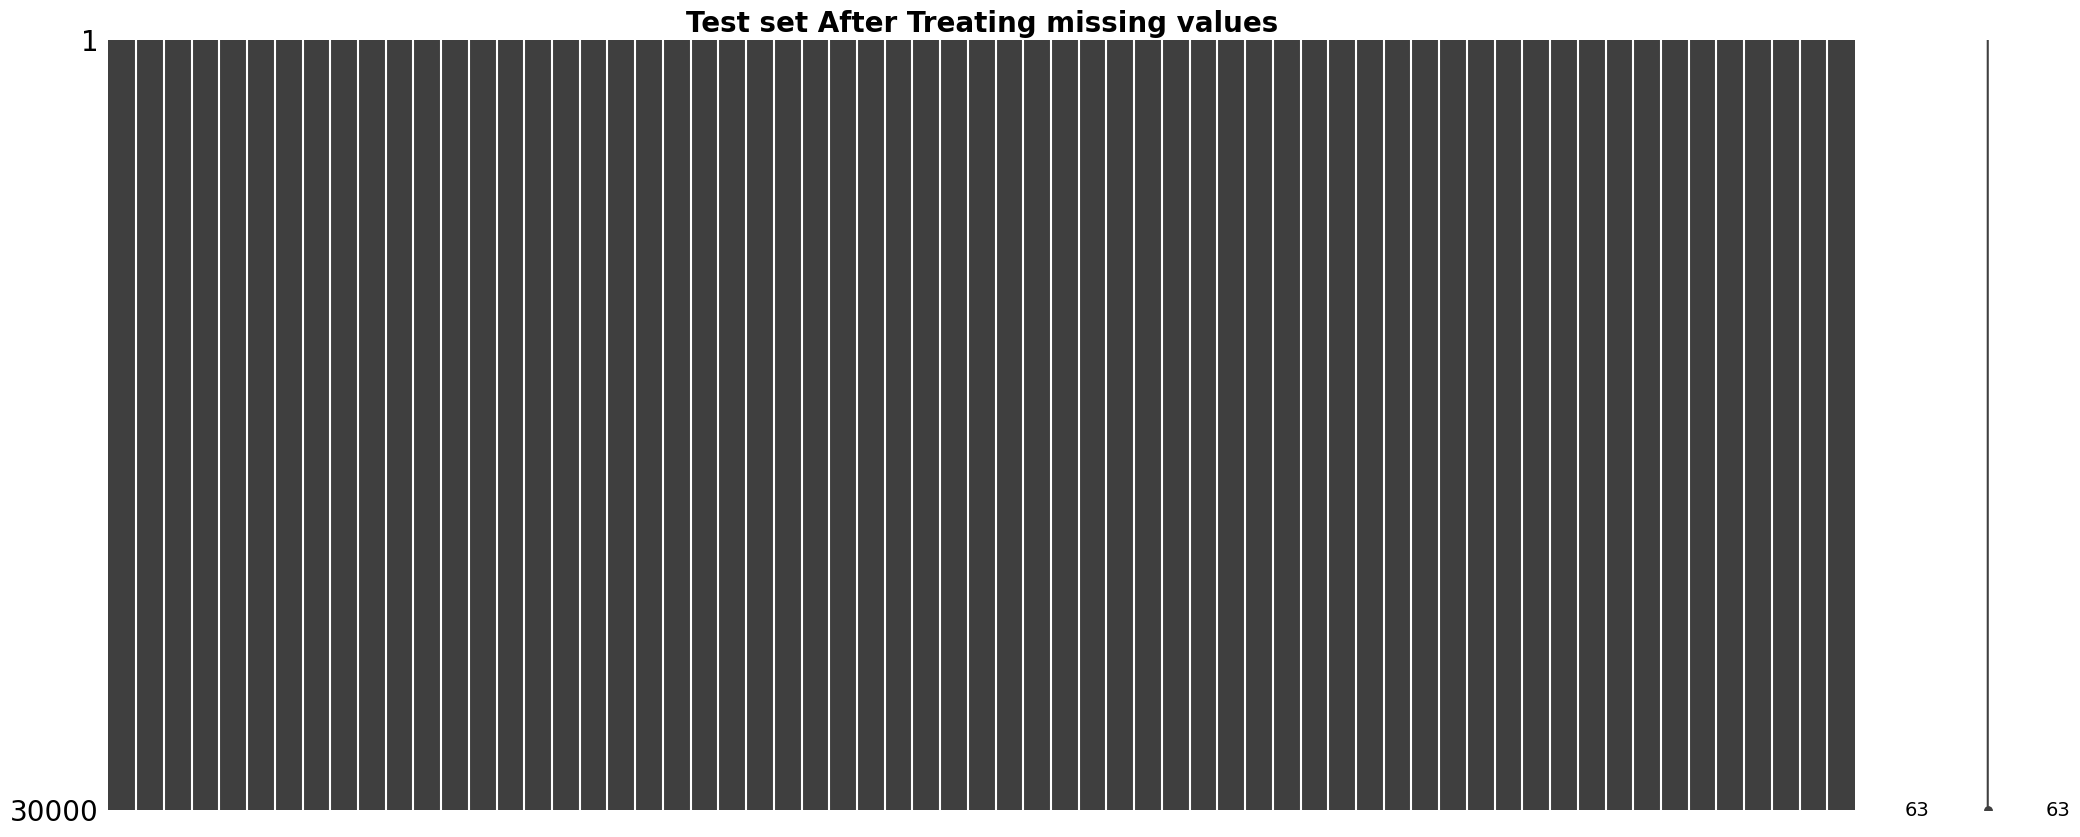

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
ic7 = list(filter(lambda x: re.search("ic.+7", x), xCols))
ic7.remove("total_ic_mou_7")

ic8 = list(filter(lambda x: re.search("ic.+8", x), xCols))
ic8.remove("total_ic_mou_8")

og6 = list(filter(lambda x: re.search("og.+6", x), xCols))
og6.remove("total_og_mou_6")

og7 = list(filter(lambda x: re.search("og.+7", x), xCols))
og7.remove("total_og_mou_7")

og8 = list(filter(lambda x: re.search("og.+8", x), xCols))
og8.remove("total_og_mou_8")


msno.matrix(data[ic7+ic8+og6+og7+og8])
plt.title("Train set Before Treating missing values", fontsize=20, fontweight="bold")
msno.matrix(unseen[ic7+ic8+og6+og7+og8])
plt.title("Test set Before Treating missing values", fontsize=20, fontweight="bold")

icOg_dict = {
    "total_ic_mou_7":ic7,
    "total_ic_mou_8":ic8,
    "total_og_mou_6":og6,
    "total_og_mou_7":og7,
    "total_og_mou_8":og8}

for k in icOg_dict.keys():
  print(data.loc[data[icOg_dict[k]].isnull().all(1), k].value_counts())

  # since the total minutes of calls is zero for rows with na for all income calls we can replace them by zero.
  idx = data.loc[data[icOg_dict[k]].isnull().all(1),].index
  data.loc[idx, icOg_dict[k]] = data.loc[idx, icOg_dict[k]].replace(np.nan, 0)
  data.loc[idx, icOg_dict[k]]

  idx = unseen.loc[unseen[icOg_dict[k]].isnull().all(1),].index
  unseen.loc[idx, icOg_dict[k]] = unseen.loc[idx, icOg_dict[k]].replace(np.nan, 0)
  unseen.loc[idx, icOg_dict[k]]

msno.matrix(data[ic7+ic8+og6+og7+og8])
plt.title("Train set After Treating missing values", fontsize=20, fontweight="bold")

msno.matrix(unseen[ic7+ic8+og6+og7+og8])
plt.title("Test set After Treating missing values", fontsize=20, fontweight="bold")

In [ ]:
# find percentage of missing values in each column
percNaDf = (data.isnull().sum()/data.shape[0])*100
print(percNaDf[percNaDf>0])

netCols = percNaDf[percNaDf>0].index

# check presence of blank rows
null_mask = data.isnull().all(axis=1)
null_rows = data[null_mask]

print("\nNumber of Blank Rows:", null_rows.shape[0])

# check rows with missing values
null_mask = data.isnull().any(axis=1)
null_rows = data[null_mask]

print("Number Rows with Missing values:", null_rows.shape[0])

onnet_mou_6     3.954342
onnet_mou_7     3.838626
onnet_mou_8     5.290076
offnet_mou_6    3.954342
offnet_mou_7    3.838626
offnet_mou_8    5.290076
dtype: float64

Number of Blank Rows: 0
Number Rows with Missing values: 6157


onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  67231.000000  67312.000000  66296.000000  67231.000000  67312.000000   
mean     133.153275    133.894438    132.978257    198.874771    197.153383   
std      299.963093    311.277193    311.896596    316.818355    322.482226   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.410000      6.675000      6.410000     34.860000     32.240000   
50%       34.110000     32.280000     32.100000     96.480000     91.885000   
75%      119.390000    115.837500    115.060000    232.990000    227.630000   
max     7376.710000   8157.780000  10752.560000   8362.360000   7043.980000   

       offnet_mou_8  
count  66296.000000  
mean     196.543577  
std      324.089234  
min        0.000000  
25%       31.575000  
50%       91.800000  
75%      229.345000  
max    14007.340000

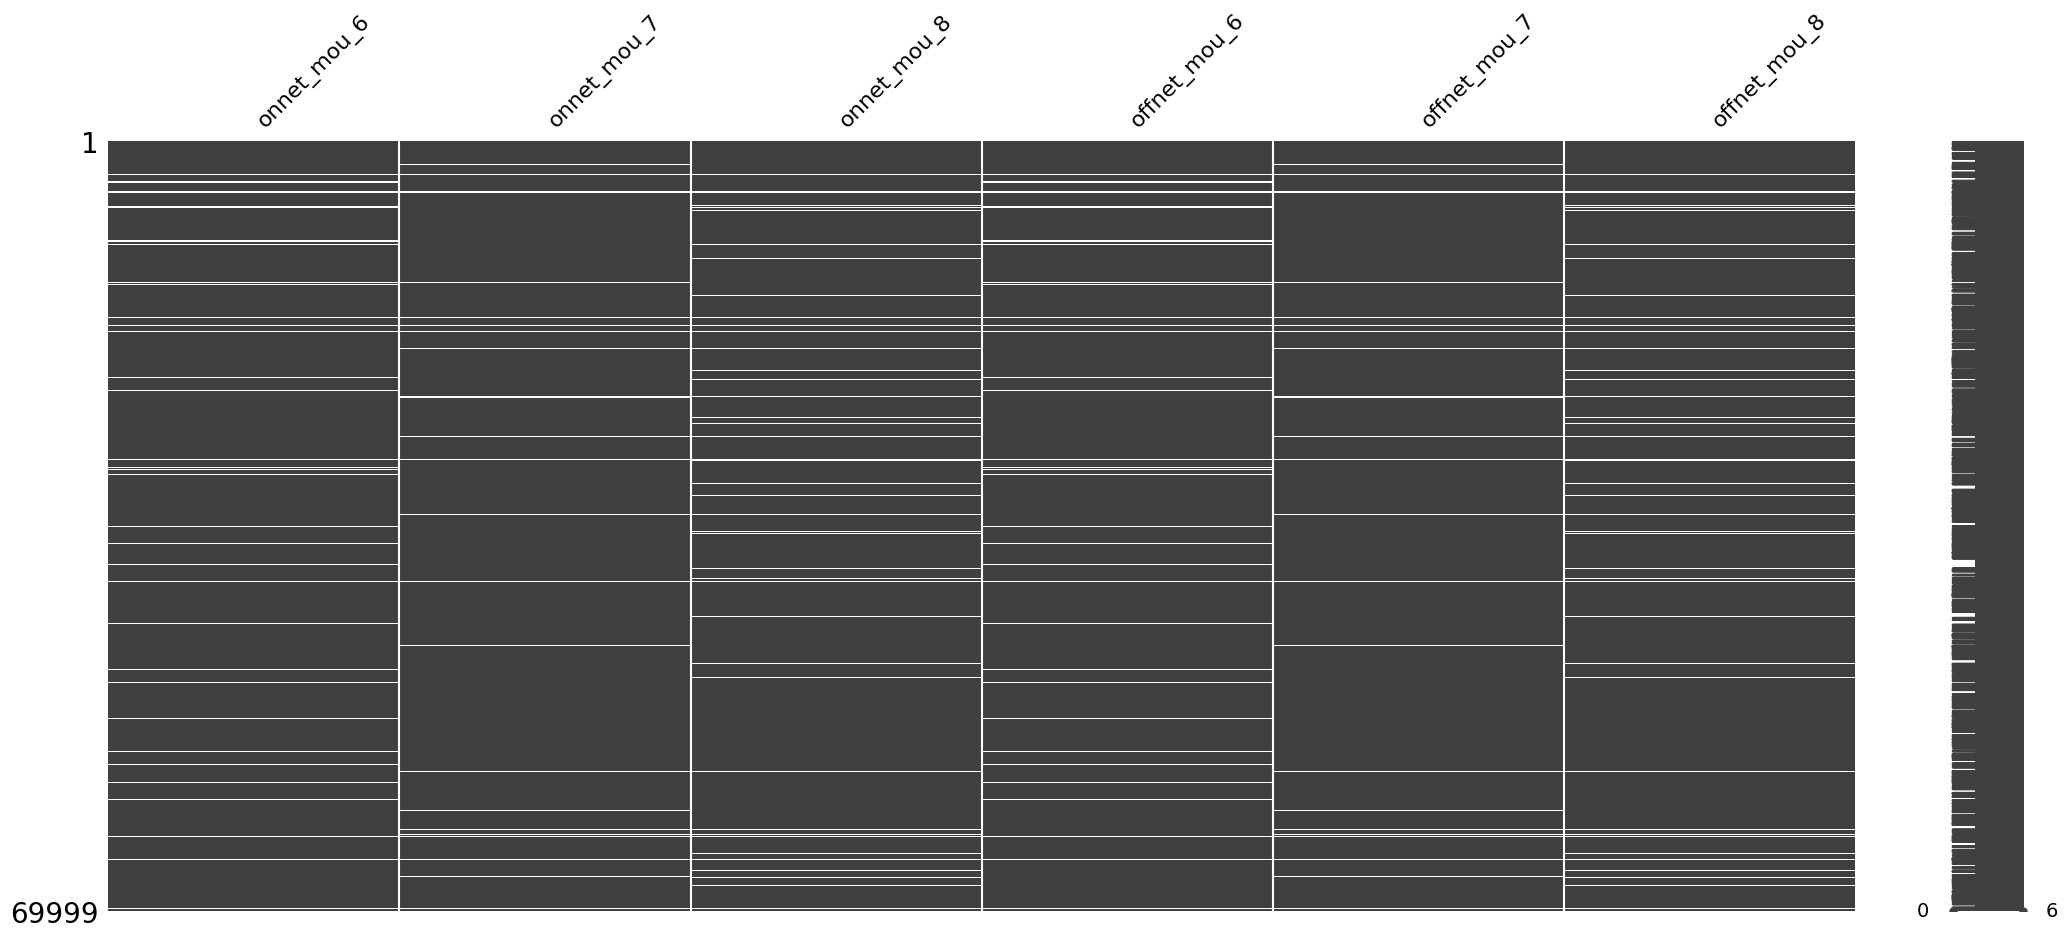

In [ ]:
msno.matrix(data[netCols])
data[netCols].describe(include="all")

since these columns are related to the number of minutes on and off net I will fill them by the mean of each column after test and train split

In [ ]:
# meanCols = data[netCols].mean(skipna=True)
# meanCols

# data[netCols] = data[netCols].fillna(meanCols)
# msno.matrix(data[netCols])

Let's look at each variable's datatype:

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
data.info(verbose=1)

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 125 columns):
 #    Column              Dtype  
---   ------              -----  
 0    arpu_6              float64
 1    arpu_7              float64
 2    arpu_8              float64
 3    onnet_mou_6         float64
 4    onnet_mou_7         float64
 5    onnet_mou_8         float64
 6    offnet_mou_6        float64
 7    offnet_mou_7        float64
 8    offnet_mou_8        float64
 9    roam_ic_mou_6       float64
 10   roam_ic_mou_7       float64
 11   roam_ic_mou_8       float64
 12   roam_og_mou_6       float64
 13   roam_og_mou_7       float64
 14   roam_og_mou_8       float64
 15   loc_og_t2t_mou_6    float64
 16   loc_og_t2t_mou_7    float64
 17   loc_og_t2t_mou_8    float64
 18   loc_og_t2m_mou_6    float64
 19   loc_og_t2m_mou_7    float64
 20   loc_og_t2m_mou_8    float64
 21   loc_og_t2f_mou_6    float64
 22   loc_og_t2f_mou_7    float64
 23   loc_og_t2f_mou_8    float64
 24   

Let's also summarize the features using the df.describe method:

<IPython.core.display.Javascript object>

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  67231.000000  67312.000000   
mean     283.134365    278.185912    278.858826    133.153275    133.894438   
std      334.213918    344.366927    351.924315    299.963093    311.277193   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.581000     86.714000     84.095000      7.410000      6.675000   
50%      197.484000    191.588000    192.234000     34.110000     32.280000   
75%      370.791000    365.369500    369.909000    119.390000    115.837500   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  66296.000000  67231.000000  67312.000000  66296.000000   69999.000000   
mean     132.978257    198.874771    197.153383    196.543577       9.379276   
std      311.896596    316.818355    322.482226    324.089234      56.260778   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        6.410000     34.860000     32.240000     31.575000       0.000000   
50%       32.100000     96.480000     91.885000     91.800000       0.000000   
75%      115.060000    232.990000    227.630000    229.345000       0.000000   
max    10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   69999.000000   69999.000000   69999.000000   69999.000000   
mean        6.745305       6.634328      13.625476       9.464386   
std        54.892940      51.999899      72.055036      57.409013   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   69999.000000      69999.000000      69999.000000      69999.000000   
mean        9.254848         45.050076         44.394344         43.269280   
std        62.923987        148.238746        151.998993        149.944829   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.010000          1.010000          0.760000   
50%         0.000000         10.660000         10.430000         10.060000   
75%         0.000000         38.680000         37.780000         37.260000   
max      5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean          89.551272         87.313796         86.301054          3.595161   
std          159.846546        151.875981        150.286404         13.073900   
min            0.000000          0.000000          0.000000          0.000000   
25%            7.290000          7.530000          6.440000          0.000000   
50%           37.680000         37.010000         35.940000          0.000000   
75%          105.685000        103.330000        103.110000          1.860000   
max         4696.830000       4557.140000       4961.330000        617.580000   

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean           3.632045          3.467948          1.081499          1.308807   
std           13.324919         12.686917          5.631416          7.765132   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.0000

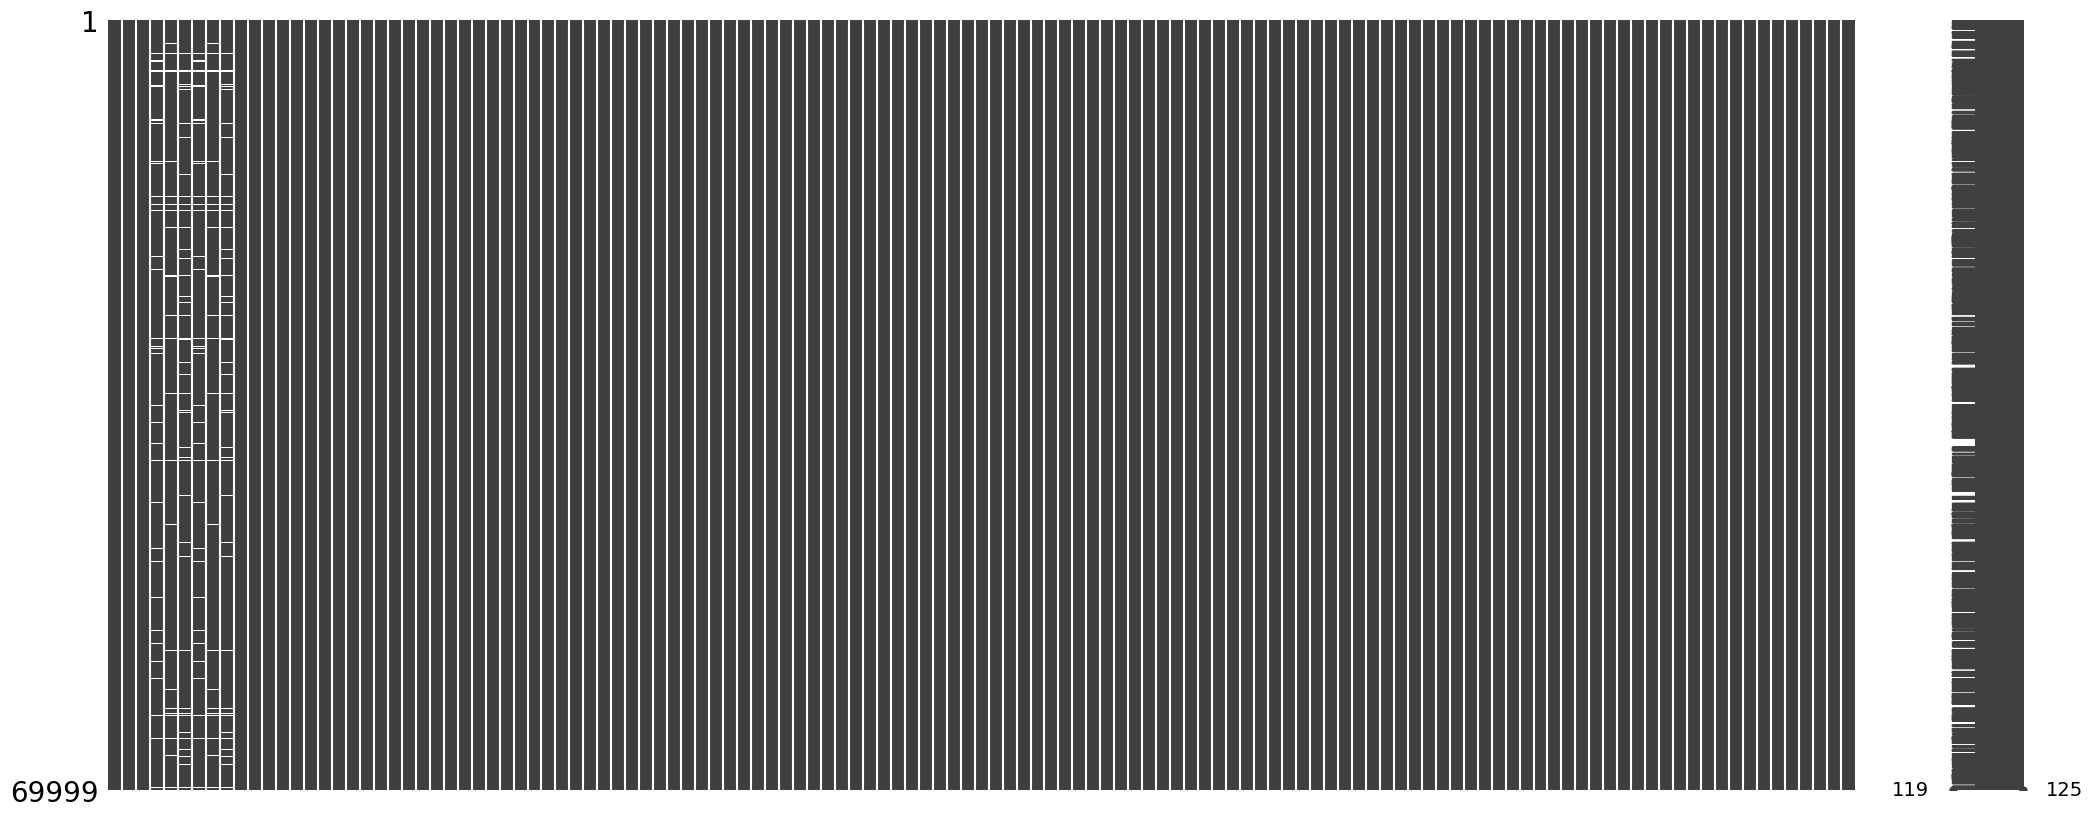

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
msno.matrix(data)
data.describe(include="all")

skewed variables and presence of outliers will reduce models robustness
and generalizability. So I have looked at distribution of independent variables try to remove their outlier or reduce skewedness by normalization using log2 transform.

In [ ]:
# Identify low variant columns:
variantDf = data.nunique().sort_values()
print(variantDf)

churn_probability         2
monthly_2g_6              5
monthly_2g_7              6
monthly_2g_8              6
monthly_3g_6             10
monthly_3g_8             12
monthly_3g_7             13
sachet_3g_6              23
sachet_3g_7              26
sachet_3g_8              28
sachet_2g_6              30
sachet_2g_8              32
sachet_2g_7              33
spl_ic_mou_6             78
total_rech_num_8         92
total_rech_num_6         94
spl_ic_mou_8             95
total_rech_num_7         96
spl_ic_mou_7            103
og_others_7             148
last_day_rch_amt_7      166
max_rech_amt_7          178
og_others_8             179
last_day_rch_amt_6      179
max_rech_amt_6          190
last_day_rch_amt_8      191
max_rech_amt_8          202
og_others_6             914
isd_og_mou_8           1008
isd_og_mou_7           1084
isd_og_mou_6           1103
ic_others_6            1523
ic_others_8            1565
ic_others_7            1658
loc_og_t2c_mou_6       1945
std_og_t2f_mou_8    

# 2. Create X, y and then Train test split


In [ ]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X

X.shape, y.shape

((69999, 124), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 124), (14000, 124), (55999,), (14000,))

In [ ]:
X_train.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
id                                                                        
2671    89.099  107.720  158.874         0.00         4.21       108.83   
64500  305.374  286.269  321.535        63.83       145.63        99.03   
5997   137.566   84.457  199.629       170.58        15.49       266.16   
36762   38.084   44.174   66.254         0.00         0.00         0.00   
11536  195.131    0.000    0.000         0.00          NaN          NaN   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
id                                                                              
2671           9.31         28.29         49.28           0.00           0.00   
64500         84.28        146.96        209.91           6.58           8.69   
5997          22.24          9.34         54.28           0.00           2.28   
36762          0.66          1.98          0.00           0.00           0.00   
11536         47.03           NaN           NaN           0.00           0.00   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
id                                                                  
2671            0.00            0.0           0.00           0.00   
64500          13.26            0.0           1.48           0.00   
5997            2.68            0.0           4.53           0.08   
36762           0.00            0.0           0.00           0.00   
11536           0.00            0.0           0.00           0.00   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
id                                                                              
2671               0.00              4.21             25.99              4.38   
64500             62.48            144.99             98.64             64.58   
5997               3.11              0.85              3.81             10.08   
36762              0.00              0.00              0.00              0.00   
11536              0.00              0.00              0.00             45.73   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
id                                                                              
2671              11.98             21.61               0.0              0.00   
64500            105.18            162.44               0.0              3.55   
5997               1.73             15.99               0.0              0.00   
36762              0.00              0.00               0.0              0.00   
11536              0.00              0.00               1.3              0.00   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
id                                                                              
2671               0.00              0.00               0.0              3.83   
64500              3.46              1.78               0.0              2.50   
5997               0.00              0.00               0.0              0.00   
36762              0.00              0.00               0.0              0.00   
11536              0.00              0.00               0.0              0.00   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
id                                                                  
2671           4.38         16.19         47.61              0.00   
64500        127.06        253.73        264.56              1.35   
5997          13.19          2.58         19.81            167.46   
36762          0.00          0.00          0.00              0.00   
11536         47.03          0.00          0.00              0.00   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
id                                                                              
2671               0.00             82.83              0.00              2.14   

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

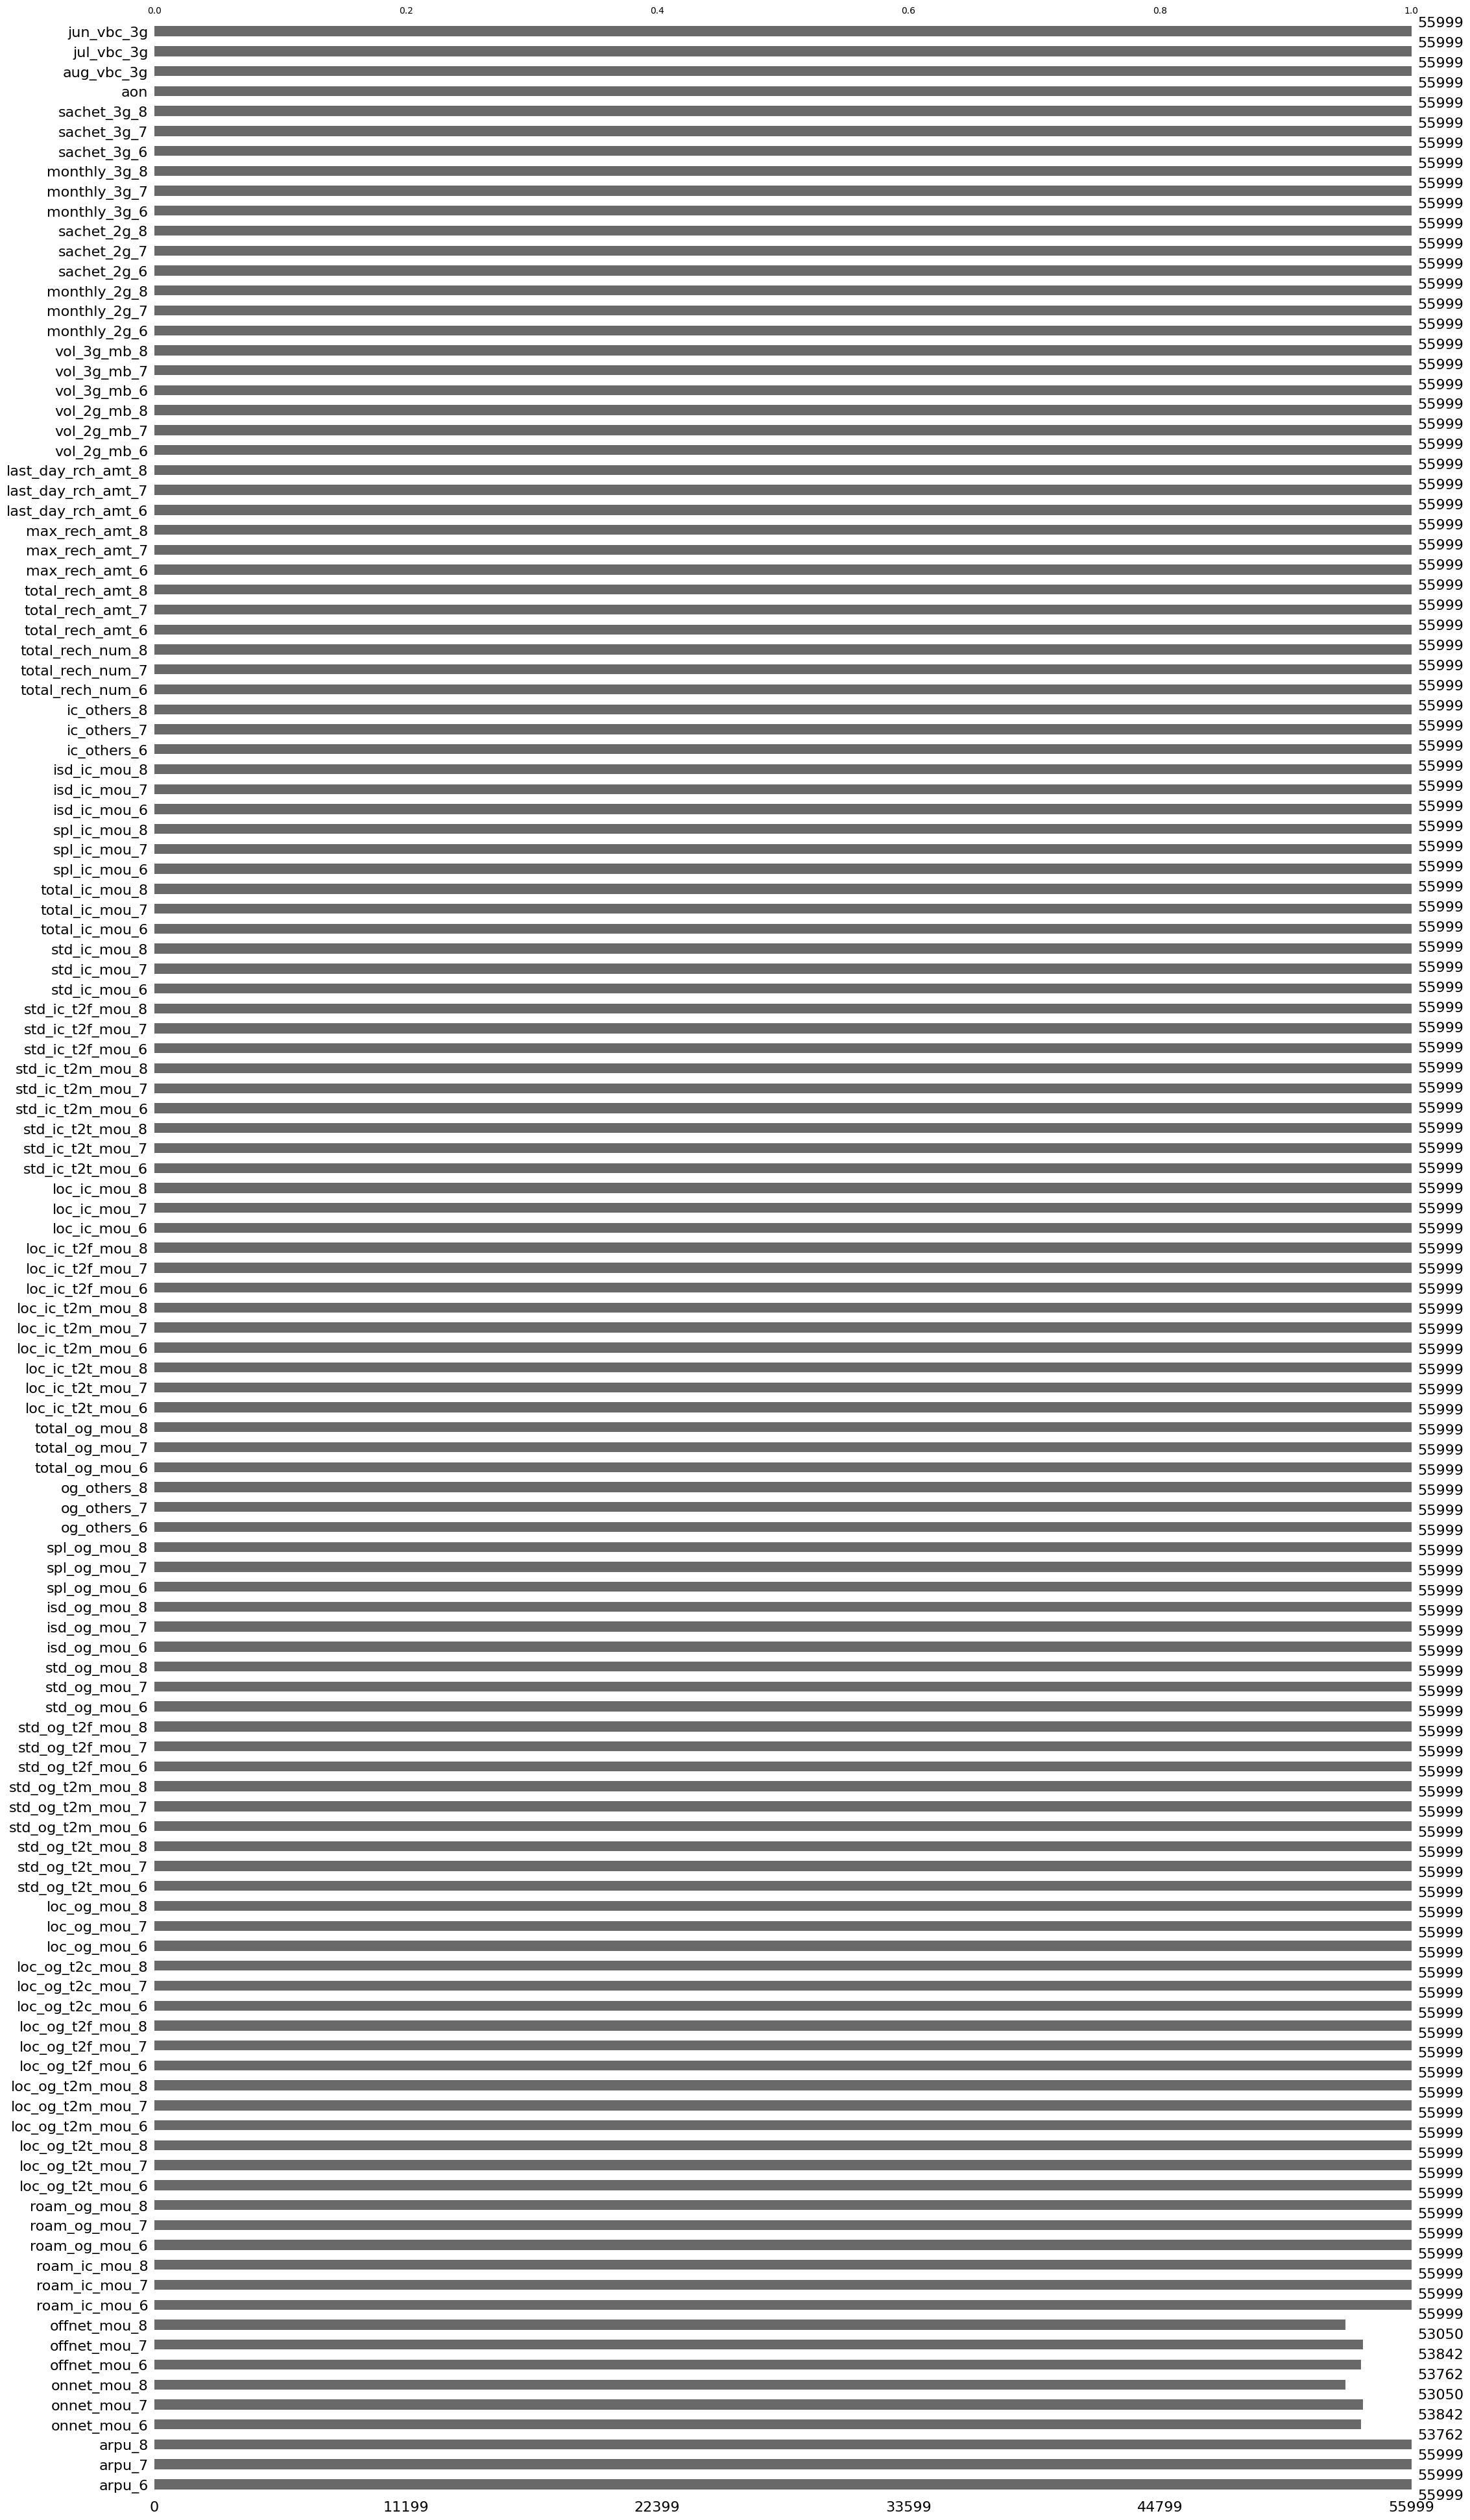

In [ ]:
msno.bar(X_train)

<Axes: >

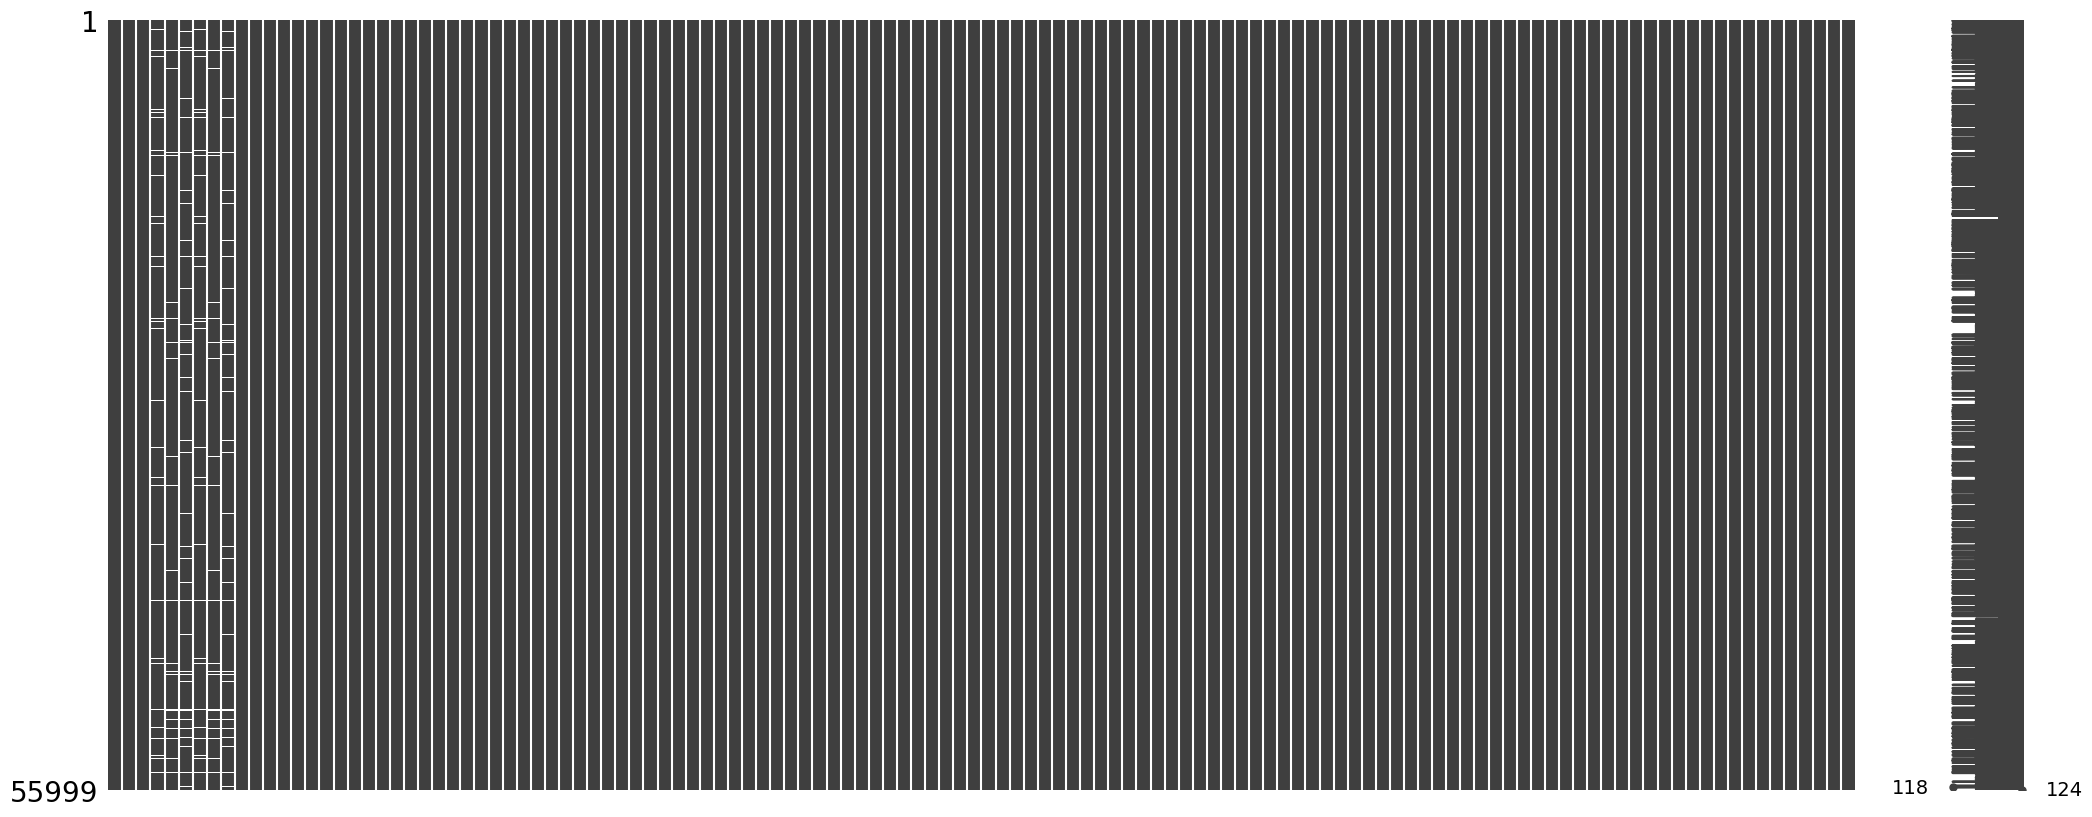

In [ ]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

In [ ]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

arpu_6                0.000000
arpu_7                0.000000
arpu_8                0.000000
onnet_mou_6           3.994714
onnet_mou_7           3.851854
onnet_mou_8           5.266165
offnet_mou_6          3.994714
offnet_mou_7          3.851854
offnet_mou_8          5.266165
roam_ic_mou_6         0.000000
roam_ic_mou_7         0.000000
roam_ic_mou_8         0.000000
roam_og_mou_6         0.000000
roam_og_mou_7         0.000000
roam_og_mou_8         0.000000
loc_og_t2t_mou_6      0.000000
loc_og_t2t_mou_7      0.000000
loc_og_t2t_mou_8      0.000000
loc_og_t2m_mou_6      0.000000
loc_og_t2m_mou_7      0.000000
loc_og_t2m_mou_8      0.000000
loc_og_t2f_mou_6      0.000000
loc_og_t2f_mou_7      0.000000
loc_og_t2f_mou_8      0.000000
loc_og_t2c_mou_6      0.000000
loc_og_t2c_mou_7      0.000000
loc_og_t2c_mou_8      0.000000
loc_og_mou_6          0.000000
loc_og_mou_7          0.000000
loc_og_mou_8          0.000000
std_og_t2t_mou_6      0.000000
std_og_t2t_mou_7      0.000000
std_og_t

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [ ]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=124)

In [ ]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 124)

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data -

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, Since I already fill out those that I could by zero and remove columns with high % of missing values for the rest as mentioned beofre I.m using the mean of the column to fill missing values. I will just demostrate a simple imputation with constant values as zeros.

In [ ]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8'],
      dtype='object')

In [ ]:
X_test = pd.DataFrame(X_test, columns=new_vars)
imp = SimpleImputer(strategy='mean')
imp = imp.fit(X_train_filtered[impute_cols])
X_train_filtered[impute_cols] = imp.transform(X_train_filtered[impute_cols])
X_test[impute_cols] = imp.transform(X_test[impute_cols])

<Axes: >

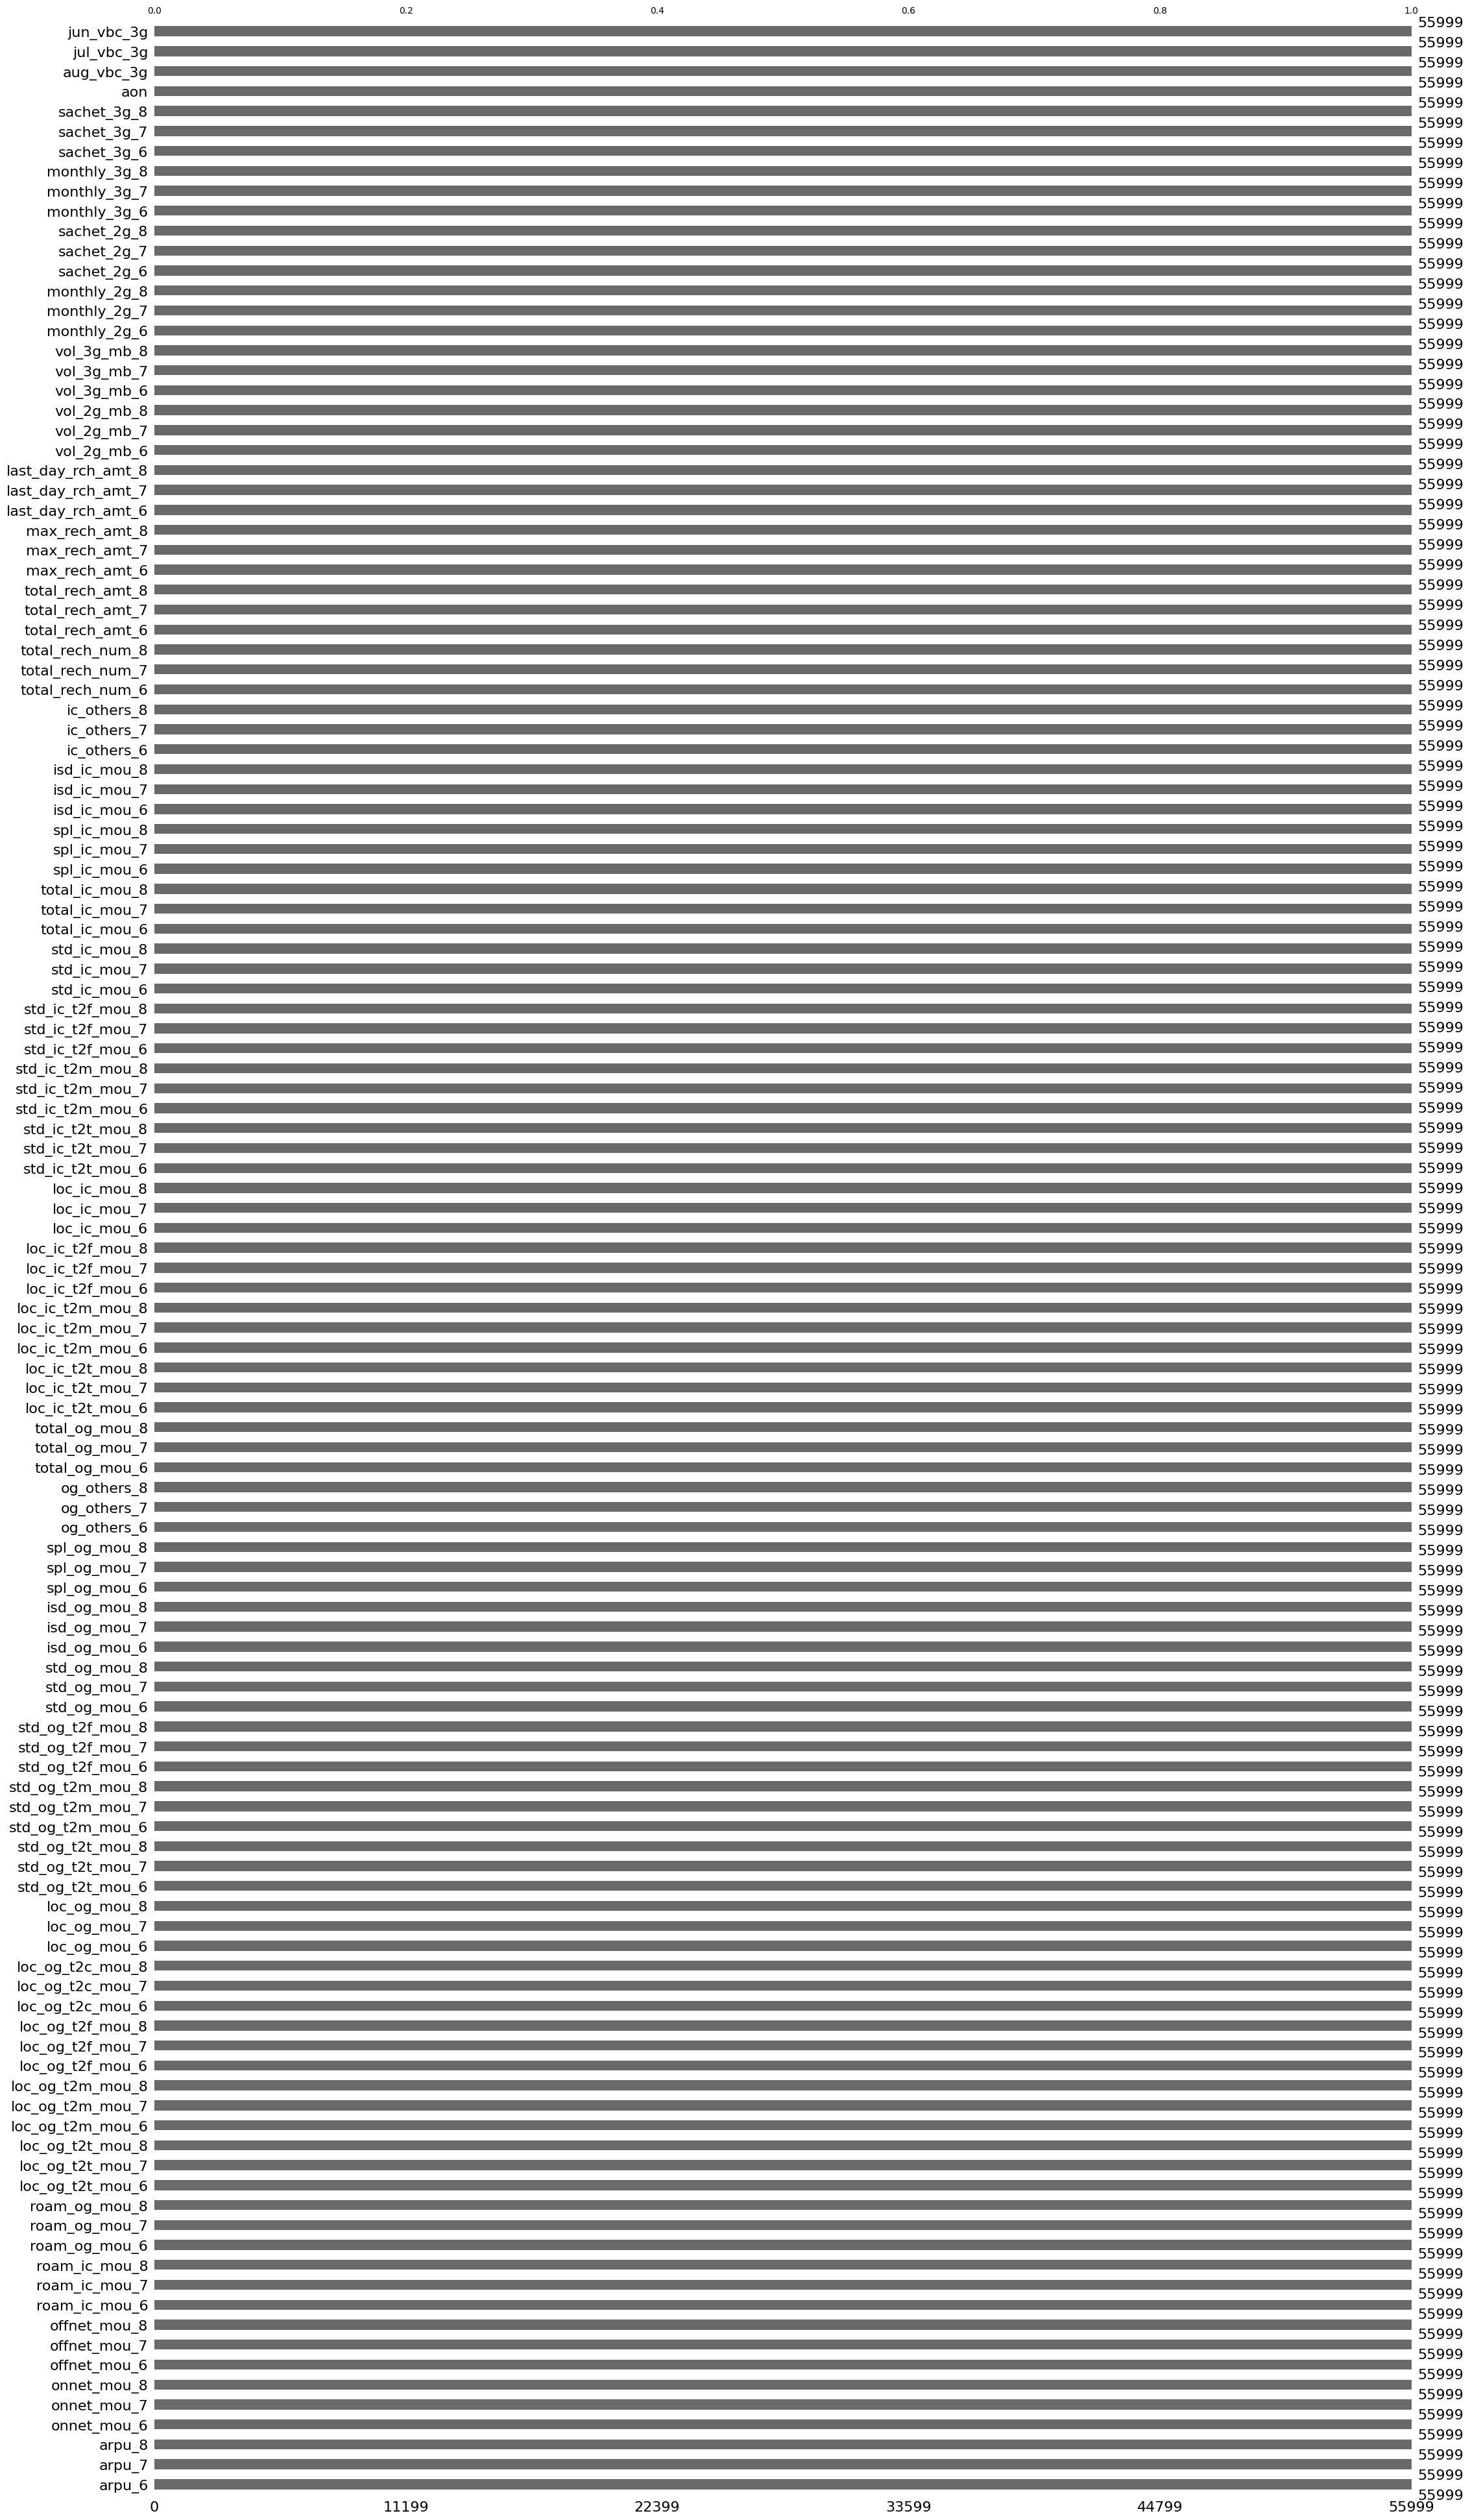

In [ ]:
msno.bar(X_train_filtered)

In [ ]:
X_train_filtered.describe()

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     283.364640    279.039615    279.661081    133.222657    134.257890   
std      338.874295    354.554138    362.060549    295.660340    308.700049   
min    -2258.709000  -1084.211000   -945.808000      0.000000      0.000000   
25%       93.581000     86.934500     84.556000      8.050000      7.210000   
50%      197.624000    192.459000    192.505000     37.910000     35.940000   
75%      371.512000    366.534500    370.419500    133.222657    134.257890   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000   55999.000000   
mean     133.563582    199.509871    197.572827    196.562621       9.239982   
std      308.015967    310.823338    316.645447    316.745886      55.669689   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        7.430000     37.210000     33.980000     34.610000       0.000000   
50%       37.130000    104.080000     98.610000    101.580000       0.000000   
75%      133.563582    223.860000    219.010000    216.325000       0.000000   
max    10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   55999.000000   55999.000000   55999.000000   55999.000000   
mean        6.540509       6.628400      13.581820       9.333210   
std        52.595358      51.158641      70.756524      56.375921   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   55999.000000      55999.000000      55999.000000      55999.000000   
mean        9.369963         45.078879         44.612264         43.550384   
std        64.877162        150.124889        155.067375        153.965421   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.000000          1.000000          0.760000   
50%         0.000000         10.660000         10.380000         10.060000   
75%         0.000000         38.710000         38.010000         37.440000   
max      5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      55999.000000      55999.000000      55999.000000      55999.000000   
mean          89.691696         87.365829         86.430982          3.584606   
std          160.443171        151.748233        150.455614         13.262764   
min            0.000000          0.000000          0.000000          0.000000   
25%            7.290000          7.530000          6.485000          0.000000   
50%           37.630000         37.080000         36.130000          0.000000   
75%          105.960000        103.290000        103.140000          1.860000   
max         4696.830000       4557.140000       4961.330000        617.580000   

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
count      55999.000000      55999.000000      55999.000000      55999.000000   
mean           3.622698          3.473109          1.070775          1.318512   
std           13.493679         12.928139          5.578199          8.188405   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.0000

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

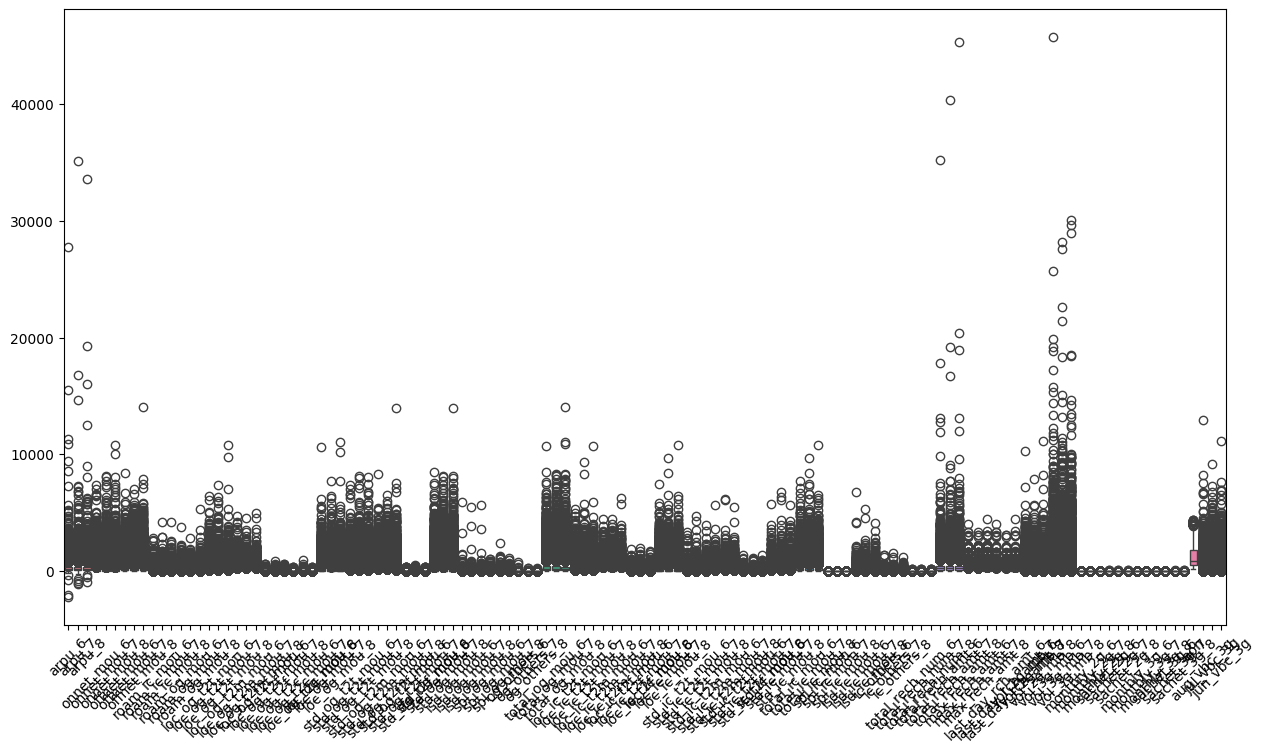

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [ ]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

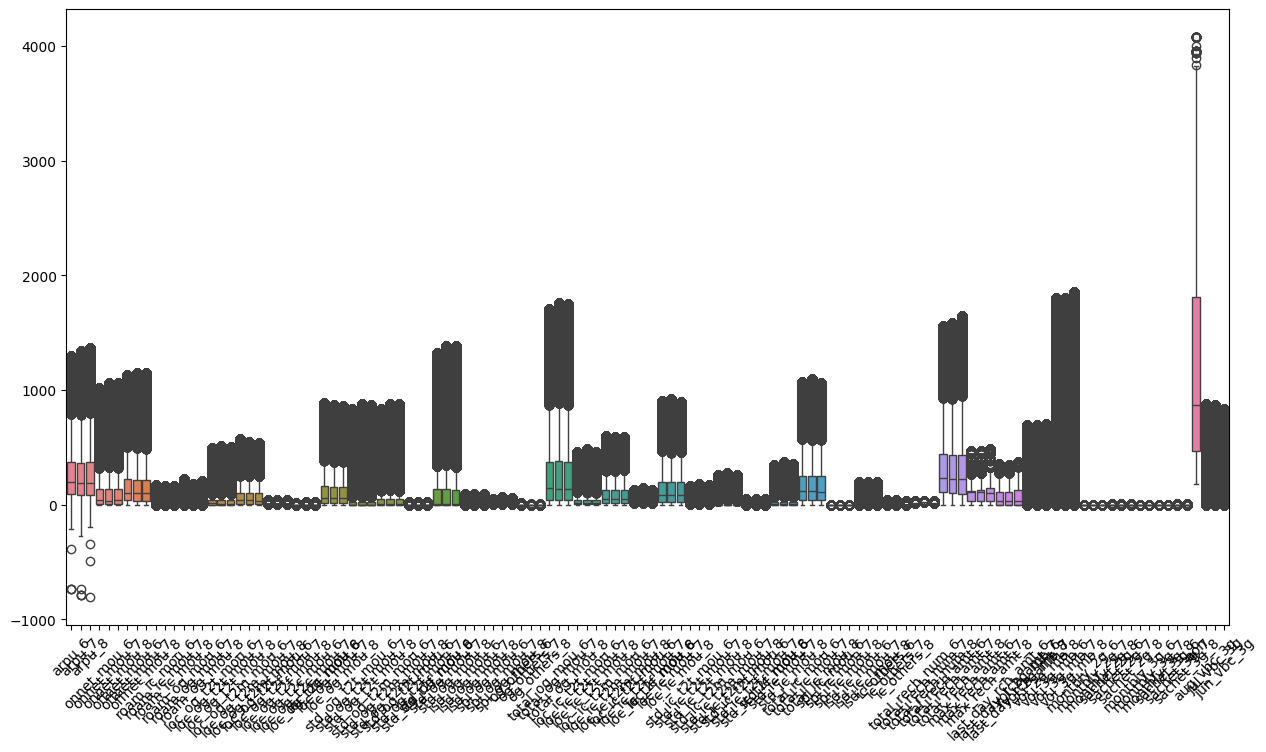

In [ ]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

In [ ]:
#  anything higher than 1 or lower than -1 is skewed or has outlier
X_train_filtered1.skew()

arpu_6                 1.725614
arpu_7                 1.790211
arpu_8                 1.797920
onnet_mou_6            2.856330
onnet_mou_7            2.906665
onnet_mou_8            2.932545
offnet_mou_6           2.288165
offnet_mou_7           2.316347
offnet_mou_8           2.315178
roam_ic_mou_6          5.119359
roam_ic_mou_7          6.141931
roam_ic_mou_8          6.024264
roam_og_mou_6          4.584997
roam_og_mou_7          5.089474
roam_og_mou_8          5.414676
loc_og_t2t_mou_6       3.835264
loc_og_t2t_mou_7       3.965507
loc_og_t2t_mou_8       3.949141
loc_og_t2m_mou_6       2.331862
loc_og_t2m_mou_7       2.290092
loc_og_t2m_mou_8       2.264879
loc_og_t2f_mou_6       3.664542
loc_og_t2f_mou_7       3.663984
loc_og_t2f_mou_8       3.693033
loc_og_t2c_mou_6       4.293667
loc_og_t2c_mou_7       4.704653
loc_og_t2c_mou_8       4.086006
loc_og_mou_6           2.381093
loc_og_mou_7           2.395976
loc_og_mou_8           2.376713
std_og_t2t_mou_6       3.322147
std_og_t

In [ ]:
# Positive kurtosis indicates hevier tails and a more peaked distribution, while
# negative kurtosis suggests lighter tails and a flatter distribution.
# Kurtusis tailedness refers to the presence of outliers.
# Datasets with high kurtosis tend to have a distinct peak near the mean, decline rapidly, and have heavy tails.
# Datasets with low kurtosis tend to have a flat top near the mean rather than a sharp peak.

X_train_filtered1.kurt()

arpu_6                  3.263406
arpu_7                  3.624797
arpu_8                  3.691593
onnet_mou_6             8.259197
onnet_mou_7             8.556499
onnet_mou_8             8.797804
offnet_mou_6            5.427117
offnet_mou_7            5.504465
offnet_mou_8            5.594937
roam_ic_mou_6          27.325331
roam_ic_mou_7          40.318804
roam_ic_mou_8          38.640306
roam_og_mou_6          21.724693
roam_og_mou_7          26.853533
roam_og_mou_8          30.904362
loc_og_t2t_mou_6       16.964782
loc_og_t2t_mou_7       18.267782
loc_og_t2t_mou_8       18.157295
loc_og_t2m_mou_6        5.616801
loc_og_t2m_mou_7        5.345270
loc_og_t2m_mou_8        5.205095
loc_og_t2f_mou_6       14.211945
loc_og_t2f_mou_7       14.206732
loc_og_t2f_mou_8       14.433995
loc_og_t2c_mou_6       19.463059
loc_og_t2c_mou_7       24.436190
loc_og_t2c_mou_8       17.471608
loc_og_mou_6            5.981720
loc_og_mou_7            6.040723
loc_og_mou_8            5.940849
std_og_t2t

In [ ]:
X_train_filtered1

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
id                                                                        
2671    89.099  107.720  158.874         0.00      4.21000   108.830000   
64500  305.374  286.269  321.535        63.83    145.63000    99.030000   
5997   137.566   84.457  199.629       170.58     15.49000   266.160000   
36762   38.084   44.174   66.254         0.00      0.00000     0.000000   
11536  195.131    0.000    0.000         0.00    134.25789   133.563582   
...        ...      ...      ...          ...          ...          ...   
30128  160.039   98.451  142.340        66.41     10.66000    44.660000   
58342  515.476  481.497  326.625        14.99     19.01000    10.910000   
39687  122.302   16.882   59.797       207.84      3.99000   105.080000   
18512    6.238  258.216  169.475         0.00     10.18000     2.150000   
61390  107.186  257.382  126.760        20.84    159.31000    24.490000   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
id                                                                              
2671           9.31     28.290000     49.280000           0.00           0.00   
64500         84.28    146.960000    209.910000           6.58           8.69   
5997          22.24      9.340000     54.280000           0.00           2.28   
36762          0.66      1.980000      0.000000           0.00           0.00   
11536         47.03    197.572827    196.562621           0.00           0.00   
...             ...           ...           ...            ...            ...   
30128        126.48     91.780000    121.340000           0.00           0.00   
58342        310.31    315.610000    237.560000           0.00           0.00   
39687          5.99      1.710000      7.860000           0.00           3.96   
18512          0.79     39.290000      5.910000           0.00           0.00   
61390         54.84    310.260000     12.030000           0.00           0.00   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
id                                                                  
2671            0.00            0.0           0.00           0.00   
64500          13.26            0.0           1.48           0.00   
5997            2.68            0.0           4.53           0.08   
36762           0.00            0.0           0.00           0.00   
11536           0.00            0.0           0.00           0.00   
...              ...            ...            ...            ...   
30128           0.00            0.0           0.00           0.00   
58342           0.00            0.0           0.00           0.00   
39687           0.36            0.0           0.00           7.38   
18512           0.00            0.0           0.00           0.00   
61390           0.00            0.0           0.00           0.00   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
id                                                                              
2671               0.00              4.21             25.99              4.38   
64500             62.48            144.99             98.64             64.58   
5997               3.11              0.85              3.81             10.08   
36762              0.00              0.00              0.00              0.00   
11536              0.00              0.00              0.00             45.73   
...                 ...               ...               ...               ...   
30128             66.41             10.66             44.66            126.01   
58342             14.99             19.01             10.91            300.91   
39687              0.48              0.00              0.00              0.70   
18512              0.00              5.33              2.15              0.43   
61390              6.28             57.41             20.96             42.63   

       loc_og_t2m_mou_7  l

skewed variables and presence of outliers will reduce models robustness
and generalizability. So I have looked at distribution of independent variables try to remove their outlier or reduce skewedness by normalization using log2 transform.

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [ ]:
scale = StandardScaler()
scale = scale.fit(X_train_filtered1)
X_train_filtered2 = scale.transform(X_train_filtered1)
X_test = scale.transform(X_test)

<Axes: >

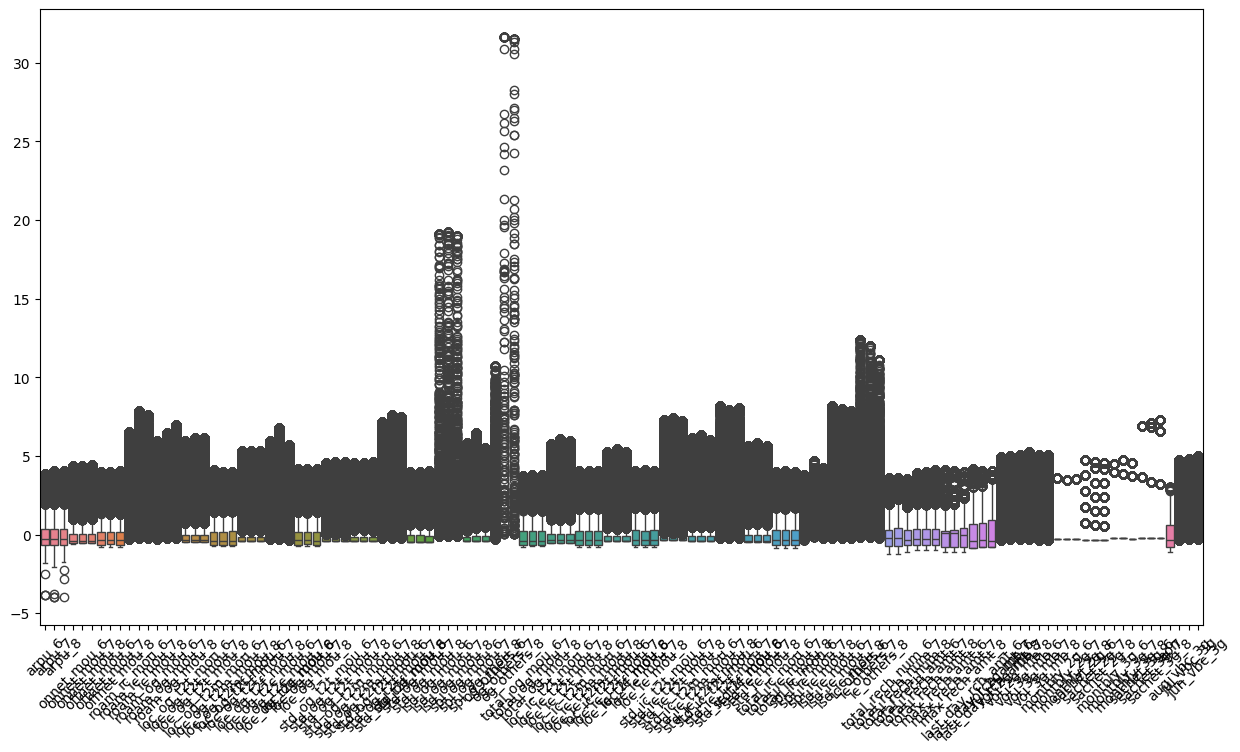

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage.

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html

Lets also plot the correlations for each feature for bivariate analysis.

In [ ]:
from sklearn import preprocessing
pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
pt = pt.fit(X_train_filtered2)
X_train_lognormal = pt.transform(X_train_filtered2)
X_test_lognormal = pt.transform(X_test)

<Axes: >

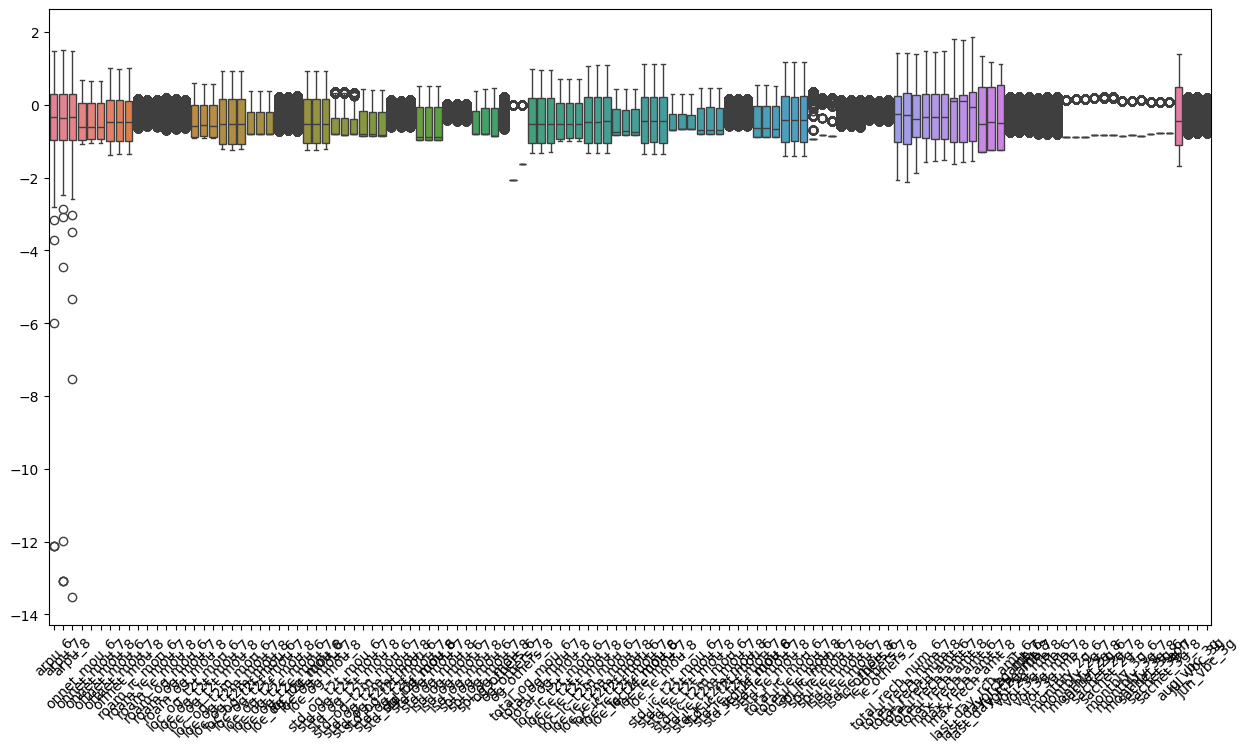

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_lognormal, columns=new_vars))

## **investigate any hidden pattern in data**

I have used kmean clustering to investigate any possible clustering pattern in customers behaviour or attitude

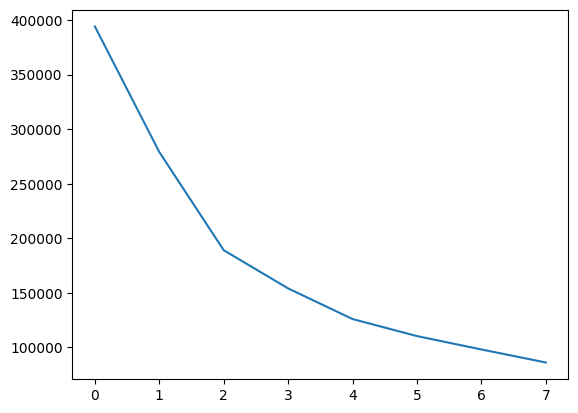

In [ ]:
from sklearn.cluster import KMeans

# using elbow plot to identify best number of clusters
def elbowPlot(df, n):
  ssd = []
  range_n_clusters = np.arange(2,n)
  for num_clusters in range_n_clusters:
    # print(num_clusters)
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df)

    ssd.append(kmeans.inertia_)
  plt.plot(ssd)

pca = PCA(2)
xpca = pca.fit_transform(X_train_lognormal)
elbowPlot(xpca, 10)


as we expected it seem that our data has 2 main clusters now check the pattern of clusters.

In [ ]:
# train the model for k=2
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(xpca)

xpca = pd.DataFrame(xpca, columns=["pc1", "pc2"])
xpca['cluster_id'] = kmeans.labels_


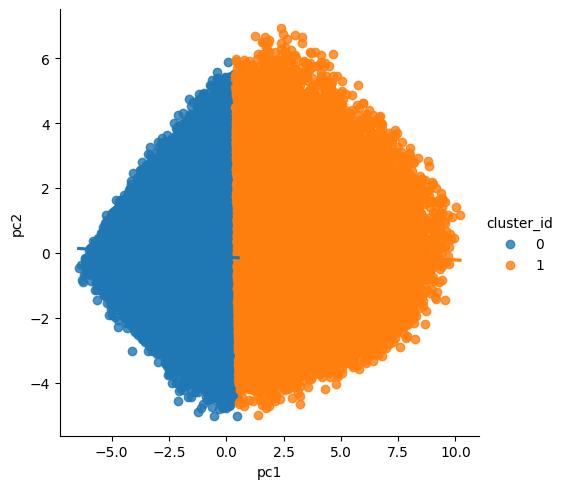

In [ ]:
#plotting the results
sns.lmplot( x="pc1", y="pc2", data=xpca, hue='cluster_id', legend=True)
plt.show()

Kmean has devide the data to two groups but due to low dimentionality of the data it is very difficult to observe any distance between two groups.

## **Bivariate analysis**

I have investigated possible correlation between features using correlation heatmap

<Axes: >

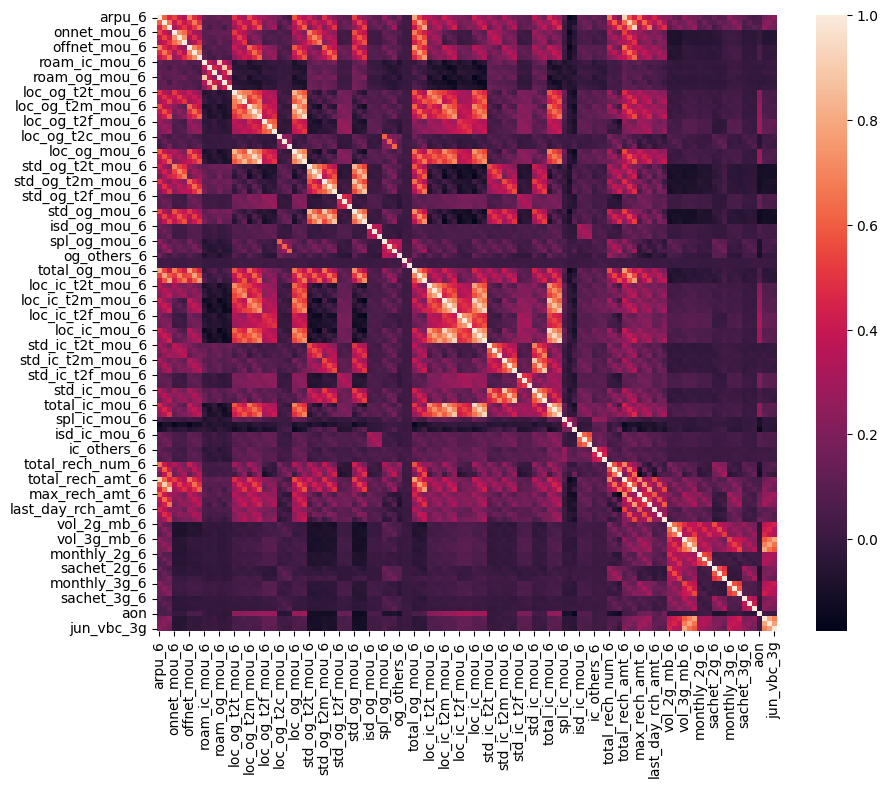

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_lognormal, columns=new_vars).corr())

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

X_train_lognormalDf = pd.DataFrame(X_train_lognormal, columns=new_vars)
corDf = X_train_lognormalDf.corr().melt(ignore_index=False)
corDf1 = corDf[corDf.index!=corDf.variable]

corDf1.drop_duplicates(subset="value", inplace=True)

corDf1.sort_values(by="value", ascending=False).head(150)

<IPython.core.display.Javascript object>

variable     value
loc_og_mou_8      loc_og_t2m_mou_8  0.947835
loc_og_mou_6      loc_og_t2m_mou_6  0.944332
loc_og_mou_7      loc_og_t2m_mou_7  0.944293
total_ic_mou_6        loc_ic_mou_6  0.938136
total_ic_mou_8        loc_ic_mou_8  0.935985
loc_ic_mou_8      loc_ic_t2m_mou_8  0.934781
total_ic_mou_7        loc_ic_mou_7  0.934282
loc_ic_mou_6      loc_ic_t2m_mou_6  0.930672
total_rech_amt_8            arpu_8  0.929608
loc_ic_mou_7      loc_ic_t2m_mou_7  0.928819
total_rech_amt_6            arpu_6  0.924311
total_rech_amt_7            arpu_7  0.915033
std_ic_mou_8      std_ic_t2m_mou_8  0.889074
roam_og_mou_6        roam_ic_mou_6  0.887089
std_ic_mou_7      std_ic_t2m_mou_7  0.886452
std_ic_mou_6      std_ic_t2m_mou_6  0.885314
roam_og_mou_8        roam_ic_mou_8  0.883737
std_og_mou_8      std_og_t2m_mou_8  0.879775
roam_og_mou_7        roam_ic_mou_7  0.879489
std_og_mou_7      std_og_t2m_mou_7  0.877246
std_og_mou_6      std_og_t2m_mou_6  0.876606
total_ic_mou_8    loc_ic_t2m_mou_8  0.873120
total_ic_mou_6    loc_ic_t2m_mou_6  0.870949
total_ic_mou_7    loc_ic_t2m_mou_7  0.866199
std_og_mou_8      std_og_t2t_mou_8  0.838334
std_og_mou_7      std_og_t2t_mou_7  0.836363
std_og_mou_6      std_og_t2t_mou_6  0.835154
loc_ic_mou_8          loc_ic_mou_7  0.833778
loc_og_mou_8      loc_og_t2t_mou_8  0.830836
loc_og_mou_6      loc_og_t2t_mou_6  0.827637
loc_og_mou_7      loc_og_t2t_mou_7  0.825962
loc_ic_t2m_mou_8  loc_ic_t2m_mou_7  0.814752
loc_og_mou_8          loc_og_mou_7  0.812485
loc_ic_mou_7          loc_ic_mou_6  0.812376
total_ic_mou_8      total_ic_mou_7  0.811787
total_og_mou_8              arpu_8  0.801585
jun_vbc_3g             vol_3g_mb_6  0.799596
loc_og_t2m_mou_8  loc_og_t2m_mou_7  0.796606
std_og_mou_8          std_og_mou_7  0.795583
loc_ic_t2m_mou_7  loc_ic_t2m_mou_6  0.793966
loc_og_mou_7          loc_og_mou_6  0.791991
std_og_t2t_mou_8  std_og_t2t_mou_7  0.791530
jul_vbc_3g              aug_vbc_3g  0.790311
total_og_mou_6              arpu_6  0.789082
jul_vbc_3g             vol_3g_mb_7  0.788919
total_og_mou_7              arpu_7  0.788011
aug_vbc_3g             vol_3g_mb_8  0.786030
loc_og_t2t_mou_8  loc_og_t2t_mou_7  0.785708
loc_ic_t2t_mou_8  loc_ic_t2t_mou_7  0.784517
total_ic_mou_7      total_ic_mou_6  0.784301
loc_ic_mou_8      loc_ic_t2t_mou_8  0.780482
total_og_mou_7        offnet_mou_7  0.780257
loc_ic_mou_6      loc_ic_t2t_mou_6  0.779615
loc_og_t2m_mou_7  loc_og_t2m_mou_6  0.778602
jun_vbc_3g              jul_vbc_3g  0.778459
loc_ic_mou_7      loc_ic_t2m_mou_8  0.775669
loc_ic_mou_8      loc_ic_t2m_mou_7  0.774837
total_ic_mou_7        loc_ic_mou_8  0.774804
total_ic_mou_8        loc_ic_mou_7  0.774458
total_rech_amt_8    total_og_mou_8  0.772918
loc_ic_mou_7      loc_ic_t2t_mou_7  0.772866
std_og_t2m_mou_8  std_og_t2m_mou_7  0.771328
total_og_mou_6        offnet_mou_6  0.769125
total_rech_amt_7    total_og_mou_7  0.768307
loc_og_mou_7      loc_og_t2m_mou_8  0.766000
total_rech_amt_6    total_og_mou_6  0.765566
loc_ic_t2t_mou_7  loc_ic_t2t_mou_6  0.765048
loc_og_mou_8      loc_og_t2m_mou_7  0.764959
loc_og_t2t_mou_7  loc_og_t2t_mou_6  0.763256
total_ic_mou_6        loc_ic_mou_7  0.760358
total_og_mou_8        offnet_mou_8  0.759797
std_og_t2t_mou_7  std_og_t2t_mou_6  0.757525
onnet_mou_8            onnet_mou_7  0.754419
loc_ic_mou_7      loc_ic_t2m_mou_6  0.753825
std_og_mou_7          std_og_mou_6  0.751858
loc_ic_mou_6      loc_ic_t2m_mou_7  0.751810
loc_ic_t2f_mou_8  loc_ic_t2f_mou_7  0.750653
max_rech_amt_8    total_rech_amt_8  0.747025
loc_og_mou_6      loc_og_t2m_mou_7  0.746603
loc_ic_t2m_mou_6  loc_og_t2m_mou_6  0.746262
total_og_mou_8      total_og_mou_7  0.746198
loc_og_mou_7      loc_og_t2m_mou_6  0.745962
total_ic_mou_7        loc_ic_mou_6  0.744605
loc_ic_t2m_mou_8  loc_og_t2m_mou_8  0.742512
loc_ic_t2f_mou_7  loc_ic_t2f_mou_6  0.739693
loc_ic_mou_6          loc_og_mou_6  0.739545
loc_ic_mou_8          loc_og_mou_8  0.737631
total_og_mou_8        std_og_mou_8  0.736894
vol_3g_mb_8          

highly correlated features will cause random forest to give higher weight to them. they all will have equal importance but their importance level will be lower than the level it is supposed to be. So one those columns that have more than 70% correlation must be removed.
in all of the months local outgoing and incoming calls are highly correlated with outgoing to other operators mobiles. Since og_t2m and ic_t2m are parts of local outgoing minute we can drop columns related to outgoing t2m.

Same for local incoming calls and total incoming calls. so local incoming calls will be removed.

Total recharge amount is highly correlated with average revenue. Since average revenue considers other factors it is more comprehensive than simply estimating total amount. So I have removed total amount

same will be used for the rest of columns that are highly correlated and they will be removed

<IPython.core.display.Javascript object>

variable     value
loc_ic_t2t_mou_6      total_ic_mou_6  0.735085
std_ic_mou_8            std_ic_mou_7  0.711504
loc_og_mou_8            loc_og_mou_6  0.692651
std_ic_t2t_mou_8        std_ic_mou_8  0.691566
loc_og_mou_6          total_ic_mou_6  0.687923
loc_og_mou_8          total_ic_mou_8  0.686661
std_ic_t2t_mou_7        std_ic_mou_7  0.686037
std_ic_mou_6        std_ic_t2t_mou_6  0.683674
std_ic_mou_6            std_ic_mou_7  0.677240
offnet_mou_6                  arpu_6  0.674970
total_ic_mou_8        total_ic_mou_6  0.674208
arpu_7                        arpu_8  0.660370
total_rech_num_6              arpu_6  0.660259
vol_2g_mb_8              vol_2g_mb_7  0.659715
arpu_8                max_rech_amt_8  0.656253
loc_og_t2f_mou_7    loc_og_t2f_mou_8  0.654585
vol_3g_mb_8               jul_vbc_3g  0.651722
vol_2g_mb_6              vol_2g_mb_7  0.651487
total_rech_num_8    total_rech_num_7  0.649520
loc_og_t2f_mou_6    loc_og_t2f_mou_7  0.647723
arpu_8                  offnet_mou_8  0.642951
onnet_mou_6              onnet_mou_8  0.638732
std_ic_t2t_mou_8    std_ic_t2t_mou_7  0.629940
std_og_mou_6            std_og_mou_8  0.627086
isd_ic_mou_7            isd_ic_mou_8  0.625413
arpu_7                max_rech_amt_7  0.625200
loc_ic_t2t_mou_6        loc_og_mou_6  0.621646
max_rech_amt_6                arpu_6  0.619273
isd_ic_mou_7            isd_ic_mou_6  0.619087
loc_og_t2c_mou_8        spl_og_mou_8  0.618061
loc_og_t2c_mou_7        spl_og_mou_7  0.610236
loc_og_t2c_mou_6        spl_og_mou_6  0.608830
arpu_7                        arpu_6  0.608114
std_ic_t2t_mou_7    std_ic_t2t_mou_6  0.607492
arpu_8                  loc_og_mou_8  0.605313
arpu_8              total_rech_num_8  0.602270
arpu_7              total_rech_num_7  0.601925
loc_og_t2f_mou_6    loc_og_t2f_mou_8  0.595831
max_rech_amt_8    last_day_rch_amt_8  0.594180
offnet_mou_6            offnet_mou_8  0.592804
offnet_mou_6            loc_og_mou_6  0.588348
max_rech_amt_6    last_day_rch_amt_6  0.588145
loc_og_mou_8            offnet_mou_8  0.582166
sachet_2g_6              sachet_2g_7  0.580398
total_rech_num_6    total_rech_num_7  0.579847
monthly_3g_7            monthly_3g_8  0.578656
std_ic_mou_6            std_ic_mou_8  0.576580
loc_og_mou_6                  arpu_6  0.575306
onnet_mou_8             std_og_mou_8  0.570733
monthly_3g_7            monthly_3g_6  0.569581
vol_2g_mb_8              vol_2g_mb_6  0.568814
onnet_mou_6             std_og_mou_6  0.567784
max_rech_amt_7    last_day_rch_amt_7  0.559066
vol_3g_mb_8             monthly_3g_8  0.553037
sachet_2g_6              vol_2g_mb_6  0.552614
isd_ic_mou_8            isd_ic_mou_6  0.552404
sachet_2g_7              sachet_2g_8  0.551150
monthly_2g_6            monthly_2g_7  0.548098
sachet_2g_7              vol_2g_mb_7  0.547627
monthly_2g_7            monthly_2g_8  0.546998
onnet_mou_6                   arpu_6  0.541338
arpu_8                  std_og_mou_8  0.538339
std_og_mou_6                  arpu_6  0.527105
std_ic_mou_8            std_og_mou_8  0.525679
std_ic_t2t_mou_8    std_ic_t2t_mou_6  0.521160
std_ic_t2t_mou_8        std_ic_mou_7  0.517455
std_ic_mou_6            std_og_mou_6  0.516234
vol_2g_mb_8              sachet_2g_8  0.515784
offnet_mou_8            std_og_mou_8  0.513181
loc_ic_t2t_mou_6      total_ic_mou_8  0.511943
monthly_3g_6            monthly_3g_8  0.511734
std_ic_t2t_mou_7        std_ic_mou_8  0.510751
std_og_mou_6            offnet_mou_6  0.504710
loc_og_mou_8        loc_og_t2f_mou_8  0.503156
vol_2g_mb_8              vol_3g_mb_8  0.501637
onnet_mou_8                   arpu_8  0.499660
monthly_2g_6            monthly_2g_8  0.497432
std_ic_t2f_mou_7    std_ic_t2f_mou_8  0.497349
std_og_mou_6        std_ic_t2t_mou_6  0.497042
std_ic_t2f_mou_7    std_ic_t2f_mou_6  0.495061
std_ic_t2t_mou_8        std_og_mou_8  0.494028
loc_og_t2f_mou_6        loc_og_mou_6  0.493419
max_rech_amt_7        max_rech_amt_8  0.493291
std_ic_mou_7        std_ic_t2t_mou_6  0.490107
std_ic_mou_6        std_ic_t2t_mo

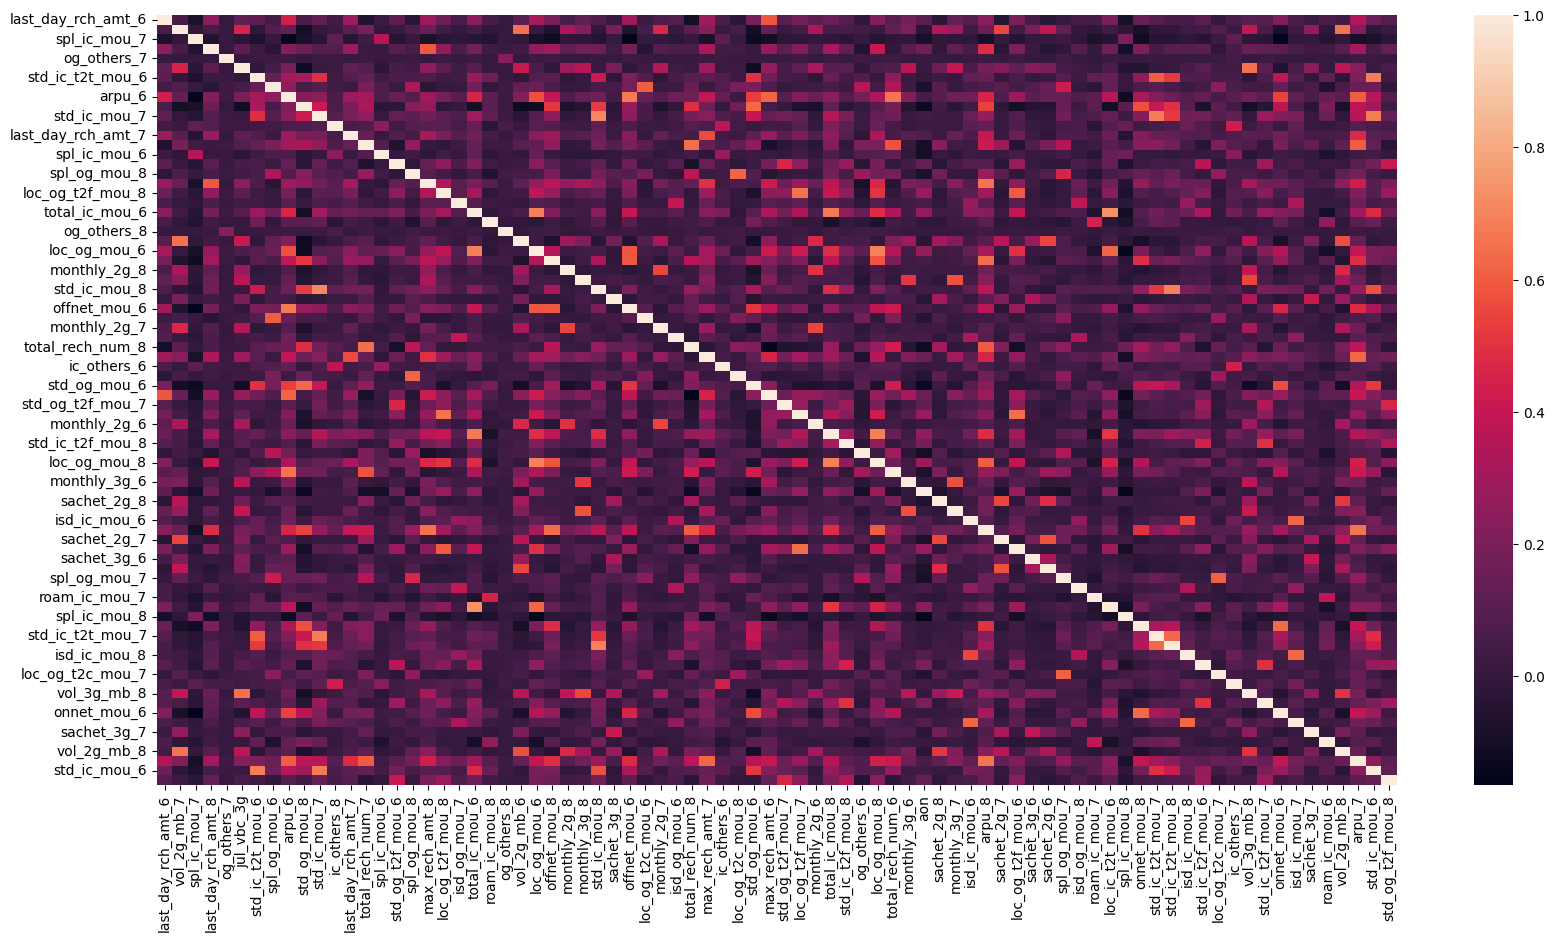

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
loct2m = list(filter(lambda x: re.search("loc.+t2m_mou", x), new_vars))
stdt2m = list(filter(lambda x: re.search("std.+t2m_mou", x), new_vars))
lic = list(filter(lambda x: re.search("loc_ic_mou", x), new_vars))
tramt = list(filter(lambda x: re.search("total_rech_amt", x), new_vars))
rog = list(filter(lambda x: re.search("roam_og_mou", x), new_vars))
stdOgt2t = list(filter(lambda x: re.search("std_og_t2t_mou", x), new_vars))
locOgt2t = list(filter(lambda x: re.search("loc_og_t2t_mou", x), new_vars))
locIct2f = list(filter(lambda x: re.search("loc_ic_t2f_mou", x), new_vars))

highCorrCols = loct2m + stdt2m+ lic+ tramt+ rog+ stdOgt2t+ locOgt2t+ locIct2f+ ["total_ic_mou_7", "total_og_mou_7",
                                                                      "vol_3g_mb_7", "vol_3g_mb_6",
                                                                      "loc_og_mou_7", "total_og_mou_8",
                                                                      "total_og_mou_6", "aug_vbc_3g",
                                                                      "jun_vbc_3g", "loc_ic_t2t_mou_7",
                                                                      "std_og_mou_7", "loc_ic_t2t_mou_8",
                                                                      "onnet_mou_7", "offnet_mou_7"]

notCorrCols = set(X_train_lognormalDf.columns)-set(highCorrCols)

plt.figure(figsize=(20,10))
sns.heatmap(X_train_lognormalDf[notCorrCols].corr(),annot = False)

corDf = X_train_lognormalDf[notCorrCols].corr().melt(ignore_index=False)

corDf1 = corDf[corDf.index!=corDf.variable]

corDf1.drop_duplicates(subset="value", inplace=True)

corDf1.sort_values(by="value", ascending=False).head(150)



<Axes: xlabel='churn_probability', ylabel='Count'>

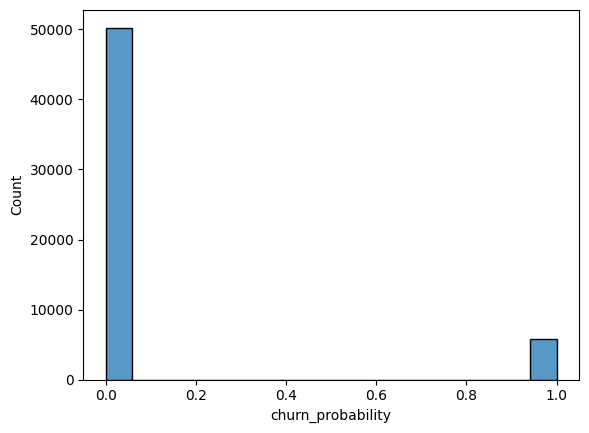

In [ ]:
#Distribution for the churn probability
sns.histplot(y_train)

In [ ]:
y_train.value_counts()

0    50258
1     5741
Name: churn_probability, dtype: int64

our training data is imbalanced so the accuracy of the prediction that only take to the account true positive and true negative may be too high and misleading. I will follow three methods to check for the results.
1. check another matrices
>*   use precision that consider the ration of true positive to the all the positive predictions
>*   AUC ROC curve can also be used to determine the relationship between true positive and false positive

2. under sampeling
>*  removing samples from the overrepresented class that would lead to losing lots of data
3. over sampeling
>*   Using SMOTE
>*   Using ADASYN

(11482, 124)
0    5741
1    5741
Name: churn_probability, dtype: int64


<Axes: xlabel='churn_probability', ylabel='Count'>

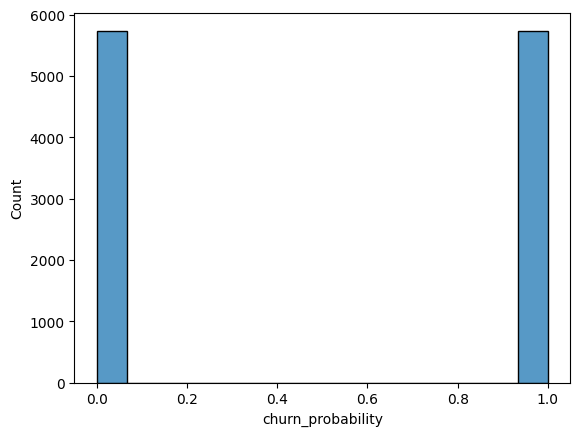

In [ ]:
# down sampeling:
from sklearn.utils import resample

sampleNum = y_train.value_counts().min()
sampleNum

y_downsampled0 = resample(y_train[y_train==0],
             replace=True,
             n_samples=sampleNum,
             random_state=42)

y_downsampled = pd.concat([y_downsampled0, y_train[y_train==1]], axis=0)


X_train_lognormalDf.index = X_train.index

X_downsampled = X_train_lognormalDf.loc[y_downsampled.index.tolist(),:]

print(X_downsampled.shape)
print(y_downsampled.value_counts())

sns.histplot(y_downsampled)


(100516, 124)
0    50258
1    50258
Name: churn_probability, dtype: int64


<Axes: xlabel='churn_probability', ylabel='Count'>

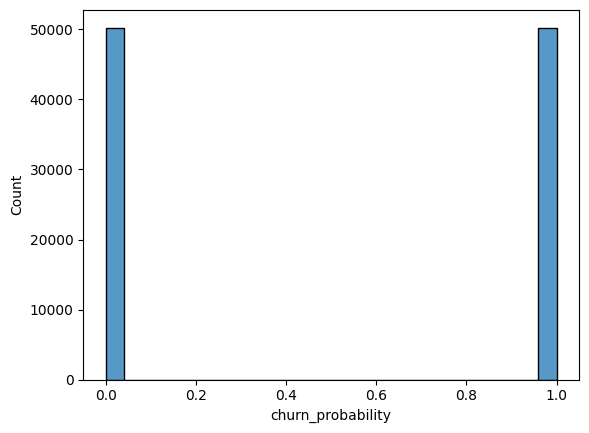

In [ ]:
# Over sampeling by SMOTE:

from imblearn.over_sampling import SMOTE

X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train_lognormalDf, y_train)

print(X_resampled_smote.shape)
print(y_resampled_smote.value_counts())

sns.histplot(y_resampled_smote)

(99988, 124)
0    50258
1    49730
Name: churn_probability, dtype: int64


<Axes: xlabel='churn_probability', ylabel='Count'>

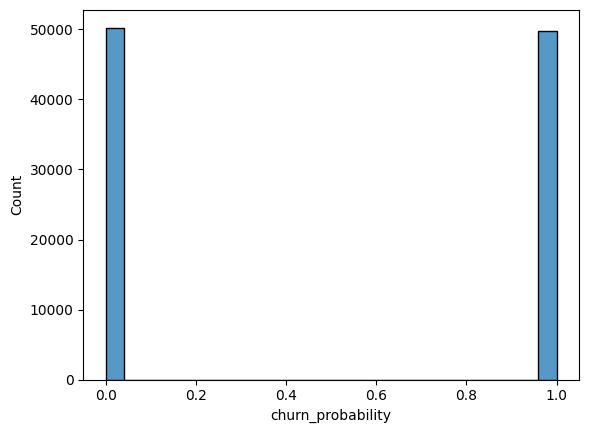

In [ ]:
# Over sampeling by ADASYN:
from imblearn.over_sampling import ADASYN

X_resampled_ada, y_resampled_ada = ADASYN().fit_resample(X_train_lognormalDf, y_train)

print(X_resampled_ada.shape)
print(y_resampled_ada.value_counts())

sns.histplot(y_resampled_ada)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

ADASYN will focus on the samples which are difficult to classify with a nearest-neighbors rule while regular SMOTE will not make any distinction. and down sampeling will cause lost of lots of data. So I'll focous on SMOTE here.

In [ ]:
# Hyper-parameters tunning for downsampled data

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20],
    'n_estimators': [10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1,
                           scoring="accuracy")

grid_search.fit(X_resampled_smote[notCorrCols], y_resampled_smote)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_best = grid_search.best_estimator_
rf_best


# rf_best = {"max_depth":20, "min_samples_leaf":5, "n_jobs":-1,
#                        "random_state":42}

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

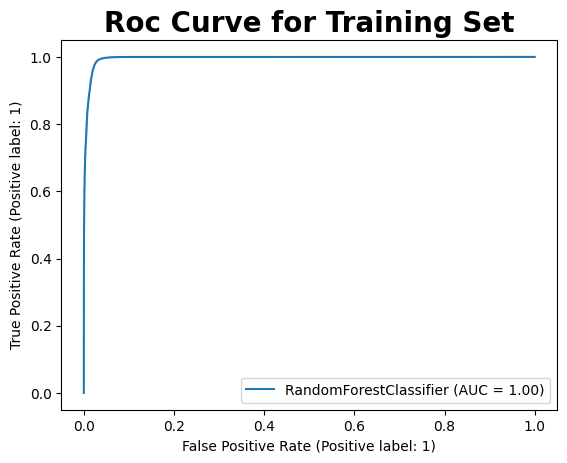

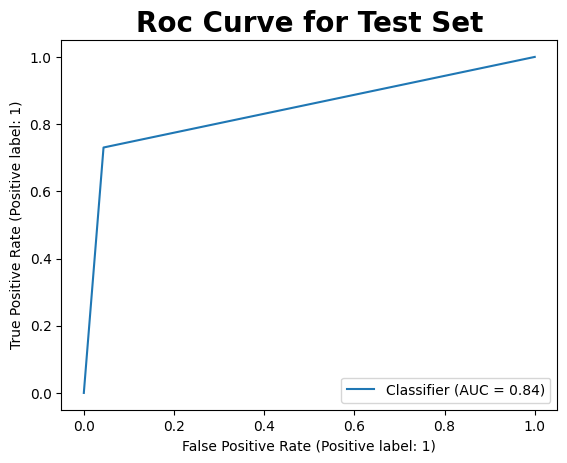

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12609
           1       0.65      0.73      0.69      1391

    accuracy                           0.93     14000
   macro avg       0.81      0.84      0.82     14000
weighted avg       0.94      0.93      0.94     14000

Best accuracy score: 0.9485654025229814


In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report

RocCurveDisplay.from_estimator(rf_best, X_resampled_smote[notCorrCols], y_resampled_smote)
plt.title("Roc Curve for Training Set", fontsize=20, fontweight="bold")
plt.show()

X_test_lognormalDf = pd.DataFrame(X_test_lognormal, columns=new_vars)
y_pred = grid_search.predict(X_test_lognormalDf[notCorrCols])

RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("Roc Curve for Test Set", fontsize=20, fontweight="bold")
plt.show()

print(classification_report(y_test, y_pred))
print("Best accuracy score:", grid_search.best_score_)

The accuracy score for the training set is very high and the accuracy score for the test set is very low. This is a sign of over fitting probably caused by removal of highly correlated features.

In [ ]:
rf_best_gridSearch = {"max_depth":20, "min_samples_leaf":5, "n_jobs":-1,
                       "random_state":42}
rf_bestTofit = RandomForestClassifier(**rf_best_gridSearch)
rf_bestTofit.fit(X_resampled_smote[notCorrCols], y_resampled_smote)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
feature_importances = pd.DataFrame(list(zip(notCorrCols, rf_bestTofit.feature_importances_)), columns= ["col", "importance"])
feature_importances.sort_values(by="importance", ascending=False)


<IPython.core.display.Javascript object>

col  importance
43      total_ic_mou_8    0.167216
21       roam_ic_mou_8    0.093130
46        loc_og_mou_8    0.086031
53              arpu_8    0.081050
3   last_day_rch_amt_8    0.058189
17      max_rech_amt_8    0.047312
28        std_ic_mou_8    0.038975
34    total_rech_num_8    0.030884
60       roam_ic_mou_7    0.020544
9         std_og_mou_8    0.016983
25        offnet_mou_8    0.015310
49                 aon    0.014834
18    loc_og_t2f_mou_8    0.014700
62        spl_ic_mou_8    0.013574
77              arpu_7    0.012856
63         onnet_mou_8    0.011299
20      total_ic_mou_6    0.011141
16        spl_og_mou_8    0.010975
58        spl_og_mou_7    0.009889
13    total_rech_num_7    0.009395
35      max_rech_amt_7    0.009300
76         vol_2g_mb_8    0.009133
65    std_ic_t2t_mou_8    0.009075
47    total_rech_num_6    0.008275
24        loc_og_mou_6    0.008217
12  last_day_rch_amt_7    0.008016
75       roam_ic_mou_6    0.007984
38        std_og_mou_6    0.007864
70         vol_3g_mb_8    0.007648
72         onnet_mou_6    0.007629
8               arpu_6    0.007196
30        offnet_mou_6    0.007077
61    loc_ic_t2t_mou_6    0.007018
64    std_ic_t2t_mou_7    0.006776
44    std_ic_t2f_mou_8    0.006375
39      max_rech_amt_6    0.005838
50         sachet_2g_8    0.005802
11         ic_others_8    0.005439
68    loc_og_t2c_mou_7    0.005361
10        std_ic_mou_7    0.005270
7         spl_og_mou_6    0.004898
0   last_day_rch_amt_6    0.004803
41    loc_og_t2f_mou_7    0.004659
6     std_ic_t2t_mou_6    0.004153
78        std_ic_mou_6    0.004109
37    loc_og_t2c_mou_8    0.003837
14        spl_ic_mou_6    0.003783
45         og_others_6    0.003683
2         spl_ic_mou_7    0.003631
55    loc_og_t2f_mou_6    0.003476
66        isd_ic_mou_8    0.003314
31    loc_og_t2c_mou_6    0.003199
54         sachet_2g_7    0.003105
71    std_ic_t2f_mou_7    0.002807
73        isd_ic_mou_7    0.002752
69         ic_others_7    0.002745
52        isd_ic_mou_6    0.002737
36         ic_others_6    0.002642
26        monthly_2g_8    0.002339
1          vol_2g_mb_7    0.002306
5           jul_vbc_3g    0.002030
23         vol_2g_mb_6    0.001955
67    std_ic_t2f_mou_6    0.001805
79    std_og_t2f_mou_8    0.001488
15    std_og_t2f_mou_6    0.001380
59        isd_og_mou_8    0.001331
32        monthly_2g_7    0.001276
57         sachet_2g_6    0.001243
33        isd_og_mou_6    0.001182
19        isd_og_mou_7    0.001145
27        monthly_3g_8    0.001081
40    std_og_t2f_mou_7    0.001023
48        monthly_3g_6    0.000797
42        monthly_2g_6    0.000761
29         sachet_3g_8    0.000752
74         sachet_3g_7    0.000730
51        monthly_3g_7    0.000705
56         sachet_3g_6    0.000642
22         og_others_8    0.000106
4          og_others_7    0.000012

<IPython.core.display.Javascript object>

<BarContainer object of 80 artists>

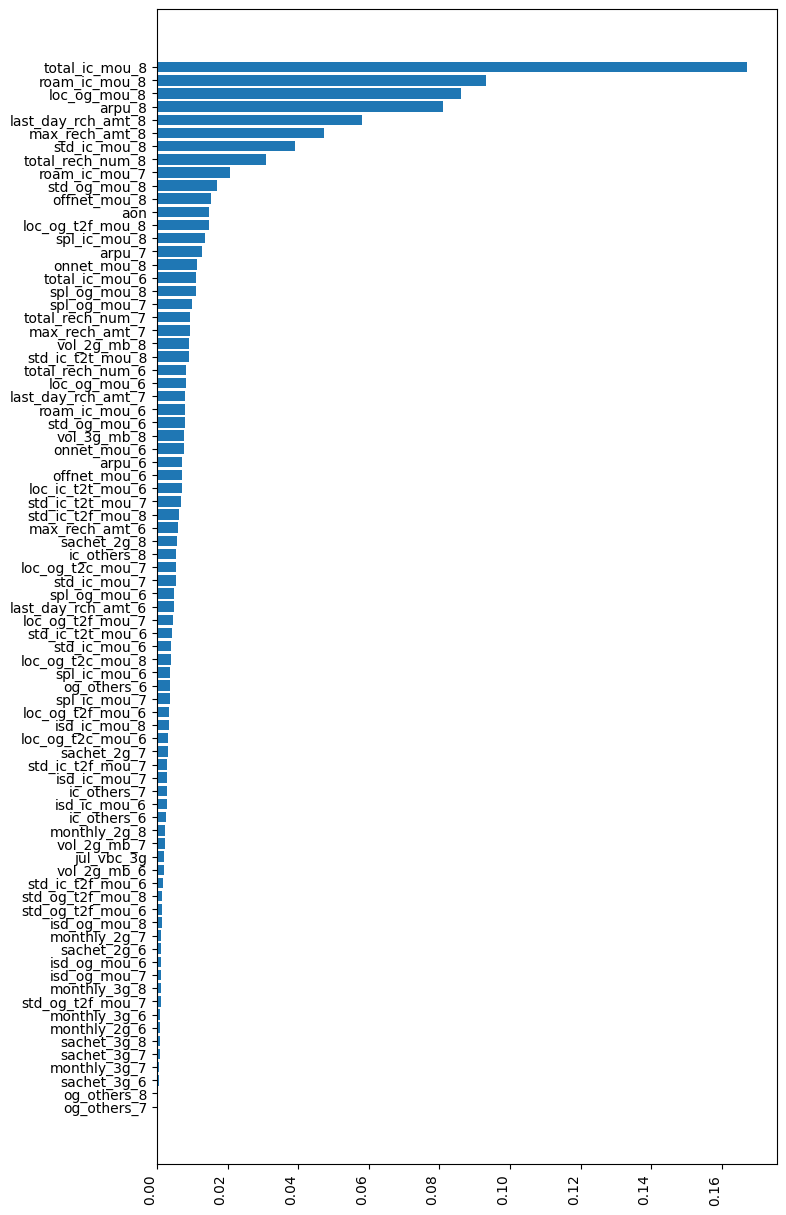

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

plt.figure(figsize=(8,15))
plt.xticks(rotation=90, ha='right')
feature_importances = feature_importances.sort_values(by="importance", ascending=True)
plt.barh(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

**Feature Enginearing**

In [ ]:
X_test_lognormalDf = pd.DataFrame(X_test_lognormal, columns=new_vars)

In [ ]:
# I have estimatd the ratio of those that identified highly correlated
import copy
X_resampled_smote2 = copy.copy(X_resampled_smote)
X_test_lognormalDf2 = copy.copy(X_test_lognormalDf)

locogt2m = list(filter(lambda x: re.search("loc_og_t2m_mou", x), new_vars))
locict2m = list(filter(lambda x: re.search("loc_ic_t2m_mou", x), new_vars))
locogt2t = list(filter(lambda x: re.search("loc_og_t2t_mou", x), new_vars))
locict2t = list(filter(lambda x: re.search("loc_ic_t2t_mou", x), new_vars))
locOg = list(filter(lambda x: re.search("loc.+og_mou", x), new_vars))
locIc = list(filter(lambda x: re.search("loc.+ic_mou", x), new_vars))

totalOg = list(filter(lambda x: re.search("total.+og_mou", x), new_vars))
totalIc = list(filter(lambda x: re.search("total.+ic_mou", x), new_vars))

X_resampled_smote2["ave_dailyUse"] = X_resampled_smote2[totalOg].sum(axis=1)/X_resampled_smote2["aon"]
X_test_lognormalDf2["ave_dailyUse"] = X_test_lognormalDf2[totalOg].sum(axis=1)/ X_test_lognormalDf2["aon"]

X_resampled_smote2["ave_loc_og_t2m_mou"] = X_resampled_smote2[locogt2m].sum(axis=1)/3
X_test_lognormalDf2["ave_loc_og_t2m_mou"] = X_test_lognormalDf2[locogt2m].sum(axis=1)/3

X_resampled_smote2["ave_loc_ic_t2m_mou"] = X_resampled_smote2[locict2m].sum(axis=1)/3
X_test_lognormalDf2["ave_loc_ic_t2m_mou"] = X_test_lognormalDf2[locict2m].sum(axis=1)/3

X_resampled_smote2["ave_loc_og_t2t_mou"] = X_resampled_smote2[locogt2t].sum(axis=1)/3
X_test_lognormalDf2["ave_loc_og_t2t_mou"] = X_test_lognormalDf2[locogt2t].sum(axis=1)/3

X_resampled_smote2["ave_loc_ic_t2t_mou"] = X_resampled_smote2[locict2t].sum(axis=1)/3
X_test_lognormalDf2["ave_loc_ic_t2t_mou"] = X_test_lognormalDf2[locict2t].sum(axis=1)/3

X_resampled_smote2["ave_loc_og_mou"] = X_resampled_smote2[locOg].sum(axis=1)/3
X_test_lognormalDf2["ave_loc_og_mou"] = X_test_lognormalDf2[locOg].sum(axis=1)/3

X_resampled_smote2["ave_loc_ic_mou"] = X_resampled_smote2[locIc].sum(axis=1)/3
X_test_lognormalDf2["ave_loc_ic_mou"] = X_test_lognormalDf2[locIc].sum(axis=1)/3

X_resampled_smote2["ave_total_og_mou"] = X_resampled_smote2[totalOg].sum(axis=1)/3
X_test_lognormalDf2["ave_total_og_mou"] = X_test_lognormalDf2[totalOg].sum(axis=1)/3

X_resampled_smote2["ave_total_ic_mou"] = X_resampled_smote2[totalIc].sum(axis=1)/3
X_test_lognormalDf2["ave_total_ic_mou"] = X_test_lognormalDf2[totalIc].sum(axis=1)/3

X_resampled_smote2["ratio_loc_og_t2m_mou"] = (X_resampled_smote2["ave_loc_og_t2m_mou"]/X_resampled_smote2["ave_loc_og_mou"])/X_resampled_smote2["ave_total_og_mou"]
X_test_lognormalDf2["ratio_loc_og_t2m_mou"] = (X_test_lognormalDf2["ave_loc_og_t2m_mou"]/X_test_lognormalDf2["ave_loc_og_mou"])/X_test_lognormalDf2["ave_total_og_mou"]

X_resampled_smote2["ratio_loc_ic_t2m_mou"] = (X_resampled_smote2["ave_loc_ic_t2m_mou"]/X_resampled_smote2["ave_loc_ic_mou"])/X_resampled_smote2["ave_total_ic_mou"]
X_test_lognormalDf2["ratio_loc_ic_t2m_mou"] = (X_test_lognormalDf2["ave_loc_ic_t2m_mou"]/X_test_lognormalDf2["ave_loc_ic_mou"])/X_test_lognormalDf2["ave_total_ic_mou"]

X_resampled_smote2["ratio_loc_og_t2t_mou"] = (X_resampled_smote2["ave_loc_og_t2t_mou"]/X_resampled_smote2["ave_loc_og_mou"])/X_resampled_smote2["ave_total_og_mou"]
X_test_lognormalDf2["ratio_loc_og_t2t_mou"] = (X_test_lognormalDf2["ave_loc_og_t2t_mou"]/X_test_lognormalDf2["ave_loc_og_mou"])/X_test_lognormalDf2["ave_total_og_mou"]

X_resampled_smote2["ratio_loc_ic_t2t_mou"] = (X_resampled_smote2["ave_loc_ic_t2t_mou"]/X_resampled_smote2["ave_loc_ic_mou"])/X_resampled_smote2["ave_total_ic_mou"]
X_test_lognormalDf2["ratio_loc_ic_t2t_mou"] = (X_test_lognormalDf2["ave_loc_ic_t2t_mou"]/X_test_lognormalDf2["ave_loc_ic_mou"])/X_test_lognormalDf2["ave_total_ic_mou"]

X_resampled_smote2.drop(columns=["ave_loc_og_t2m_mou", "ave_loc_ic_t2m_mou", "ave_loc_og_t2t_mou", "ave_loc_ic_t2t_mou", "ave_loc_og_mou",
                                 "ave_total_ic_mou", "ave_total_og_mou", "ave_loc_ic_mou"]+ locogt2m+ locict2m + locogt2t+ locict2t+ locOg + locIc+ totalOg+ totalIc, inplace=True)

X_test_lognormalDf2.drop(columns=["ave_loc_og_t2m_mou", "ave_loc_ic_t2m_mou", "ave_loc_og_t2t_mou", "ave_loc_ic_t2t_mou", "ave_loc_og_mou",
                                 "ave_total_ic_mou", "ave_total_og_mou", "ave_loc_ic_mou"]+ locogt2m+ locict2m + locogt2t+ locict2t+ locOg + locIc+ totalOg+ totalIc, inplace=True)

X_test_lognormalDf2.columns.tolist()

stdict2m = list(filter(lambda x: re.search("std_ic_t2m_mou", x), new_vars))
stdict2t = list(filter(lambda x: re.search("std_ic_t2t_mou", x), new_vars))

stdogt2m = list(filter(lambda x: re.search("std_og_t2m_mou", x), new_vars))
stdogt2t = list(filter(lambda x: re.search("std_og_t2t_mou", x), new_vars))

stdIc = list(filter(lambda x: re.search("std_ic_mou", x), new_vars))
stdOg = list(filter(lambda x: re.search("std_og_mou", x), new_vars))

X_resampled_smote2["ave_std_og_t2m_mou"] = X_resampled_smote2[stdogt2m].sum(axis=1)/3
X_test_lognormalDf2["ave_std_og_t2m_mou"] = X_test_lognormalDf2[stdogt2m].sum(axis=1)/3

X_resampled_smote2["ave_std_ic_t2m_mou"] = X_resampled_smote2[stdict2m].sum(axis=1)/3
X_test_lognormalDf2["ave_std_ic_t2m_mou"] = X_test_lognormalDf2[stdict2m].sum(axis=1)/3

X_resampled_smote2["ave_std_og_t2t_mou"] = X_resampled_smote2[stdogt2t].sum(axis=1)/3
X_test_lognormalDf2["ave_std_og_t2t_mou"] = X_test_lognormalDf2[stdogt2t].sum(axis=1)/3

X_resampled_smote2["ave_std_ic_t2t_mou"] = X_resampled_smote2[stdict2t].sum(axis=1)/3
X_test_lognormalDf2["ave_std_ic_t2t_mou"] = X_test_lognormalDf2[stdict2t].sum(axis=1)/3

X_resampled_smote2["ave_std_og_mou"] = X_resampled_smote2[stdOg].sum(axis=1)/3
X_test_lognormalDf2["ave_std_og_mou"] = X_test_lognormalDf2[stdOg].sum(axis=1)/3

X_resampled_smote2["ave_std_ic_mou"] = X_resampled_smote2[stdIc].sum(axis=1)/3
X_test_lognormalDf2["ave_std_ic_mou"] = X_test_lognormalDf2[stdIc].sum(axis=1)/3

X_resampled_smote2["ratio_std_og_t2m_mou"] = X_resampled_smote2["ave_std_og_t2m_mou"]/X_resampled_smote2["ave_std_og_mou"]
X_test_lognormalDf2["ratio_std_og_t2m_mou"] = X_test_lognormalDf2["ave_std_og_t2m_mou"]/X_test_lognormalDf2["ave_std_og_mou"]

X_resampled_smote2["ratio_std_ic_t2m_mou"] = X_resampled_smote2["ave_std_ic_t2m_mou"]/X_resampled_smote2["ave_std_ic_mou"]
X_test_lognormalDf2["ratio_std_ic_t2m_mou"] = X_test_lognormalDf2["ave_std_ic_t2m_mou"]/X_test_lognormalDf2["ave_std_ic_mou"]

X_resampled_smote2["ratio_std_og_t2t_mou"] = X_resampled_smote2["ave_std_og_t2t_mou"]/X_resampled_smote2["ave_std_og_mou"]
X_test_lognormalDf2["ratio_std_og_t2t_mou"] = X_test_lognormalDf2["ave_std_og_t2t_mou"]/X_test_lognormalDf2["ave_std_og_mou"]

X_resampled_smote2["ratio_std_ic_t2t_mou"] = X_resampled_smote2["ave_std_ic_t2t_mou"]/X_resampled_smote2["ave_std_ic_mou"]
X_test_lognormalDf2["ratio_std_ic_t2t_mou"] = X_test_lognormalDf2["ave_std_ic_t2t_mou"]/X_test_lognormalDf2["ave_std_ic_mou"]

X_resampled_smote2.drop(columns=["ave_std_og_t2m_mou", "ave_std_ic_t2m_mou", "ave_std_og_t2t_mou", "ave_std_ic_t2t_mou", "ave_std_og_mou",
                                 "ave_std_ic_mou", "aon"]+ stdogt2m+ stdict2m+ stdogt2t+ stdict2t+ stdOg + stdIc, inplace=True)

X_test_lognormalDf2.drop(columns=["ave_std_og_t2m_mou", "ave_std_ic_t2m_mou", "ave_std_og_mou", "ave_std_ic_t2t_mou", "ave_std_og_mou",
                                 "ave_std_ic_mou", "aon"]+ stdogt2m+ stdict2m + stdogt2t+ stdict2t+ stdOg + stdIc, inplace=True)


arpu = list(filter(lambda x: re.search("arpu", x), new_vars))
totalRech = list(filter(lambda x: re.search("total_rech_amt", x), new_vars))

X_resampled_smote2["ave_arpu"] = X_resampled_smote2[arpu].sum(axis=1)/3
X_test_lognormalDf2["ave_arpu"] = X_test_lognormalDf2[arpu].sum(axis=1)/3

X_resampled_smote2["total_rech"] = X_resampled_smote2[totalRech].sum(axis=1)/3
X_test_lognormalDf2["total_rech"] = X_test_lognormalDf2[totalRech].sum(axis=1)/3

X_resampled_smote2["ratio_rev"] = X_resampled_smote2["ave_arpu"]/X_resampled_smote2["total_rech"]
X_test_lognormalDf2["ratio_rev"] = X_test_lognormalDf2["ave_arpu"]/ X_test_lognormalDf2["total_rech"]


X_resampled_smote2.drop(columns=["total_rech", "ave_arpu"]+ arpu+ totalRech, inplace=True)

X_test_lognormalDf2.drop(columns=["total_rech", "ave_arpu"]+ arpu+ totalRech, inplace=True)

onnet = list(filter(lambda x: re.search("onnet_mou", x), new_vars))
ofnet = list(filter(lambda x: re.search("offnet_mou", x), new_vars))

X_resampled_smote2["ave_onnet_mou"] = X_resampled_smote2[onnet].sum(axis=1)/3
X_test_lognormalDf2["ave_onnet_mou"] = X_test_lognormalDf2[onnet].sum(axis=1)/3

X_resampled_smote2["ave_offnet_mou"] = X_resampled_smote2[ofnet].sum(axis=1)/3
X_test_lognormalDf2["ave_offnet_mou"] = X_test_lognormalDf2[ofnet].sum(axis=1)/3

X_resampled_smote2["ration_onnet_offnet"] = X_resampled_smote2["ave_onnet_mou"]/X_resampled_smote2["ave_offnet_mou"]
X_test_lognormalDf2["ration_onnet_offnet"] = X_test_lognormalDf2["ave_onnet_mou"]/X_test_lognormalDf2["ave_offnet_mou"]

X_resampled_smote2.drop(columns=["ave_offnet_mou", "ave_onnet_mou"]+ onnet+ ofnet, inplace=True)
X_test_lognormalDf2.drop(columns=["ave_offnet_mou", "ave_onnet_mou"]+ onnet+ ofnet, inplace=True)

roamIc = list(filter(lambda x: re.search("roam_ic_mou", x), new_vars))
roamOg = list(filter(lambda x: re.search("roam_og_mou", x), new_vars))

X_resampled_smote2["ave_roam_ic"] = X_resampled_smote2[roamIc].sum(axis=1)/3
X_test_lognormalDf2["ave_roam_ic"] = X_test_lognormalDf2[roamIc].sum(axis=1)/3

X_resampled_smote2["ave_roam_og"] = X_resampled_smote2[roamOg].sum(axis=1)/3
X_test_lognormalDf2["ave_roam_og"] = X_test_lognormalDf2[roamOg].sum(axis=1)/3

X_resampled_smote2["ratio_ic_og"] = X_resampled_smote2["ave_roam_ic"]/X_resampled_smote2["ave_roam_og"]
X_test_lognormalDf2["ratio_ic_og"] = X_test_lognormalDf2["ave_roam_ic"]/X_test_lognormalDf2["ave_roam_og"]

X_resampled_smote2.drop(columns=["ave_roam_og", "ave_roam_ic"]+ roamOg+ roamIc, inplace=True)
X_test_lognormalDf2.drop(columns=["ave_roam_og", "ave_roam_ic"]+ roamOg+ roamIc, inplace=True)

locogt2f = list(filter(lambda x: re.search("loc_og_t2f", x), new_vars))
locict2f = list(filter(lambda x: re.search("loc_ic_t2f", x), new_vars))

X_resampled_smote2["ave_ic_t2f"] = X_resampled_smote2[locict2f].sum(axis=1)/3
X_test_lognormalDf2["ave_ic_t2f"] = X_test_lognormalDf2[locict2f].sum(axis=1)/3

X_resampled_smote2["ave_og_t2f"] = X_resampled_smote2[locogt2f].sum(axis=1)/3
X_test_lognormalDf2["ave_og_t2f"] = X_test_lognormalDf2[locogt2f].sum(axis=1)/3

X_resampled_smote2["ratio_loc_ic_og_t2f"] = X_resampled_smote2["ave_ic_t2f"]/X_resampled_smote2["ave_og_t2f"]
X_test_lognormalDf2["ratio_loc_ic_og_t2f"] = X_test_lognormalDf2["ave_ic_t2f"]/X_test_lognormalDf2["ave_og_t2f"]

X_resampled_smote2.drop(columns=["ave_og_t2f", "ave_ic_t2f"]+ locict2f+ locogt2f, inplace=True)
X_test_lognormalDf2.drop(columns=["ave_og_t2f", "ave_ic_t2f"]+ locict2f+ locogt2f, inplace=True)

stdogt2f = list(filter(lambda x: re.search("std_og_t2f", x), new_vars))
stdict2f = list(filter(lambda x: re.search("std_ic_t2f", x), new_vars))

X_resampled_smote2["ave_std_ic_t2f"] = X_resampled_smote2[stdict2f].sum(axis=1)/3
X_test_lognormalDf2["ave_std_ic_t2f"] = X_test_lognormalDf2[stdict2f].sum(axis=1)/3

X_resampled_smote2["ave_std_og_t2f"] = X_resampled_smote2[stdogt2f].sum(axis=1)/3
X_test_lognormalDf2["ave_std_og_t2f"] = X_test_lognormalDf2[stdogt2f].sum(axis=1)/3

X_resampled_smote2["ratio_std_ic_og_t2f"] = X_resampled_smote2["ave_std_ic_t2f"]/X_resampled_smote2["ave_std_og_t2f"]
X_test_lognormalDf2["ratio_std_ic_og_t2f"] = X_test_lognormalDf2["ave_std_ic_t2f"]/X_test_lognormalDf2["ave_std_og_t2f"]

X_resampled_smote2.drop(columns=["ave_std_og_t2f", "ave_std_ic_t2f"]+ stdict2f+ stdogt2f, inplace=True)
X_test_lognormalDf2.drop(columns=["ave_std_og_t2f", "ave_std_ic_t2f"]+ stdict2f+ stdogt2f, inplace=True)


isdog = list(filter(lambda x: re.search("isd_og_mou", x), new_vars))
isdic = list(filter(lambda x: re.search("isd_ic_mou", x), new_vars))

X_resampled_smote2["ave_isdic"] = X_resampled_smote2[isdic].sum(axis=1)/3
X_test_lognormalDf2["ave_isdic"] = X_test_lognormalDf2[isdic].sum(axis=1)/3

X_resampled_smote2["ave_isdog"] = X_resampled_smote2[isdog].sum(axis=1)/3
X_test_lognormalDf2["ave_isdog"] = X_test_lognormalDf2[isdog].sum(axis=1)/3

X_resampled_smote2["ratio_isd_ic_og"] = X_resampled_smote2["ave_isdic"]/X_resampled_smote2["ave_isdog"]
X_test_lognormalDf2["ratio_isd_ic_og"] = X_test_lognormalDf2["ave_isdic"]/X_test_lognormalDf2["ave_isdog"]

X_resampled_smote2.drop(columns=["ave_isdog", "ave_isdic"]+ isdic+ isdog, inplace=True)
X_test_lognormalDf2.drop(columns=["ave_isdog", "ave_isdic"]+ isdic+ isdog, inplace=True)


splog = list(filter(lambda x: re.search("spl_og_mou", x), new_vars))
splic = list(filter(lambda x: re.search("spl_ic_mou", x), new_vars))

X_resampled_smote2["ave_splic"] = X_resampled_smote2[splic].sum(axis=1)/3
X_test_lognormalDf2["ave_splic"] = X_test_lognormalDf2[splic].sum(axis=1)/3

X_resampled_smote2["ave_splog"] = X_resampled_smote2[splog].sum(axis=1)/3
X_test_lognormalDf2["ave_splog"] = X_test_lognormalDf2[splog].sum(axis=1)/3

X_resampled_smote2["ratio_spl_ic_og"] = X_resampled_smote2["ave_splic"]/X_resampled_smote2["ave_splog"]
X_test_lognormalDf2["ratio_spl_ic_og"] = X_test_lognormalDf2["ave_splic"]/X_test_lognormalDf2["ave_splog"]

X_resampled_smote2.drop(columns=["ave_splog", "ave_splic"]+ splic+ splog, inplace=True)
X_test_lognormalDf2.drop(columns=["ave_splog", "ave_splic"]+ splic+ splog, inplace=True)


othersog = list(filter(lambda x: re.search("og_others", x), new_vars))
othersic = list(filter(lambda x: re.search("ic_others", x), new_vars))

X_resampled_smote2["ave_othersic"] = X_resampled_smote2[othersic].sum(axis=1)/3
X_test_lognormalDf2["ave_othersic"] = X_test_lognormalDf2[othersic].sum(axis=1)/3

X_resampled_smote2["ave_othersog"] = X_resampled_smote2[othersog].sum(axis=1)/3
X_test_lognormalDf2["ave_othersog"] = X_test_lognormalDf2[othersog].sum(axis=1)/3

X_resampled_smote2["ratio_others_ic_og"] = X_resampled_smote2["ave_othersic"]/X_resampled_smote2["ave_othersog"]
X_test_lognormalDf2["ratio_others_ic_og"] = X_test_lognormalDf2["ave_othersic"]/X_test_lognormalDf2["ave_othersog"]

X_resampled_smote2.drop(columns=["ave_othersog", "ave_othersic"]+ othersic+ othersog, inplace=True)
X_test_lognormalDf2.drop(columns=["ave_othersog", "ave_othersic"]+ othersic+ othersog, inplace=True)


locogt2c = list(filter(lambda x: re.search("loc_og_t2c", x), new_vars))
locict2c = list(filter(lambda x: re.search("loc_ic_t2c", x), new_vars))
X_resampled_smote2["ave_ic_t2c"] = X_resampled_smote2[locict2c].sum(axis=1)/3
X_test_lognormalDf2["ave_ic_t2c"] = X_test_lognormalDf2[locict2c].sum(axis=1)/3

X_resampled_smote2["ave_og_t2c"] = X_resampled_smote2[locogt2c].sum(axis=1)/3
X_test_lognormalDf2["ave_og_t2c"] = X_test_lognormalDf2[locogt2c].sum(axis=1)/3

X_resampled_smote2["ratio_ic_og_t2c"] = X_resampled_smote2["ave_ic_t2c"]/X_resampled_smote2["ave_og_t2c"]
X_test_lognormalDf2["ratio_ic_og_t2c"] = X_test_lognormalDf2["ave_ic_t2c"]/X_test_lognormalDf2["ave_og_t2c"]

X_resampled_smote2.drop(columns=["ave_og_t2c", "ave_ic_t2c"]+ locict2c+ locogt2c, inplace=True)
X_test_lognormalDf2.drop(columns=["ave_og_t2c", "ave_ic_t2c"]+ locict2c+ locogt2c, inplace=True)


vbc = list(filter(lambda x: re.search("vbc_3g", x), new_vars))
X_resampled_smote2["ave_vbc"] = X_resampled_smote2[vbc].sum(axis=1)/3
X_test_lognormalDf2["ave_vbc"] = X_test_lognormalDf2[vbc].sum(axis=1)/3
X_resampled_smote2.drop(columns=vbc, inplace=True)
X_test_lognormalDf2.drop(columns=vbc, inplace=True)

lastDay = list(filter(lambda x: re.search("last_day_rch_amt", x), new_vars))
X_resampled_smote2["ave_lastDay"] = X_resampled_smote2[lastDay].sum(axis=1)/3
X_test_lognormalDf2["ave_lastDay"] = X_test_lognormalDf2[lastDay].sum(axis=1)/3
X_resampled_smote2.drop(columns=lastDay, inplace=True)
X_test_lognormalDf2.drop(columns=lastDay, inplace=True)

vol2g = list(filter(lambda x: re.search("vol_2g_mb", x), new_vars))
X_resampled_smote2["ave_vol2g"] = X_resampled_smote2[vol2g].sum(axis=1)/3
X_test_lognormalDf2["ave_vol2g"] = X_test_lognormalDf2[vol2g].sum(axis=1)/3
X_resampled_smote2.drop(columns=vol2g, inplace=True)
X_test_lognormalDf2.drop(columns=vol2g, inplace=True)

vol3g = list(filter(lambda x: re.search("vol_3g_mb", x), new_vars))
X_resampled_smote2["ave_vol3g"] = X_resampled_smote2[vol3g].sum(axis=1)/3
X_test_lognormalDf2["ave_vol3g"] = X_test_lognormalDf2[vol3g].sum(axis=1)/3
X_resampled_smote2.drop(columns=vol3g, inplace=True)
X_test_lognormalDf2.drop(columns=vol3g, inplace=True)


monthly3g = list(filter(lambda x: re.search("monthly_3g", x), new_vars))
X_resampled_smote2["ave_monthly3g"] = X_resampled_smote2[monthly3g].sum(axis=1)/3
X_test_lognormalDf2["ave_monthly3g"] = X_test_lognormalDf2[monthly3g].sum(axis=1)/3
X_resampled_smote2.drop(columns=monthly3g, inplace=True)
X_test_lognormalDf2.drop(columns=monthly3g, inplace=True)

monthly2g = list(filter(lambda x: re.search("monthly_2g", x), new_vars))
X_resampled_smote2["ave_monthly2g"] = X_resampled_smote2[monthly2g].sum(axis=1)/3
X_test_lognormalDf2["ave_monthly2g"] = X_test_lognormalDf2[monthly2g].sum(axis=1)/3
X_resampled_smote2.drop(columns=monthly2g, inplace=True)
X_test_lognormalDf2.drop(columns=monthly2g, inplace=True)

sachet2g = list(filter(lambda x: re.search("sachet_2g", x), new_vars))
X_resampled_smote2["ave_sachet2g"] = X_resampled_smote2[sachet2g].sum(axis=1)/3
X_test_lognormalDf2["ave_sachet2g"] = X_test_lognormalDf2[sachet2g].sum(axis=1)/3
X_resampled_smote2.drop(columns=sachet2g, inplace=True)
X_test_lognormalDf2.drop(columns=sachet2g, inplace=True)

sachet3g = list(filter(lambda x: re.search("sachet_3g", x), new_vars))
X_resampled_smote2["ave_sachet3g"] = X_resampled_smote2[sachet3g].sum(axis=1)/3
X_test_lognormalDf2["ave_sachet3g"] = X_test_lognormalDf2[sachet3g].sum(axis=1)/3
X_resampled_smote2.drop(columns=sachet3g, inplace=True)
X_test_lognormalDf2.drop(columns=sachet3g, inplace=True)


rechNum = list(filter(lambda x: re.search("total_rech_num", x), new_vars))
X_resampled_smote2["ave_rechNum"] = X_resampled_smote2[rechNum].sum(axis=1)/3
X_test_lognormalDf2["ave_rechNum"] = X_test_lognormalDf2[rechNum].sum(axis=1)/3
X_resampled_smote2.drop(columns=rechNum, inplace=True)
X_test_lognormalDf2.drop(columns=rechNum, inplace=True)

maxRech = list(filter(lambda x: re.search("max_rech_amt", x), new_vars))
X_resampled_smote2["maxRech"] = X_resampled_smote2[maxRech].max(axis=1)
X_test_lognormalDf2["maxRech"] = X_test_lognormalDf2[maxRech].max(axis=1)
X_resampled_smote2.drop(columns=maxRech, inplace=True)
X_test_lognormalDf2.drop(columns=maxRech, inplace=True)

X_test_lognormalDf2.columns.tolist()



['ave_dailyUse',
 'ratio_loc_og_t2m_mou',
 'ratio_loc_ic_t2m_mou',
 'ratio_loc_og_t2t_mou',
 'ratio_loc_ic_t2t_mou',
 'ave_std_og_t2t_mou',
 'ratio_std_og_t2m_mou',
 'ratio_std_ic_t2m_mou',
 'ratio_std_og_t2t_mou',
 'ratio_std_ic_t2t_mou',
 'ratio_rev',
 'ration_onnet_offnet',
 'ratio_ic_og',
 'ratio_loc_ic_og_t2f',
 'ratio_std_ic_og_t2f',
 'ratio_isd_ic_og',
 'ratio_spl_ic_og',
 'ratio_others_ic_og',
 'ratio_ic_og_t2c',
 'ave_vbc',
 'ave_lastDay',
 'ave_vol2g',
 'ave_vol3g',
 'ave_monthly3g',
 'ave_monthly2g',
 'ave_sachet2g',
 'ave_sachet3g',
 'ave_rechNum',
 'maxRech']

In [ ]:
# Hyper-parameters tunning for downsampled data

rf2 = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20],
    'n_estimators': [10, 25, 50, 100]
}

grid_search2 = GridSearchCV(estimator=rf2,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1,
                           scoring="accuracy")

grid_search2.fit(X_resampled_smote2, y_resampled_smote)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_best2 = grid_search2.best_estimator_
rf_best2

# rf_best = {"max_depth":20, "min_samples_leaf":5, "n_jobs":-1,
#                        "random_state":42}

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

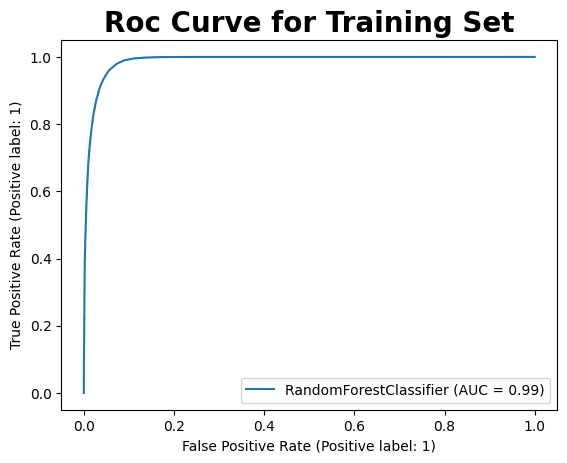

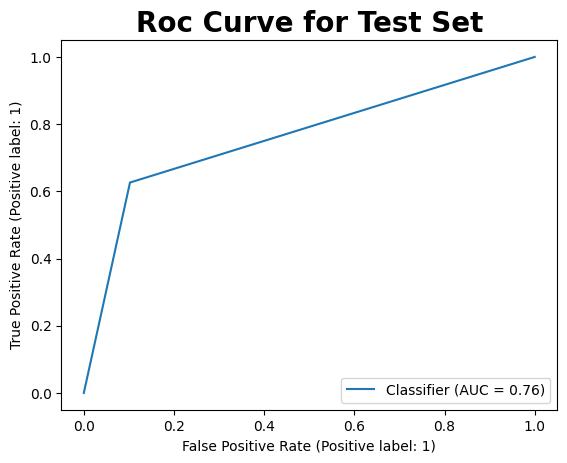

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     12609
           1       0.40      0.63      0.49      1391

    accuracy                           0.87     14000
   macro avg       0.68      0.76      0.71     14000
weighted avg       0.90      0.87      0.88     14000

Best accuracy score: 0.8996179712682558


In [ ]:

RocCurveDisplay.from_estimator(rf_best2, X_resampled_smote2, y_resampled_smote)
plt.title("Roc Curve for Training Set", fontsize=20, fontweight="bold")
plt.show()

y_pred = grid_search2.predict(X_test_lognormalDf2[X_resampled_smote2.columns.tolist()])

RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("Roc Curve for Test Set", fontsize=20, fontweight="bold")
plt.show()

print(classification_report(y_test, y_pred))
print("Best accuracy score:", grid_search2.best_score_)

Now our training accuracy is 0.89 and testing accuracy is 0.87. which is a good sine. Now we need to check the the accuracy of predicting all the churn costumers. For this idea precission 0.4 will be used to identify what ratio of of detected churn costumers are actually churn. and recall 0.63 will tell us what ratio of the churns the algorithm was successfully detected. basedon these matrices while the accuracy was high the algorithm was not able to accurately predict out churn costumers.

In [ ]:
rf_best_gridSearch2 = {"max_depth":20, "min_samples_leaf":5, "n_jobs":-1,
                       "random_state":42}
rf_bestTofit2 = RandomForestClassifier(**rf_best_gridSearch2)
rf_bestTofit2.fit(X_resampled_smote2, y_resampled_smote)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
feature_importances2 = pd.DataFrame(list(zip(X_test_lognormalDf2.columns, rf_bestTofit2.feature_importances_)), columns= ["col", "importance"])
feature_importances2.sort_values(by="importance", ascending=False)


<IPython.core.display.Javascript object>

col  importance
2   ratio_loc_ic_t2m_mou    0.112055
4   ratio_loc_ic_t2t_mou    0.092310
11   ration_onnet_offnet    0.078419
19               ave_vbc    0.077732
12           ratio_ic_og    0.071815
27           ave_rechNum    0.062482
15       ratio_isd_ic_og    0.058314
1   ratio_loc_og_t2m_mou    0.043487
3   ratio_loc_og_t2t_mou    0.042825
16       ratio_spl_ic_og    0.033509
26          ave_sachet3g    0.033188
13   ratio_loc_ic_og_t2f    0.028095
24         ave_monthly2g    0.027703
0           ave_dailyUse    0.027386
9   ratio_std_ic_t2t_mou    0.022717
7   ratio_std_ic_t2m_mou    0.020094
20           ave_lastDay    0.020040
8   ratio_std_og_t2t_mou    0.019880
6   ratio_std_og_t2m_mou    0.019439
5     ave_std_og_t2t_mou    0.018403
10             ratio_rev    0.018072
23         ave_monthly3g    0.017118
21             ave_vol2g    0.015658
18       ratio_ic_og_t2c    0.014162
14   ratio_std_ic_og_t2f    0.014032
25          ave_sachet2g    0.005622
22             ave_vol3g    0.005442
17    ratio_others_ic_og    0.000000

<IPython.core.display.Javascript object>

<BarContainer object of 28 artists>

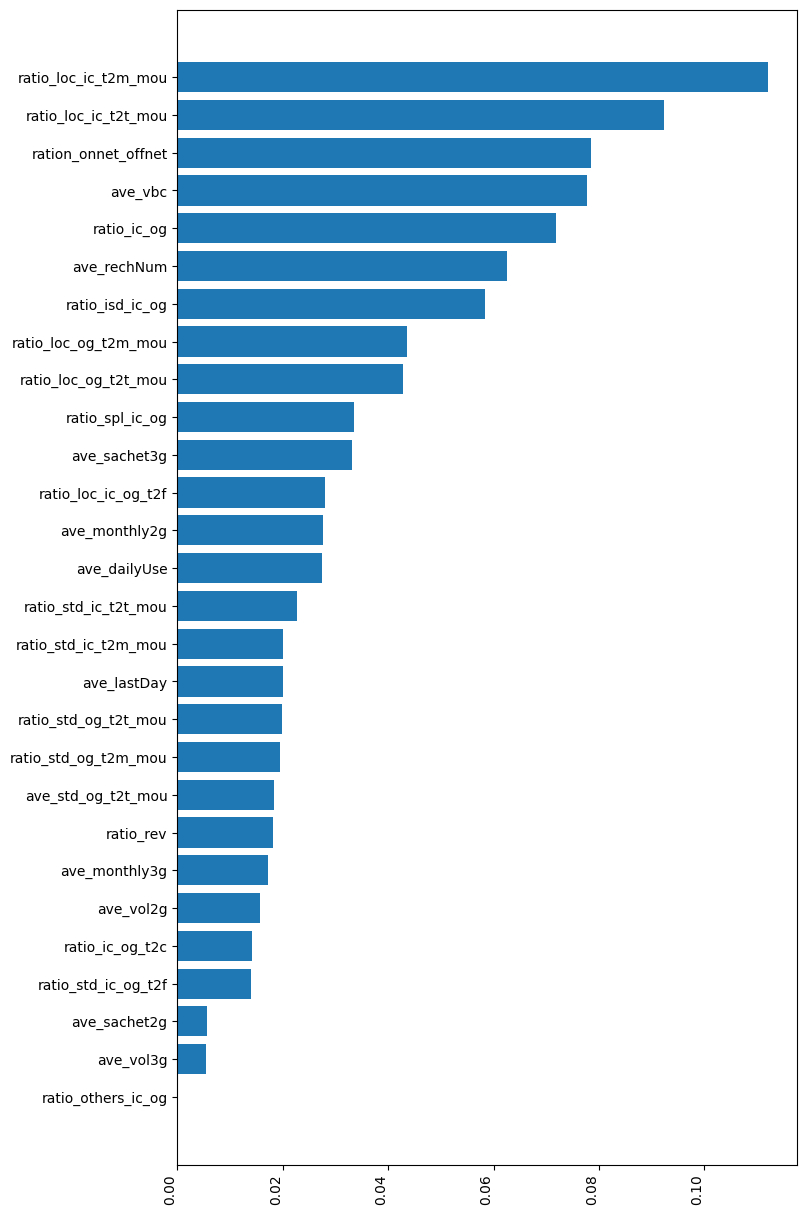

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

plt.figure(figsize=(8,15))
plt.xticks(rotation=90, ha='right')
feature_importances = feature_importances2.sort_values(by="importance", ascending=True)
plt.barh(feature_importances['col'], feature_importances['importance'])

# **Using feature extraction**

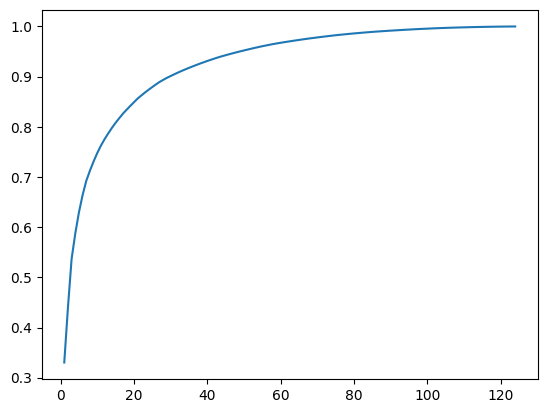

In [ ]:
pca = PCA()
pca = pca.fit(X_resampled_smote)

# scree plot to find the best component number
var_cumu = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(var_cumu)+1), var_cumu)


in about 20 component the PCA was able to cover more than 80% of the variation in our data. So I have chosen component number of 20 for PCA

<Axes: >

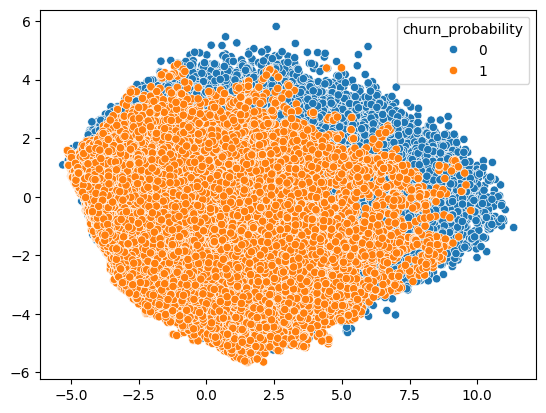

In [ ]:
pc2 = PCA(n_components=  20, random_state=42)
pc2 = pc2.fit(X_resampled_smote)
pca_components = pc2.transform(X_resampled_smote)

sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_resampled_smote)

<Axes: >

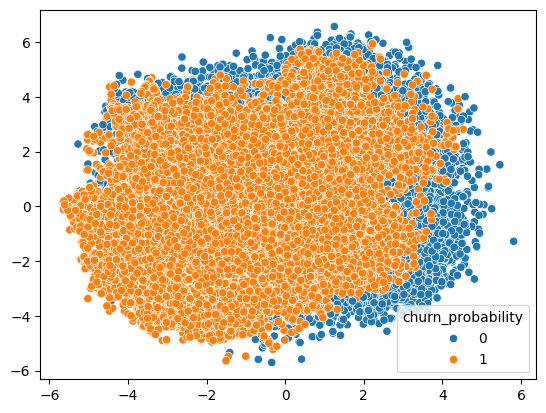

In [ ]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_resampled_smote)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [ ]:
rf3 = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20],
    'n_estimators': [10, 25, 50, 100]
}

grid_search3 = GridSearchCV(estimator=rf3,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1,
                           scoring="accuracy")

grid_search3.fit(pca_components, y_resampled_smote)

# rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# rf.fit(pca_components, y_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_best3 = grid_search3.best_estimator_
rf_best3

# rf_best3 = {"max_depth":20, "min_samples_leaf":5, "n_jobs":-1,
#                        "random_state":42}

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

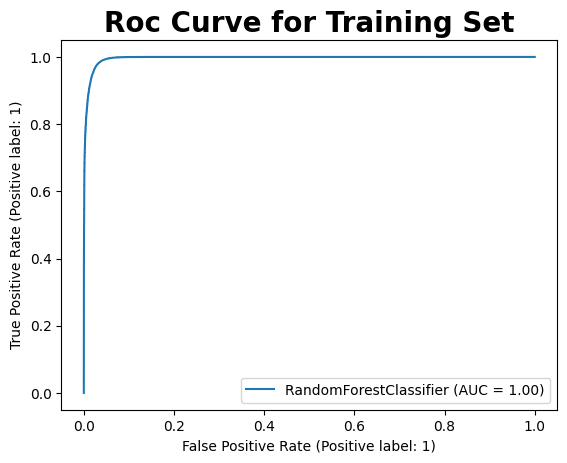

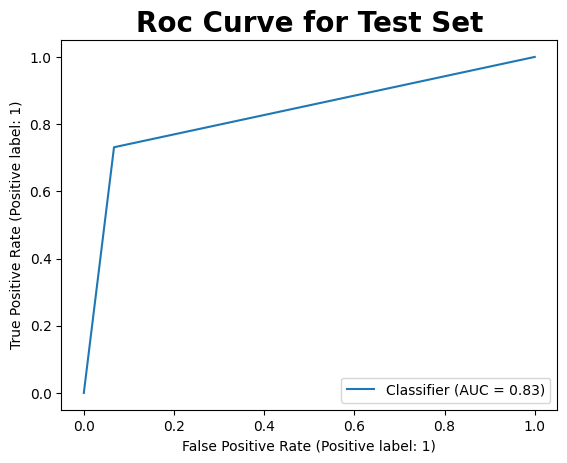

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     12609
           1       0.55      0.73      0.63      1391

    accuracy                           0.91     14000
   macro avg       0.76      0.83      0.79     14000
weighted avg       0.93      0.91      0.92     14000

Best accuracy score: 0.8996179712682558


In [ ]:
X_testComp = pc2.transform(X_test_lognormalDf)

RocCurveDisplay.from_estimator(rf_best3, pca_components, y_resampled_smote)
plt.title("Roc Curve for Training Set", fontsize=20, fontweight="bold")
plt.show()

y_pred = grid_search3.predict(X_testComp)

RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("Roc Curve for Test Set", fontsize=20, fontweight="bold")
plt.show()

print(classification_report(y_test, y_pred))
print("Best accuracy score:", grid_search2.best_score_)

using PCA dramatically increased Recall it also had positive impact on precision

In [ ]:
rf_best_gridSearch3 = {"max_depth":20, "min_samples_leaf":5, "n_jobs":-1,
                       "random_state":42}
rf_bestTofit3 = RandomForestClassifier(**rf_best_gridSearch3)
rf_bestTofit3.fit(pca_components, y_resampled_smote)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))
feature_importances3 = pd.DataFrame(list(zip(['component_'+str(i) for i in range(20)], rf_bestTofit3.feature_importances_)), columns= ["col", "importance"])
feature_importances3.sort_values(by="importance", ascending=False)

<IPython.core.display.Javascript object>

col  importance
1    component_1    0.220212
0    component_0    0.200456
4    component_4    0.070764
2    component_2    0.058366
6    component_6    0.042200
18  component_18    0.042131
5    component_5    0.036042
10  component_10    0.030859
14  component_14    0.030671
19  component_19    0.030566
13  component_13    0.030135
3    component_3    0.029065
11  component_11    0.028967
17  component_17    0.024297
16  component_16    0.022026
9    component_9    0.021468
15  component_15    0.021391
7    component_7    0.021199
12  component_12    0.021111
8    component_8    0.018074

<IPython.core.display.Javascript object>

<BarContainer object of 20 artists>

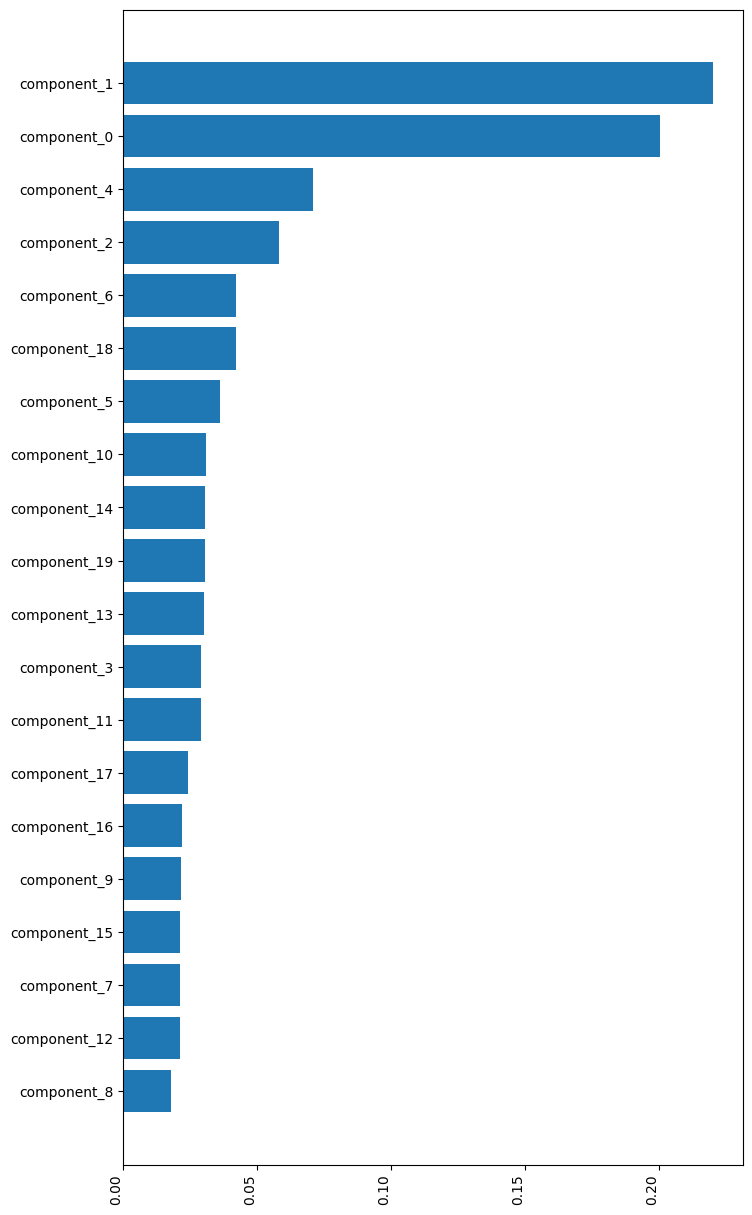

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

plt.figure(figsize=(8,15))
plt.xticks(rotation=90, ha='right')
feature_importances = feature_importances3.sort_values(by="importance", ascending=True)
plt.barh(feature_importances['col'], feature_importances['importance'])


# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [ ]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_resampled_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [ ]:
lr.score(pca_components[:,:2], y_resampled_smote)

0.8039018663695332

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [ ]:
ptlr = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
implr = SimpleImputer(strategy='mean')
scalelr = StandardScaler()
pcalr = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [ ]:
pipe = Pipeline(steps = [('imputation',implr),
                         ('scaling',scalelr),
                         ('transformation', ptlr),
                         ('pca',pcalr),
                         ('model',lr)])

In [ ]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('transformation', PowerTransformer(standardize=False)),
                ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [ ]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9173378096037429


In [ ]:
X_test = pd.DataFrame(X_test, columns=new_vars)
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.09935714285714285


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [ ]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[49252,  1006],
       [ 3623,  2118]])

In [ ]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[    0, 12609],
       [    0,  1391]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [ ]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.09935714285714285

In [ ]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

1.0

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  69999   91.882   65.330   64.445        31.78        20.23        23.11   
1  70000  414.168  515.568  360.868        75.51        41.21        19.84   
2  70001  329.844  434.884  746.239         7.54         7.86         8.40   
3  70002   43.550  171.390   24.400         5.31         2.16         0.00   
4  70003  306.854  406.289  413.329       450.93       609.03       700.68   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         60.16         32.16         34.83           0.00           0.00   
1        474.34        621.84        394.94           0.00           0.00   
2         16.98         45.81         45.04          22.81         103.38   
3         40.04        205.01         24.01           0.00           0.00   
4         60.94         23.84         74.16           0.00           0.00   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0           0.00           0.00           0.00           0.00   
1           0.00           0.00           0.00           0.00   
2          26.08          24.53          53.68          54.44   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0             24.88             20.23             21.06             18.13   
1             75.51             41.21             19.84            473.61   
2              0.00              0.00              0.00              0.00   
3              5.31              0.00              0.00              2.94   
4              0.45              0.78             14.56              2.39   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             10.89              8.36              0.00             13.58   
1            598.08            377.26              0.73              0.00   
2              0.00              0.00              0.00              0.00   
3             98.61             20.51              0.00              0.00   
4              2.66             10.94              0.00              0.00   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00               0.0              0.00              0.03   
1              0.00               0.0              0.00              0.00   
2              0.00               0.0              0.00              0.00   
3              2.35               0.0              6.18              0.00   
4              0.00               0.0              0.00              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0         43.01         44.71         29.43              6.90   
1        549.86        639.29        397.11              0.00   
2          0.00          0.00          0.00              0.00   
3          8.26         98.61         22.86              0.00   
4          2.84          3.44         25.51            450.48   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0              0.00              2.05             42.03              7.68   
1              0.00              0.00              0.00             23.76   
2              0.00              0.00              0.00              0.00   
3              2.16              0.00             37.09             94.36   
4            608.24            686.11             58.54             21.18   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0             26.43               0.0               0.0               0.0   
1             17.68               0.0               0.0               0.0   
2              0.00               0.0               0.0               0.0   
3              0.00               0.0               0.0               0.0   
4             63.18               0.0               0.0

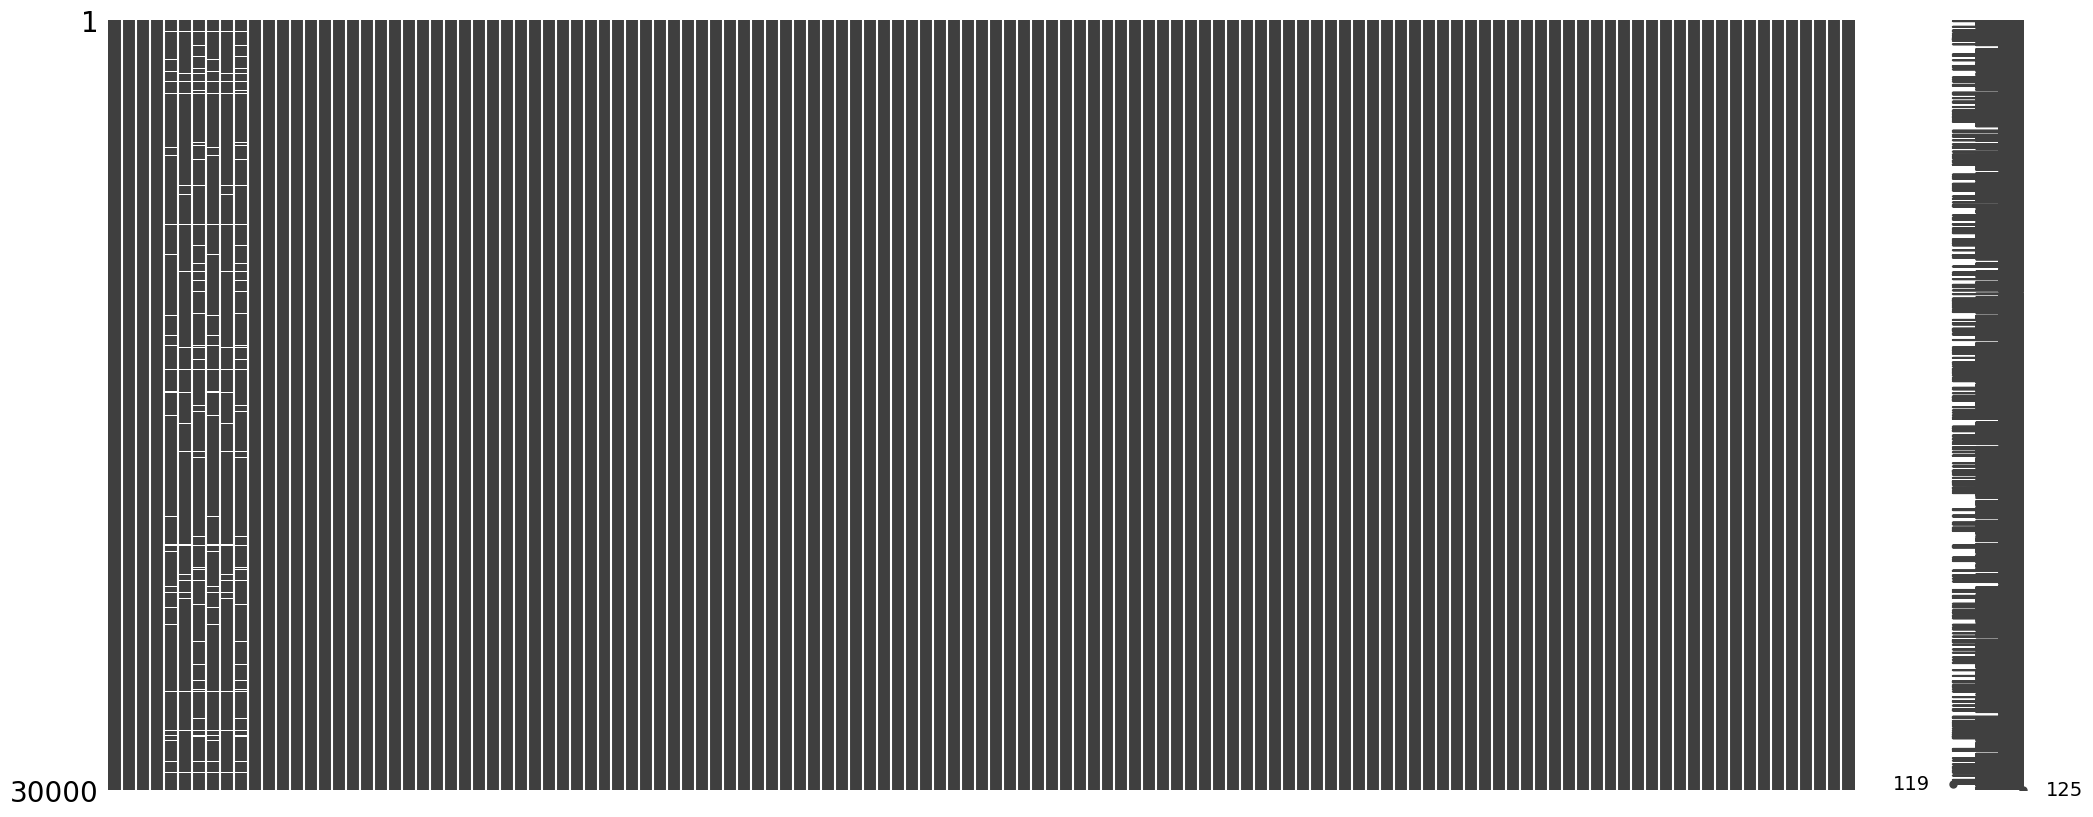

In [ ]:
msno.matrix(unseen)
unseen.head()

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

<Axes: >

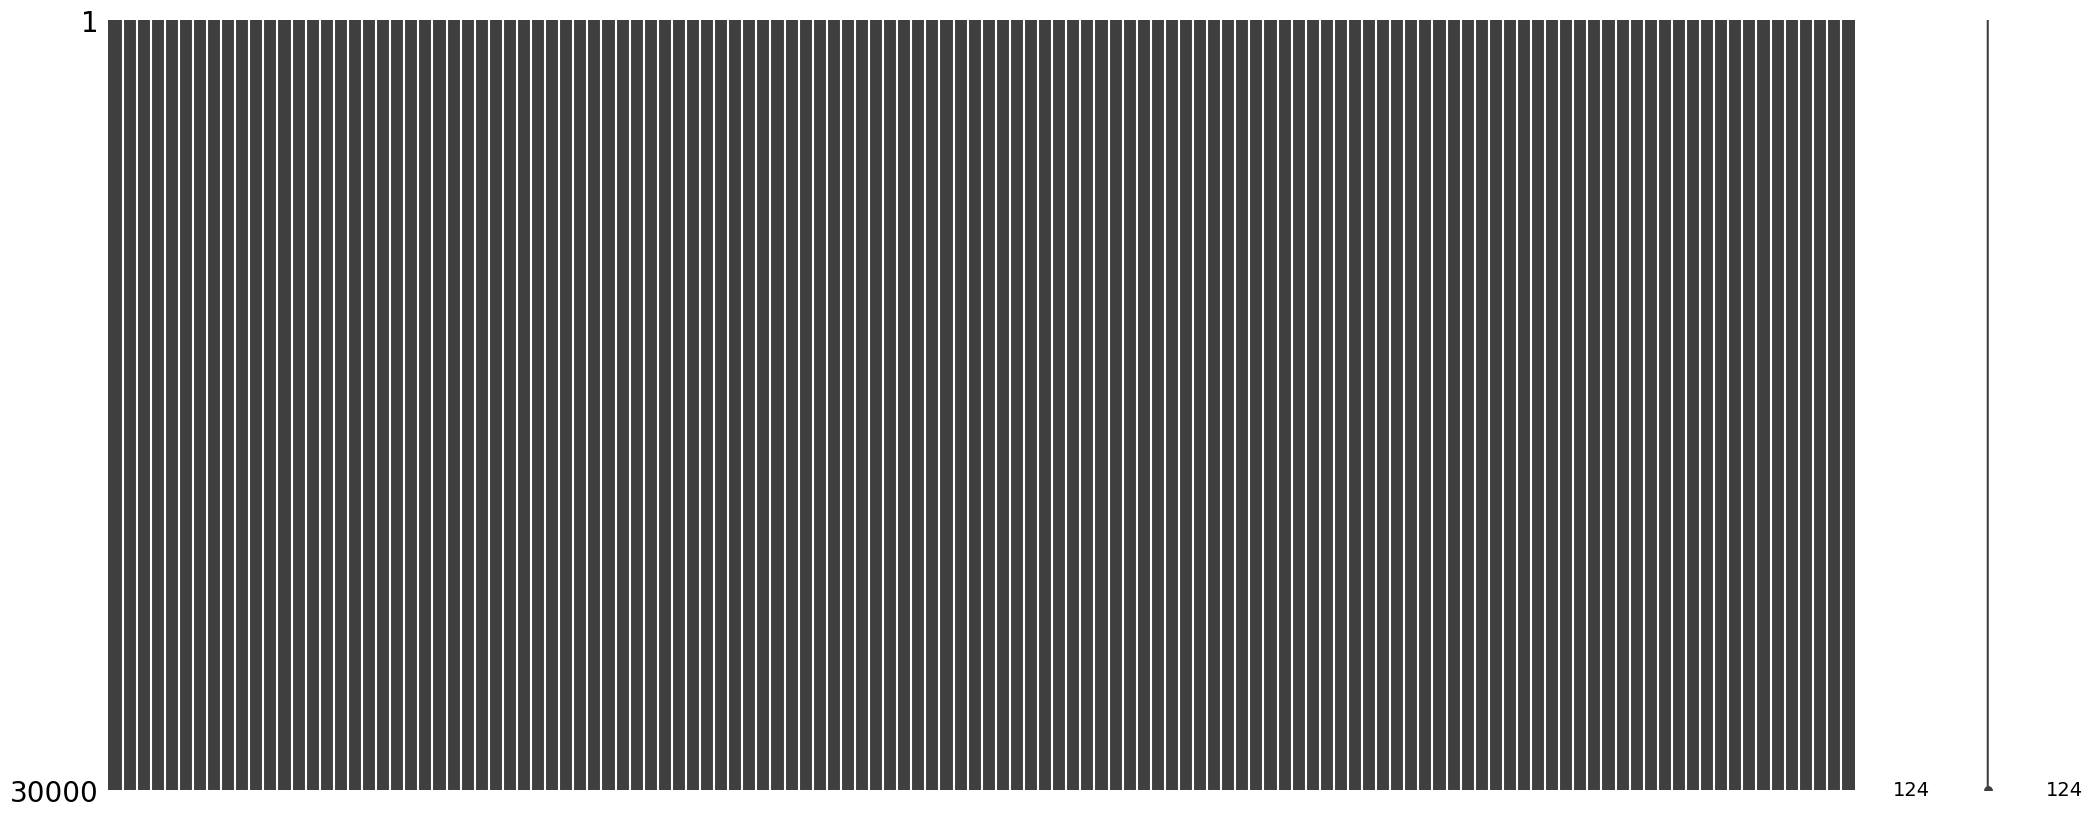

In [ ]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

submission_data[impute_cols] = imp.transform(submission_data[impute_cols])
submission_data_scaled = scale.transform(submission_data)
submission_data_transformed = pt.transform(submission_data_scaled)

submission_data_components = pc2.transform(submission_data_transformed)
msno.matrix(pd.DataFrame(submission_data_transformed, columns=new_vars))

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = rf_bestTofit3.predict(submission_data_components)
output = unseen[['id','churn_probability']]
output.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

In [ ]:
unseen.churn_probability.value_counts()

0    26026
1     3974
Name: churn_probability, dtype: int64

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv(f'{ROOT}/RastehNili_submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.